# CNN + ELM para classificação

In [3]:
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import scipy

print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name(0)

True


'NVIDIA GeForce GTX 1650'

# ELM

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class CELMModel1d(nn.Module):
    def __init__(
        self, n_channels, n_classes, hidden_layer_size, reg_constant=None, small=False
    ):
        super(CELMModel1d, self).__init__()

        # Camada conv
        if small:
            self.cnn = nn.Sequential(
                # Bloco 1
                nn.Conv1d(n_channels, 16, kernel_size=8),  # entrada
                nn.ReLU(),
                nn.MaxPool1d(kernel_size=2),
                # Bloco 2
                nn.Conv1d(16, 16, kernel_size=32),
                nn.ReLU(),
                nn.MaxPool1d(kernel_size=2),
            )
        else:
            self.cnn = nn.Sequential(
                nn.Conv1d(n_channels, 64, kernel_size=8),
                # nn.Dropout(0.3),
                nn.ReLU(),
                nn.MaxPool1d(kernel_size=2),
                nn.Conv1d(64, 32, kernel_size=8),
                # nn.Dropout(0.3),
                nn.ReLU(),
                nn.MaxPool1d(kernel_size=2),
                nn.Conv1d(32, 32, kernel_size=8),
                # nn.Dropout(0.3),
                nn.ReLU(),
                nn.MaxPool1d(kernel_size=2),
                nn.Conv1d(32, 16, kernel_size=8),
                # nn.Dropout(0.3),
                nn.ReLU(),
                nn.MaxPool1d(kernel_size=2),
            )

        # Set false para evitar treinar
        for param in self.cnn.parameters():
            param.requires_grad = False

        # ELM
        self.features_size = 720 if small else 144
        self.elm_hidden_layer_size = hidden_layer_size

        self.elm_input_weights = nn.Parameter(
            torch.empty(
                self.features_size, self.elm_hidden_layer_size
            ),  # Num de features x Num neuronios da elm
            requires_grad=False,
        )
        self.elm_input_bias = nn.Parameter(
            torch.zeros(self.elm_hidden_layer_size),
            requires_grad=False,
        )
        self.elm_activation = nn.Softmax()

        # Inicia com zerio pois vai preencher no treino
        self.elm_output_weights = nn.Parameter(
            torch.zeros(self.elm_hidden_layer_size, n_classes), requires_grad=False
        )

        self._initialize_weights()

        self.reg_constant = reg_constant

    def _initialize_weights(self):
        # Init
        for layer in self.cnn:
            if isinstance(layer, nn.Conv1d):
                nn.init.orthogonal_(
                    layer.weight,
                )
                if layer.bias is not None:
                    nn.init.normal_(layer.bias)

        # Init input layer
        nn.init.orthogonal_(self.elm_input_weights)
        nn.init.normal_(self.elm_input_bias)

    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)

        # ELM hidden layer
        H = self.elm_activation(
            torch.mm(x, self.elm_input_weights) + self.elm_input_bias
        )

        # ELM output layer
        output = torch.mm(H, self.elm_output_weights)
        return F.softmax(output, dim=1)

    def train_elm(self, train_loader, n_classes, save_path="trained_elm.pth", device=0):
        # self.eval()  # Tira do modo de treino para nao treinar as camadas da cnn
        H_list, y_list = [], []

        with torch.no_grad():
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Extrai features, flatten e passa pra gpu
                # Esse é a entrada x da elm
                features = self.cnn(inputs).view(inputs.size(0), -1).to(device)

                # Matriz H pra cada vetor de entradas (features)
                # o resultado dessa multiplicação de matrizes é um vetor linha
                # cada elemento i é h_i(wx + b), onde i o neuronio i da camada profunda
                H = self.elm_activation(
                    torch.mm(features, self.elm_input_weights) + self.elm_input_bias
                )

                H_list.append(H)
                y_list.append(F.one_hot(labels, num_classes=n_classes).float())

        # "Empilha" as linhas para montar H e y
        H_full = torch.cat(H_list, dim=0)
        Y_full = torch.cat(y_list, dim=0)

        if self.reg_constant is None:
            # https://pytorch.org/docs/stable/generated/torch.linalg.pinv.html
            # torch.linalg.lstsq(A, B).solution == pinv(A) @ B
            self.elm_output_weights.data = torch.linalg.lstsq(H_full, Y_full).solution
        else:
            # Regularização
            I = torch.eye(H_full.shape[1]).to(device)
            H_reg = torch.mm(H_full.t(), H_full) + (I / self.reg_constant)
            HY = torch.mm(H_full.t(), Y_full)

            # https://pytorch.org/docs/stable/generated/torch.linalg.pinv.html
            # torch.linalg.lstsq(A, B).solution == pinv(A) @ B
            self.elm_output_weights.data = torch.linalg.lstsq(H_reg, HY).solution

        torch.save(self.state_dict(), save_path)

In [10]:
windows = np.load(
    "datasets/sinais_filtrados_6_52_Hz_janelas_1s/S1_passa-banda_6_52_Hz_janelas.npy"
)
windows.shape

(64, 250, 40, 6, 5)

In [11]:
frequencias_fases = scipy.io.loadmat("Freq_Phase.mat")
frequencias = np.round(
    frequencias_fases["freqs"], 2
)  # Frequências de estimulação, arredondadas
fases = frequencias_fases["phases"]  # Fases associadas às frequências

freq_selecionadas = np.array([8, 10, 12, 15])  # Frequências de interesse
channels = [
    47,
    53,
    54,
    55,
    56,
    57,
    60,
    61,
    62,
]  #  Pz, PO5, PO3, POz, PO4, PO6, O1, Oz, O2

channel_Oz = 61
labels = []
signals = []
for trial in range(0, 6):
    labels_trial = []
    signals_trial = []
    for idx, freq in enumerate(freq_selecionadas):
        for window in range(0, 5):
            signal = windows[
                channels, :, np.where(frequencias == freq)[1], trial, window
            ]
            signals_trial.append(signal)
            labels_trial.append(idx)
    labels.append(labels_trial)
    signals.append(signals_trial)

signals = np.array(signals)
labels = np.array(labels)
print(signals.shape)
print(labels.shape)

(6, 20, 9, 250)
(6, 20)


In [7]:
from sklearn.preprocessing import MinMaxScaler


def split_train_test_trials(X, y, test_trial):
    y_test = []
    y_train = []
    X_test = []
    X_train = []

    X_shape = X.shape
    X_reshaped = X.reshape(-1, X.shape[-1])
    scaler = MinMaxScaler(feature_range=(0, 1))
    X_transformed = scaler.fit_transform(X_reshaped.T).T  # normaliza entre 0 e 1
    X_transformed = X_transformed.reshape(X_shape)

    for trial in range(0, 6):
        if trial == test_trial:
            X_test.extend(X_transformed[trial])
            y_test.extend(y[trial])
        else:
            X_train.extend(X_transformed[trial])
            y_train.extend(y[trial])
    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)


def prepare_data(X, y, test_trial=5, train_batch_size=16, test_batch_size=1):
    X_train, X_test, y_train, y_test = split_train_test_trials(X, y, test_trial)
    train_data = TensorDataset(
        torch.tensor(X_train, dtype=torch.float32).to(device),
        torch.tensor(y_train, dtype=torch.long).to(device),
    )
    test_data = TensorDataset(
        torch.tensor(X_test, dtype=torch.float32).to(device),
        torch.tensor(y_test, dtype=torch.long).to(device),
    )
    train_loader = DataLoader(train_data, batch_size=train_batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=test_batch_size, shuffle=True)
    return train_loader, test_loader

c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


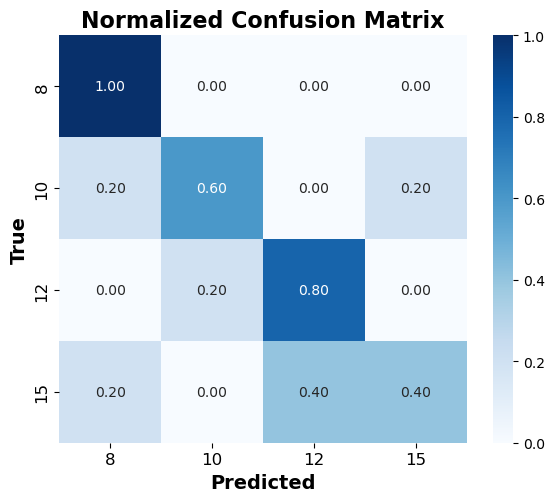

Test set Accuracy: 0.7000
Recall: 0.7000
F1 Score: 0.6818
Confusion Matrix:
[[5 0 0 0]
 [1 3 0 1]
 [0 1 4 0]
 [1 0 2 2]]


(0.7, 0.7, 0.6818181818181817)

In [24]:
from utils import evaluate

# Initialize model
n_channels = 9  # Number of input channels
elm_hidden_units = 1024  # Number of ELM hidden units
n_classes = 4  # Number of output classes
regularization = None
small = True

model = CELMModel1d(n_channels, n_classes, elm_hidden_units, regularization, True).to(
    device
)

train_loader, test_loader = prepare_data(
    signals, labels, test_trial=0, train_batch_size=100
)

# Train ELM output weights
model.train_elm(train_loader, n_classes)

# Evaluate on test set
evaluate(model, test_loader, ["8", "10", "12", "15"], device=0)
# evaluate(model, train_loader, ["8", "10", "12", "15"], device=0)

In [25]:
frequencias_fases = scipy.io.loadmat("Freq_Phase.mat")
frequencias = np.round(
    frequencias_fases["freqs"], 2
)  # Frequências de estimulação, arredondadas
fases = frequencias_fases["phases"]  # Fases associadas às frequências

freq_selecionadas = np.array([8, 10, 12, 15])  # Frequências de interesse
channels = [
    47,
    53,
    54,
    55,
    56,
    57,
    60,
    61,
    62,
]  #  Pz, PO5, PO3, POz, PO4, PO6, O1, Oz, O2

channel_Oz = 61
labels = []
signals = []
for trial in range(0, 6):
    for idx, freq in enumerate(freq_selecionadas):
        for window in range(0, 5):
            signal = windows[
                channels, :, np.where(frequencias == freq)[1], trial, window
            ]
            signals_trial.append(signal)
            labels_trial.append(idx)
    labels.append(labels_trial)
    signals.append(signals_trial)

signals = np.array(signals)
labels = np.array(labels)
print(signals.shape)
print(labels.shape)

(6, 20, 9, 250)
(6, 20)


In [27]:
from utils import get_desired_freqs_and_classes, evaluate
from pathlib import Path


def run_and_evaluate(subject, signals, labels, batch_size, elm_hidden_units):
    all_acc = []
    all_recall = []
    all_f1 = []
    for test_trial in range(0, 6):
        train_loader, test_loader = prepare_data(
            signals, labels, test_trial=test_trial, train_batch_size=batch_size
        )

        num_channels = signals.shape[2]
        num_freqs = len(np.unique(labels))

        model = CELMModel1d(num_channels, num_freqs, elm_hidden_units, small=True).to(
            device
        )
        # Train the model
        best_model_save_path = f"trained_elms/{subject}_{test_trial}_elm.pth"
        model.train_elm(
            train_loader,
            num_freqs,
            save_path=best_model_save_path,
        )
        # Eval
        acc, rcll, f1s = evaluate(
            model, test_loader, class_labels=["8", "10", "12", "15"]
        )
        all_acc.append(acc)
        all_recall.append(rcll)
        all_f1.append(f1s)
    metrics = {
        "accuracy": np.array(all_acc),
        "recall": np.array(all_recall),
        "f1_score": np.array(all_f1),
    }
    return metrics


def run_celm_for_all_subjects(
    dataset_path, batch_size, channels, classes, elm_hidden_units
):
    results = {}

    subjects_files = [file for file in dataset_path.glob("*.npy")]
    freq_phase = scipy.io.loadmat("Freq_Phase.mat")
    freqs = np.round(freq_phase["freqs"], 2)  # Frequências de estimulação, arredondadas

    def sort_key(path):
        subject_number = int(path.stem.split("_")[0][1:])
        return subject_number

    # Ordena
    sorted_paths = sorted(subjects_files, key=sort_key)
    for subject_file in sorted_paths:
        subject = subject_file.name.split("_")[0]
        print(f"Running for subject {subject} ---------------")
        windows = np.load(subject_file)
        signals, labels = get_desired_freqs_and_classes(
            windows, freqs, channels, classes
        )
        results[subject] = run_and_evaluate(
            subject, signals, labels, batch_size, elm_hidden_units
        )
    return results

Running for subject S1 ---------------


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


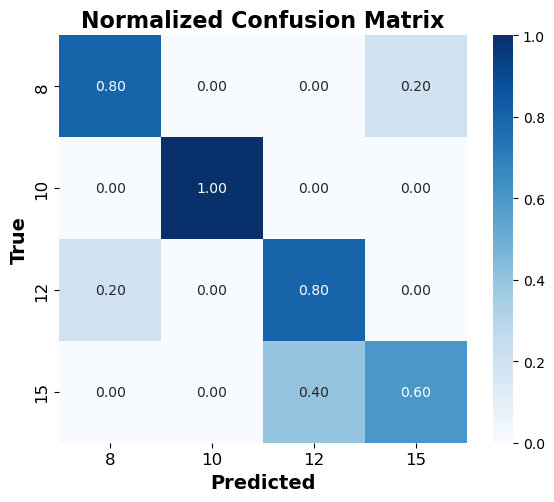

Test set Accuracy: 0.8000
Recall: 0.8000
F1 Score: 0.7985
Confusion Matrix:
[[4 0 0 1]
 [0 5 0 0]
 [1 0 4 0]
 [0 0 2 3]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


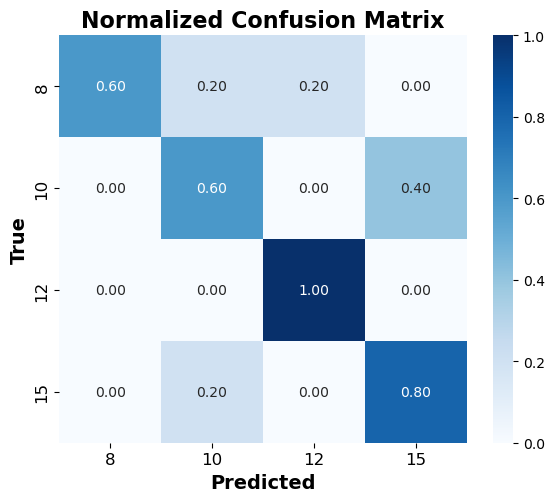

Test set Accuracy: 0.7500
Recall: 0.7500
F1 Score: 0.7466
Confusion Matrix:
[[3 1 1 0]
 [0 3 0 2]
 [0 0 5 0]
 [0 1 0 4]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


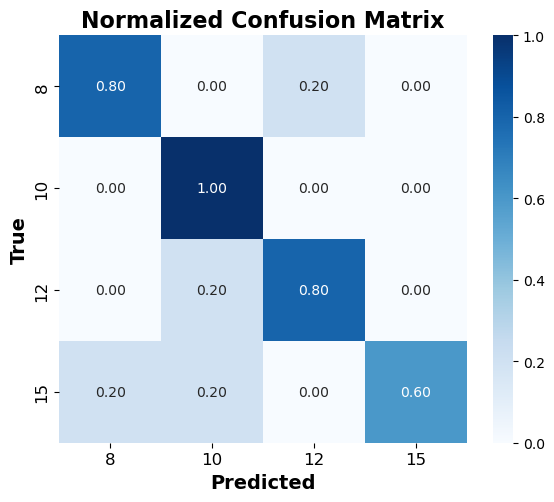

Test set Accuracy: 0.8000
Recall: 0.8000
F1 Score: 0.7958
Confusion Matrix:
[[4 0 1 0]
 [0 5 0 0]
 [0 1 4 0]
 [1 1 0 3]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


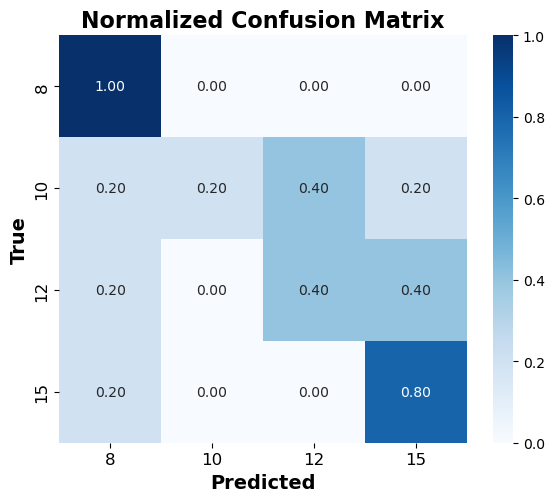

Test set Accuracy: 0.6000
Recall: 0.6000
F1 Score: 0.5534
Confusion Matrix:
[[5 0 0 0]
 [1 1 2 1]
 [1 0 2 2]
 [1 0 0 4]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


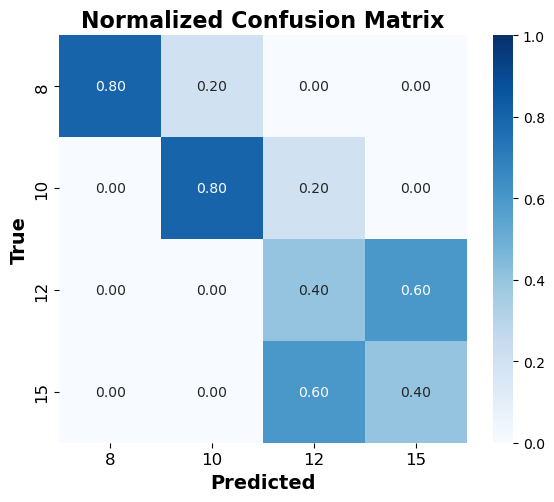

Test set Accuracy: 0.6000
Recall: 0.6000
F1 Score: 0.6131
Confusion Matrix:
[[4 1 0 0]
 [0 4 1 0]
 [0 0 2 3]
 [0 0 3 2]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


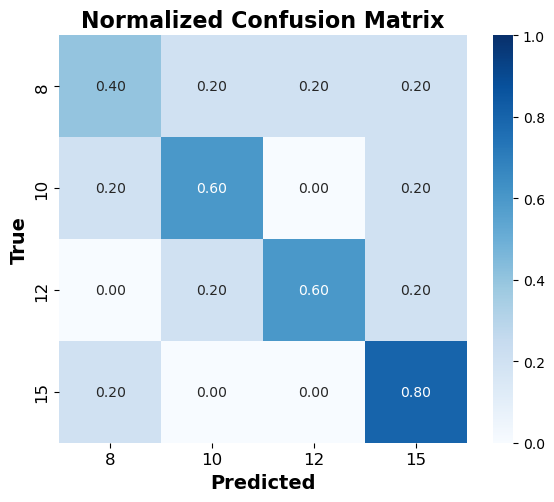

Test set Accuracy: 0.6000
Recall: 0.6000
F1 Score: 0.5944
Confusion Matrix:
[[2 1 1 1]
 [1 3 0 1]
 [0 1 3 1]
 [1 0 0 4]]
Running for subject S2 ---------------


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


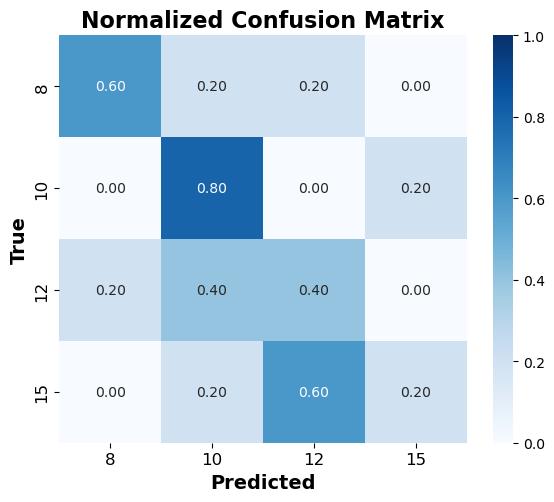

Test set Accuracy: 0.5000
Recall: 0.5000
F1 Score: 0.4829
Confusion Matrix:
[[3 1 1 0]
 [0 4 0 1]
 [1 2 2 0]
 [0 1 3 1]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


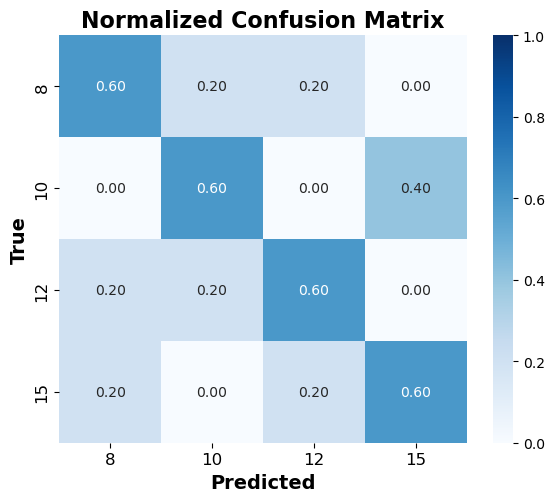

Test set Accuracy: 0.6000
Recall: 0.6000
F1 Score: 0.6000
Confusion Matrix:
[[3 1 1 0]
 [0 3 0 2]
 [1 1 3 0]
 [1 0 1 3]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


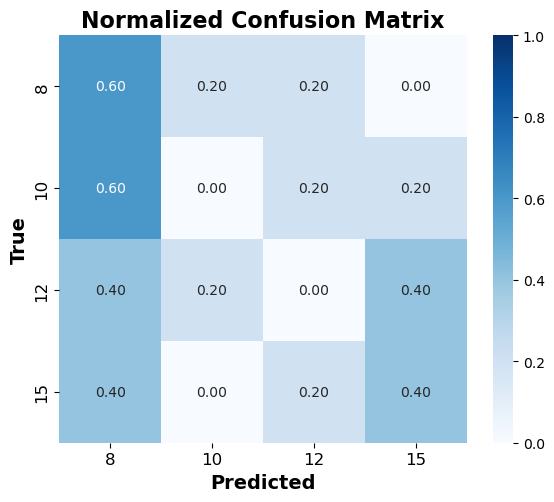

Test set Accuracy: 0.2500
Recall: 0.2500
F1 Score: 0.2000
Confusion Matrix:
[[3 1 1 0]
 [3 0 1 1]
 [2 1 0 2]
 [2 0 1 2]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


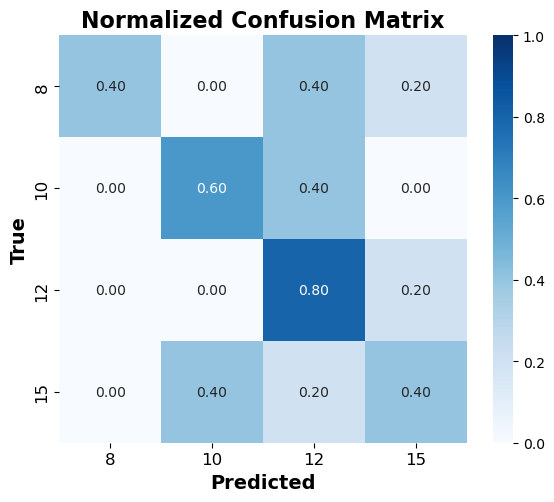

Test set Accuracy: 0.5500
Recall: 0.5500
F1 Score: 0.5468
Confusion Matrix:
[[2 0 2 1]
 [0 3 2 0]
 [0 0 4 1]
 [0 2 1 2]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


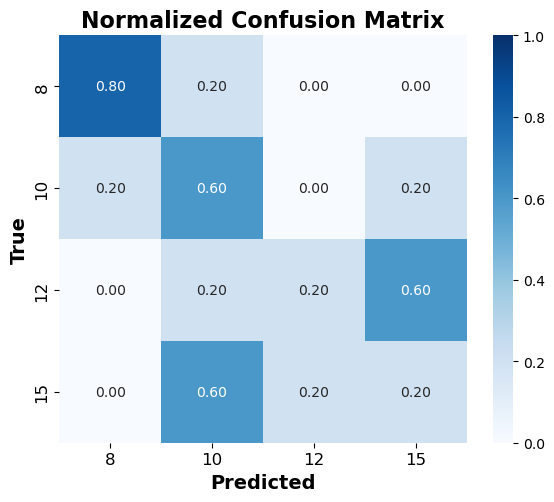

Test set Accuracy: 0.4500
Recall: 0.4500
F1 Score: 0.4368
Confusion Matrix:
[[4 1 0 0]
 [1 3 0 1]
 [0 1 1 3]
 [0 3 1 1]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


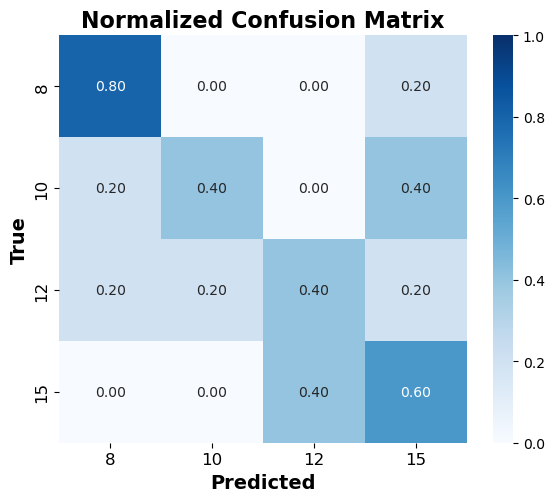

Test set Accuracy: 0.5500
Recall: 0.5500
F1 Score: 0.5429
Confusion Matrix:
[[4 0 0 1]
 [1 2 0 2]
 [1 1 2 1]
 [0 0 2 3]]
Running for subject S3 ---------------


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


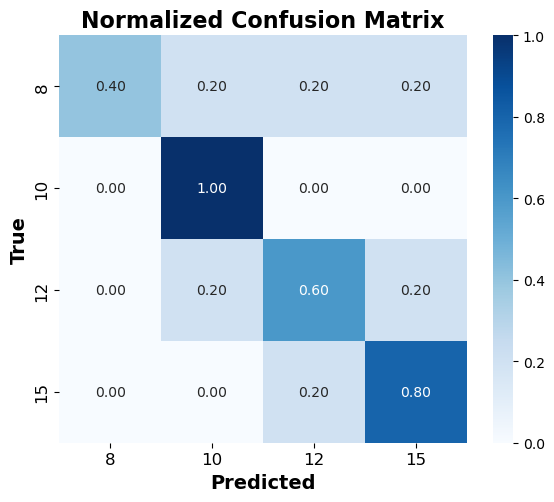

Test set Accuracy: 0.7000
Recall: 0.7000
F1 Score: 0.6830
Confusion Matrix:
[[2 1 1 1]
 [0 5 0 0]
 [0 1 3 1]
 [0 0 1 4]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


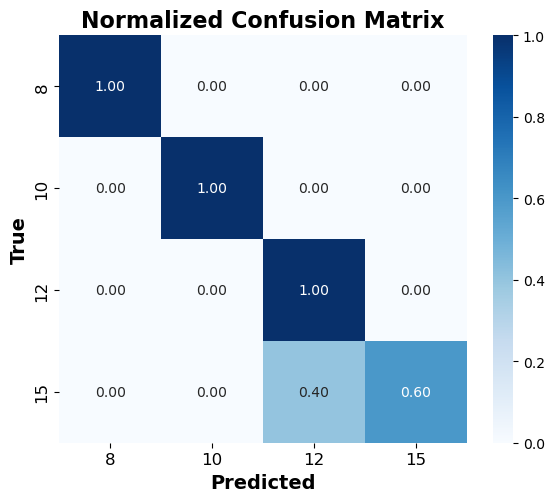

Test set Accuracy: 0.9000
Recall: 0.9000
F1 Score: 0.8958
Confusion Matrix:
[[5 0 0 0]
 [0 5 0 0]
 [0 0 5 0]
 [0 0 2 3]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


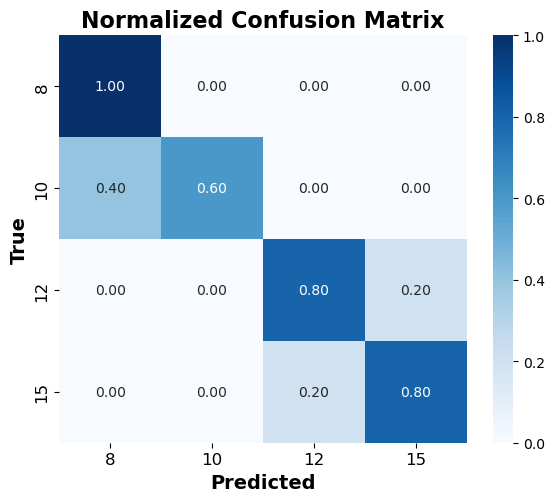

Test set Accuracy: 0.8000
Recall: 0.8000
F1 Score: 0.7958
Confusion Matrix:
[[5 0 0 0]
 [2 3 0 0]
 [0 0 4 1]
 [0 0 1 4]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


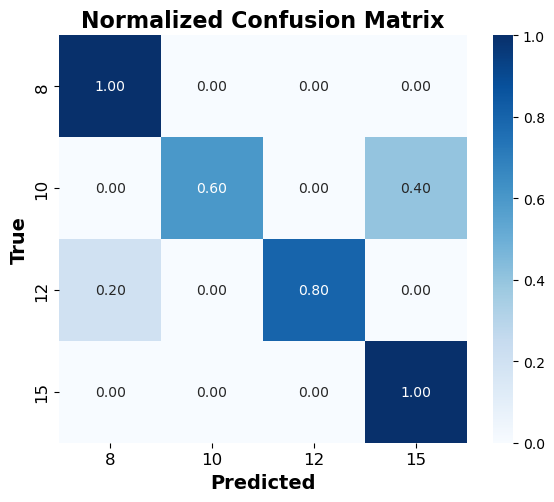

Test set Accuracy: 0.8500
Recall: 0.8500
F1 Score: 0.8453
Confusion Matrix:
[[5 0 0 0]
 [0 3 0 2]
 [1 0 4 0]
 [0 0 0 5]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


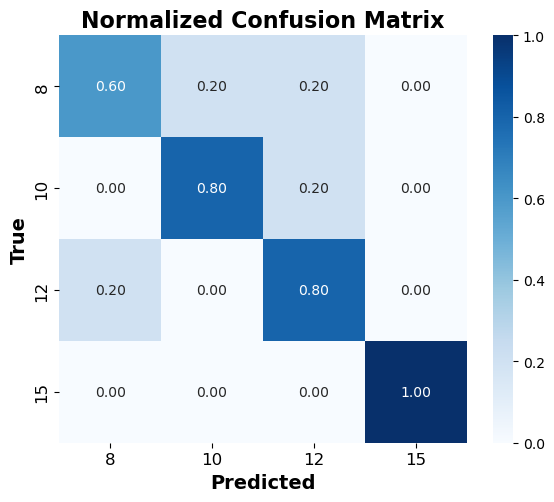

Test set Accuracy: 0.8000
Recall: 0.8000
F1 Score: 0.7985
Confusion Matrix:
[[3 1 1 0]
 [0 4 1 0]
 [1 0 4 0]
 [0 0 0 5]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


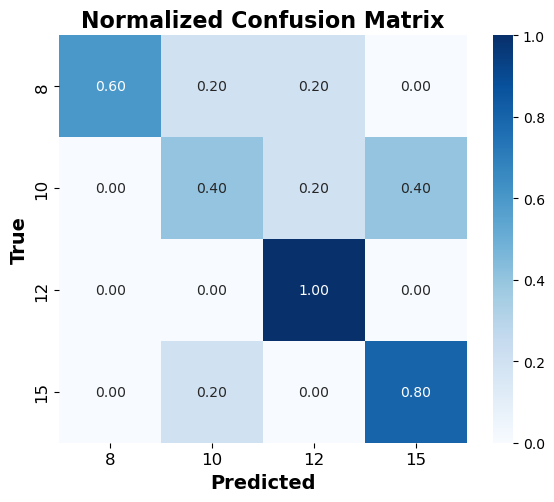

Test set Accuracy: 0.7000
Recall: 0.7000
F1 Score: 0.6888
Confusion Matrix:
[[3 1 1 0]
 [0 2 1 2]
 [0 0 5 0]
 [0 1 0 4]]
Running for subject S4 ---------------


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


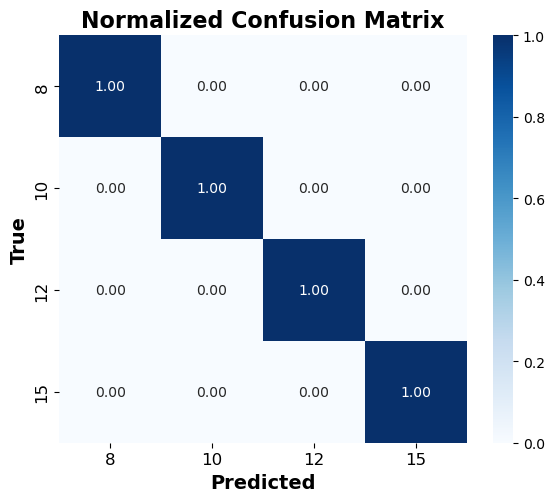

Test set Accuracy: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Confusion Matrix:
[[5 0 0 0]
 [0 5 0 0]
 [0 0 5 0]
 [0 0 0 5]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


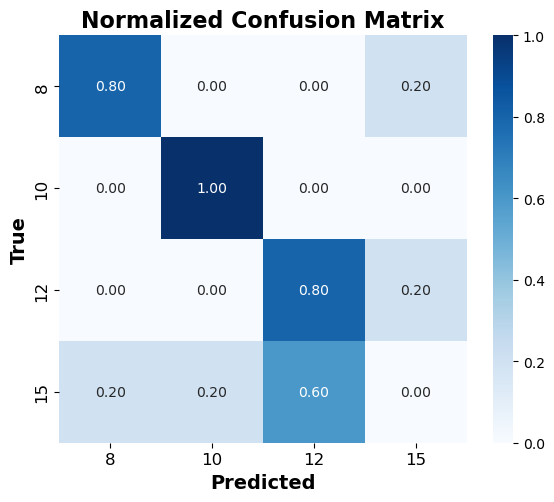

Test set Accuracy: 0.6500
Recall: 0.6500
F1 Score: 0.5939
Confusion Matrix:
[[4 0 0 1]
 [0 5 0 0]
 [0 0 4 1]
 [1 1 3 0]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


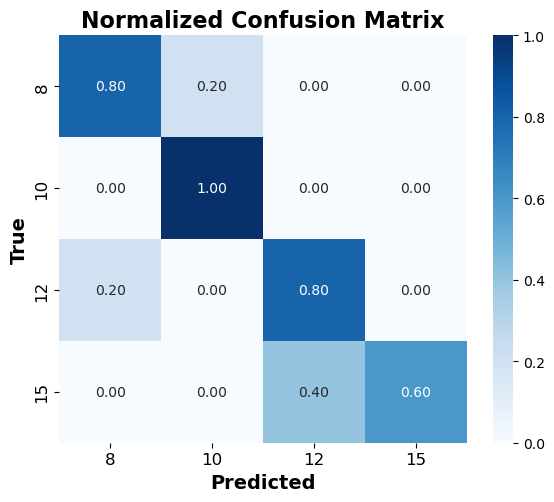

Test set Accuracy: 0.8000
Recall: 0.8000
F1 Score: 0.7966
Confusion Matrix:
[[4 1 0 0]
 [0 5 0 0]
 [1 0 4 0]
 [0 0 2 3]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


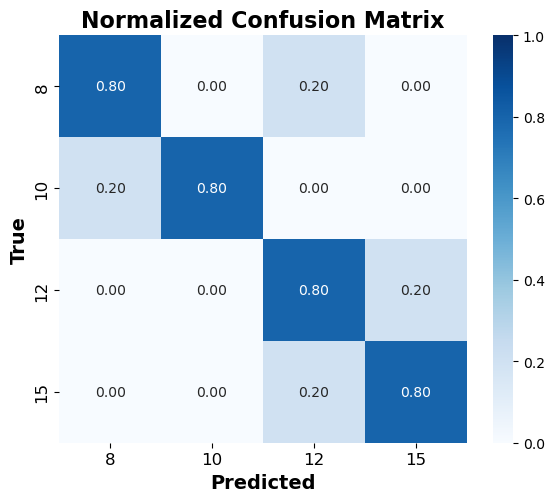

Test set Accuracy: 0.8000
Recall: 0.8000
F1 Score: 0.8040
Confusion Matrix:
[[4 0 1 0]
 [1 4 0 0]
 [0 0 4 1]
 [0 0 1 4]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


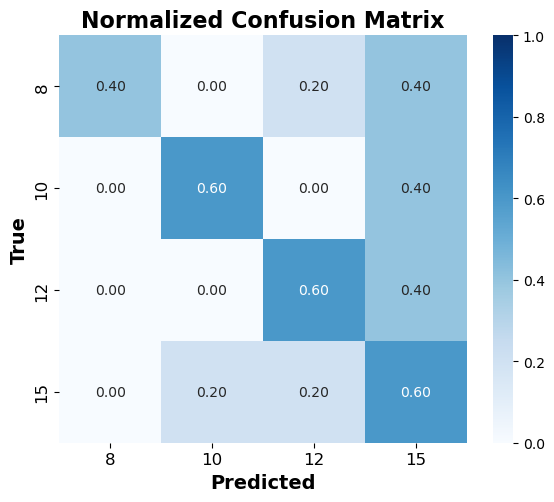

Test set Accuracy: 0.5500
Recall: 0.5500
F1 Score: 0.5667
Confusion Matrix:
[[2 0 1 2]
 [0 3 0 2]
 [0 0 3 2]
 [0 1 1 3]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


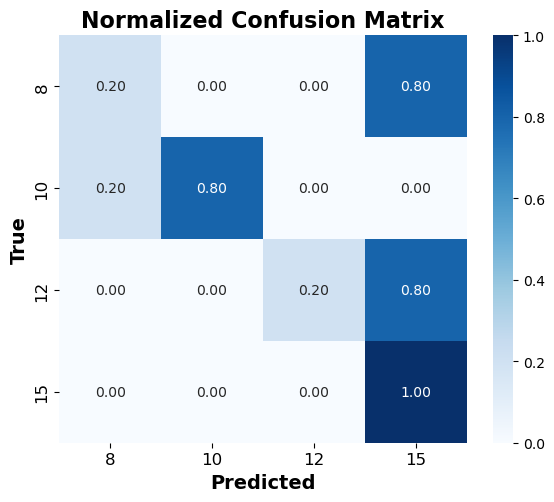

Test set Accuracy: 0.5500
Recall: 0.5500
F1 Score: 0.5159
Confusion Matrix:
[[1 0 0 4]
 [1 4 0 0]
 [0 0 1 4]
 [0 0 0 5]]
Running for subject S5 ---------------


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


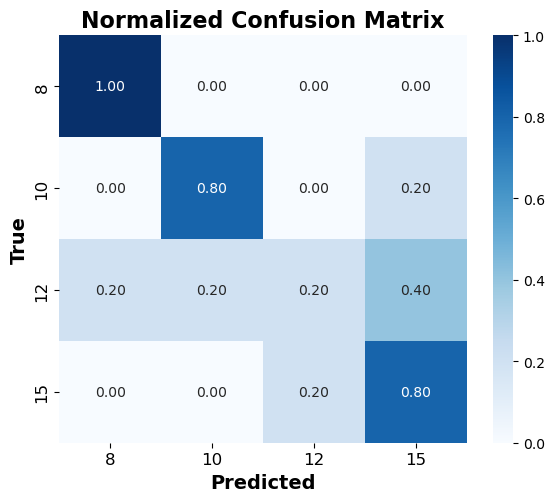

Test set Accuracy: 0.7000
Recall: 0.7000
F1 Score: 0.6654
Confusion Matrix:
[[5 0 0 0]
 [0 4 0 1]
 [1 1 1 2]
 [0 0 1 4]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


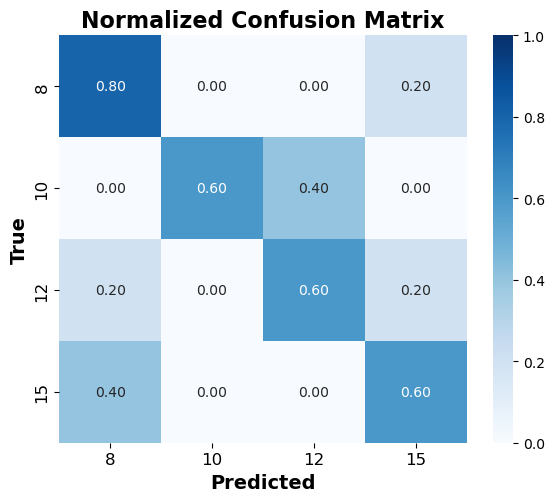

Test set Accuracy: 0.6500
Recall: 0.6500
F1 Score: 0.6542
Confusion Matrix:
[[4 0 0 1]
 [0 3 2 0]
 [1 0 3 1]
 [2 0 0 3]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


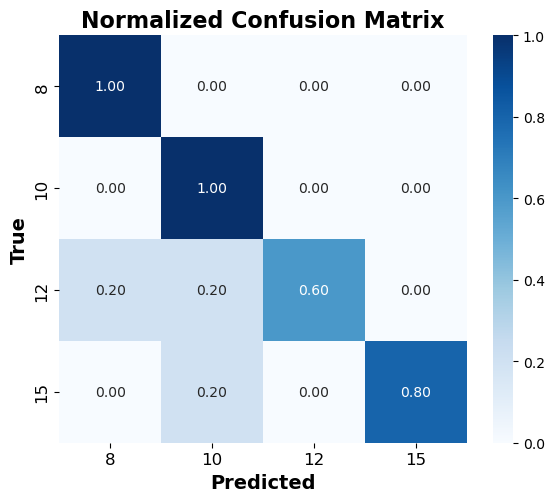

Test set Accuracy: 0.8500
Recall: 0.8500
F1 Score: 0.8453
Confusion Matrix:
[[5 0 0 0]
 [0 5 0 0]
 [1 1 3 0]
 [0 1 0 4]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


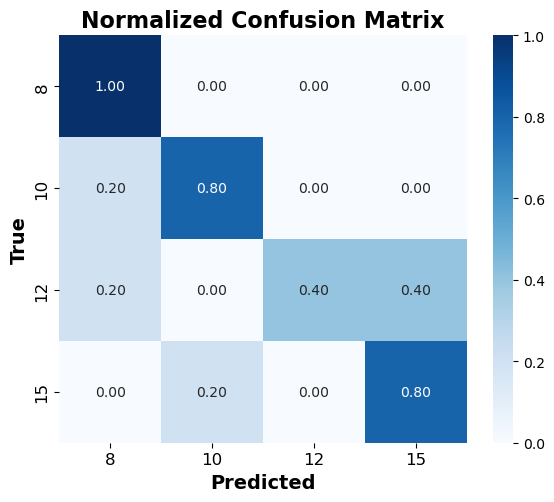

Test set Accuracy: 0.7500
Recall: 0.7500
F1 Score: 0.7330
Confusion Matrix:
[[5 0 0 0]
 [1 4 0 0]
 [1 0 2 2]
 [0 1 0 4]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


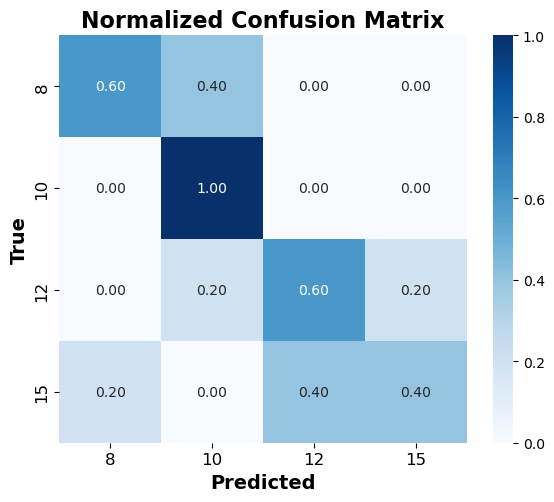

Test set Accuracy: 0.6500
Recall: 0.6500
F1 Score: 0.6340
Confusion Matrix:
[[3 2 0 0]
 [0 5 0 0]
 [0 1 3 1]
 [1 0 2 2]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


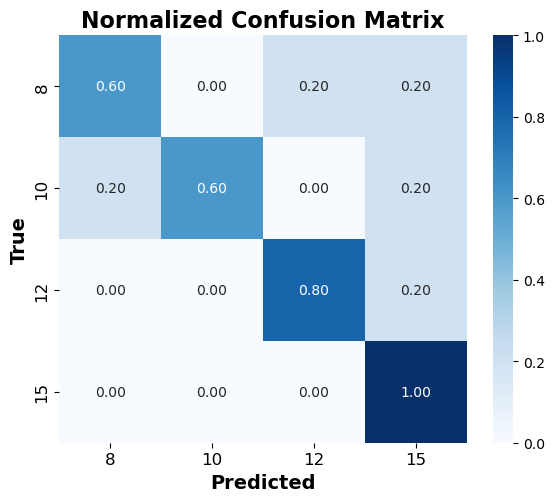

Test set Accuracy: 0.7500
Recall: 0.7500
F1 Score: 0.7465
Confusion Matrix:
[[3 0 1 1]
 [1 3 0 1]
 [0 0 4 1]
 [0 0 0 5]]
Running for subject S6 ---------------


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


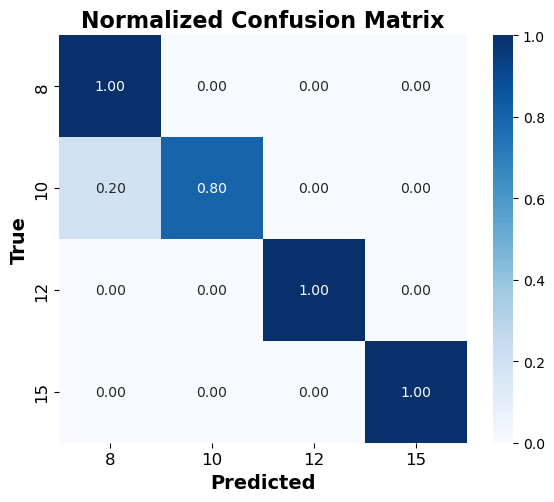

Test set Accuracy: 0.9500
Recall: 0.9500
F1 Score: 0.9495
Confusion Matrix:
[[5 0 0 0]
 [1 4 0 0]
 [0 0 5 0]
 [0 0 0 5]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


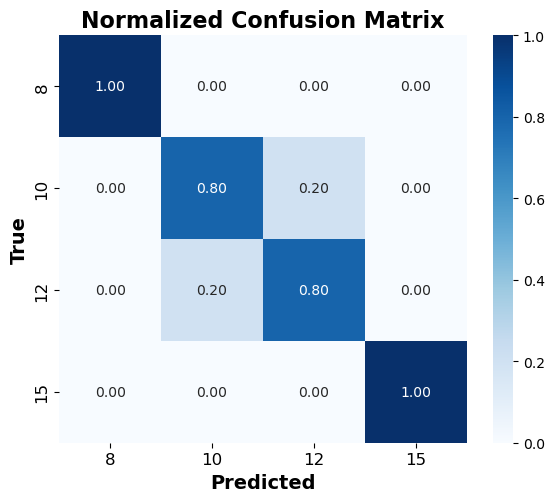

Test set Accuracy: 0.9000
Recall: 0.9000
F1 Score: 0.9000
Confusion Matrix:
[[5 0 0 0]
 [0 4 1 0]
 [0 1 4 0]
 [0 0 0 5]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


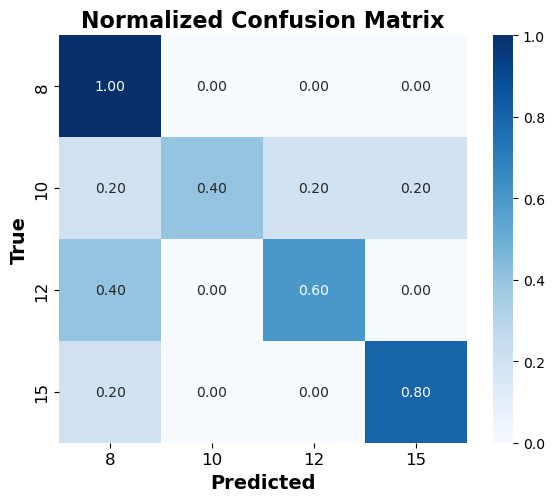

Test set Accuracy: 0.7000
Recall: 0.7000
F1 Score: 0.6881
Confusion Matrix:
[[5 0 0 0]
 [1 2 1 1]
 [2 0 3 0]
 [1 0 0 4]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


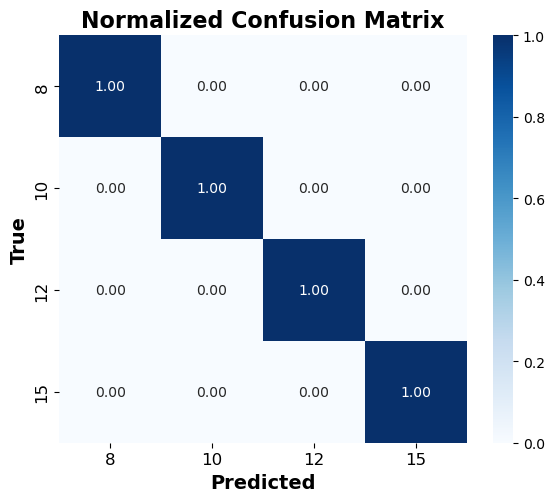

Test set Accuracy: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Confusion Matrix:
[[5 0 0 0]
 [0 5 0 0]
 [0 0 5 0]
 [0 0 0 5]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


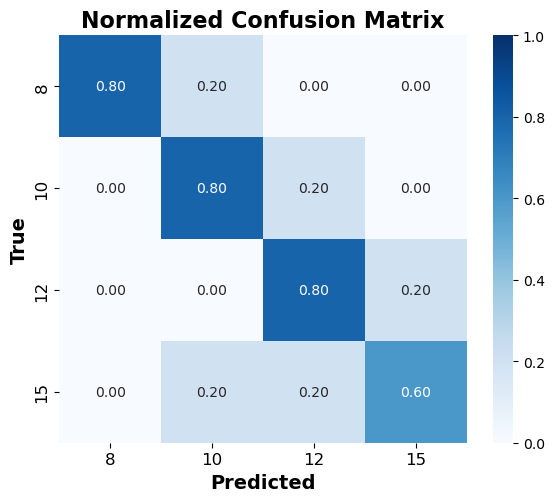

Test set Accuracy: 0.7500
Recall: 0.7500
F1 Score: 0.7525
Confusion Matrix:
[[4 1 0 0]
 [0 4 1 0]
 [0 0 4 1]
 [0 1 1 3]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


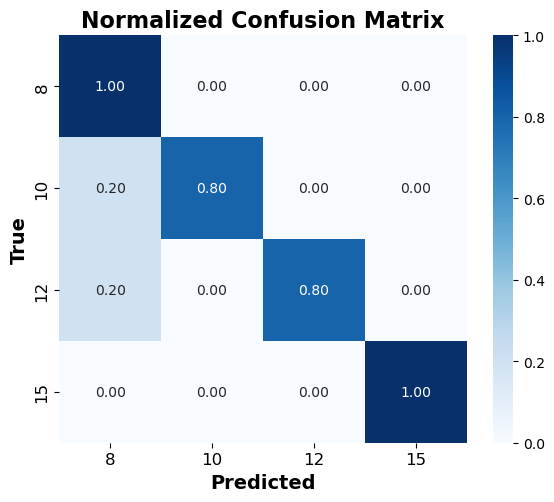

Test set Accuracy: 0.9000
Recall: 0.9000
F1 Score: 0.9028
Confusion Matrix:
[[5 0 0 0]
 [1 4 0 0]
 [1 0 4 0]
 [0 0 0 5]]
Running for subject S7 ---------------


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


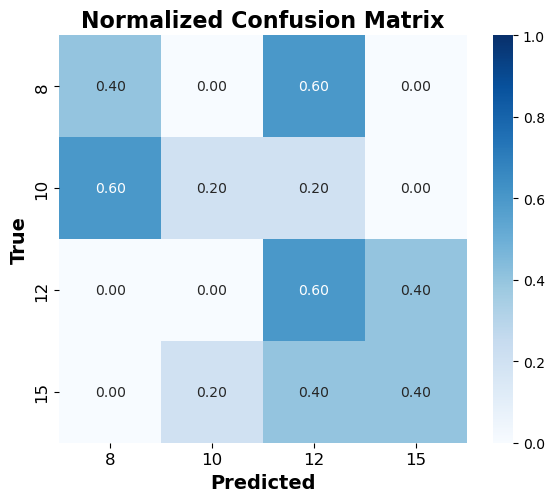

Test set Accuracy: 0.4000
Recall: 0.4000
F1 Score: 0.3897
Confusion Matrix:
[[2 0 3 0]
 [3 1 1 0]
 [0 0 3 2]
 [0 1 2 2]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


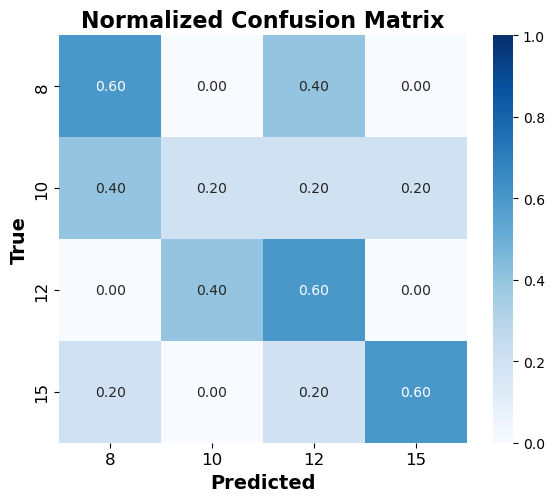

Test set Accuracy: 0.5000
Recall: 0.5000
F1 Score: 0.4905
Confusion Matrix:
[[3 0 2 0]
 [2 1 1 1]
 [0 2 3 0]
 [1 0 1 3]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


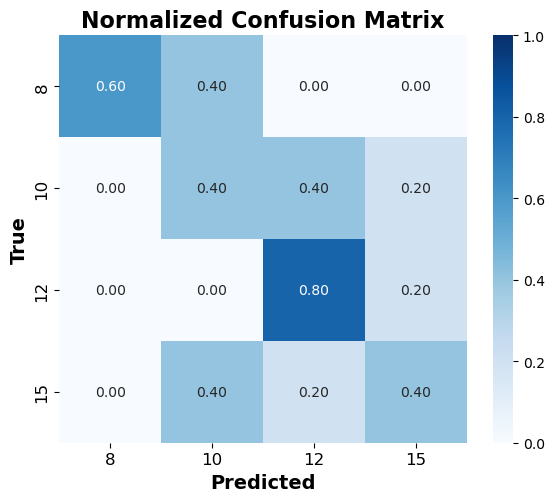

Test set Accuracy: 0.5500
Recall: 0.5500
F1 Score: 0.5562
Confusion Matrix:
[[3 2 0 0]
 [0 2 2 1]
 [0 0 4 1]
 [0 2 1 2]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


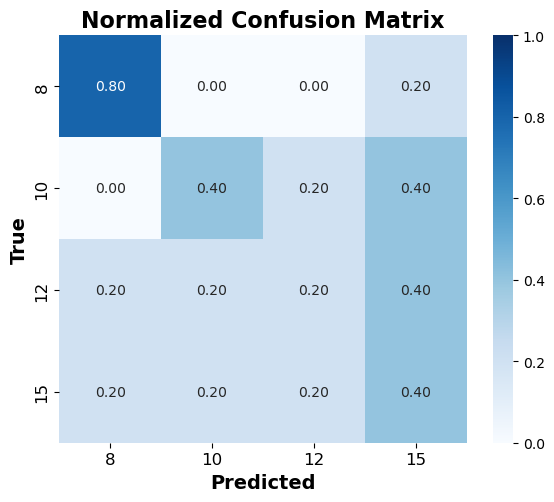

Test set Accuracy: 0.4500
Recall: 0.4500
F1 Score: 0.4388
Confusion Matrix:
[[4 0 0 1]
 [0 2 1 2]
 [1 1 1 2]
 [1 1 1 2]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


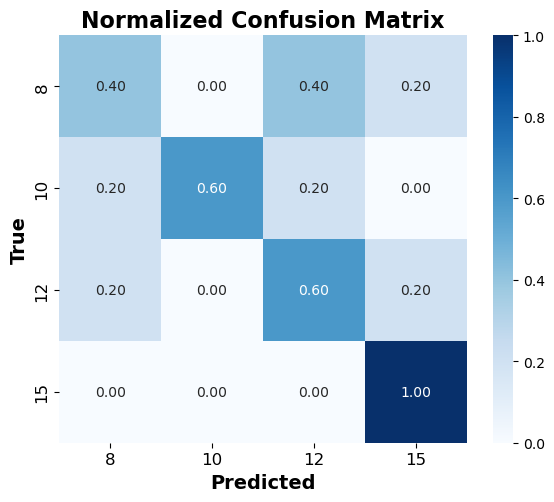

Test set Accuracy: 0.6500
Recall: 0.6500
F1 Score: 0.6433
Confusion Matrix:
[[2 0 2 1]
 [1 3 1 0]
 [1 0 3 1]
 [0 0 0 5]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


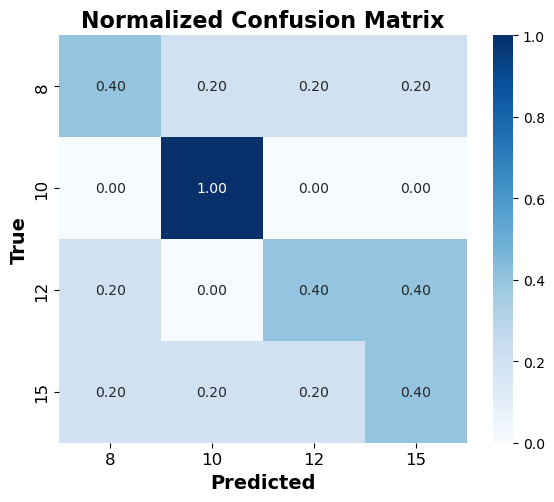

Test set Accuracy: 0.5500
Recall: 0.5500
F1 Score: 0.5306
Confusion Matrix:
[[2 1 1 1]
 [0 5 0 0]
 [1 0 2 2]
 [1 1 1 2]]
Running for subject S8 ---------------


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


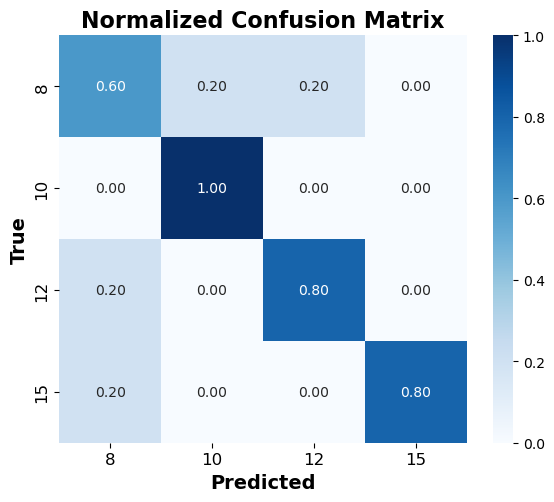

Test set Accuracy: 0.8000
Recall: 0.8000
F1 Score: 0.7995
Confusion Matrix:
[[3 1 1 0]
 [0 5 0 0]
 [1 0 4 0]
 [1 0 0 4]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


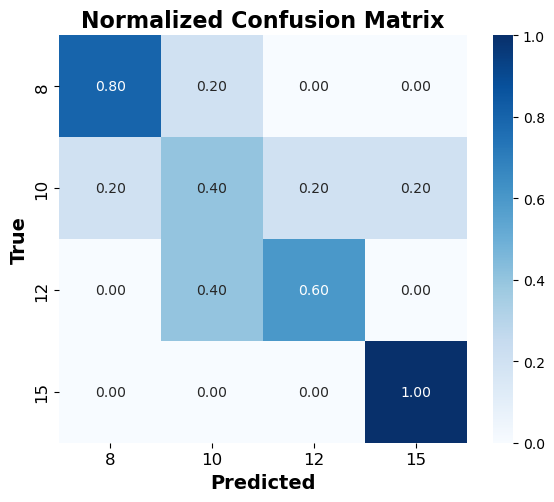

Test set Accuracy: 0.7000
Recall: 0.7000
F1 Score: 0.6939
Confusion Matrix:
[[4 1 0 0]
 [1 2 1 1]
 [0 2 3 0]
 [0 0 0 5]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


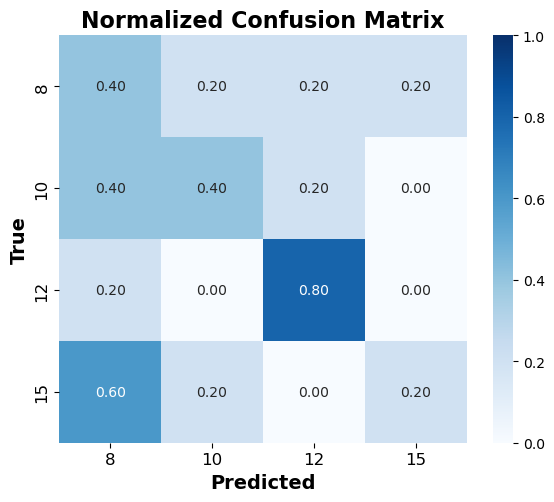

Test set Accuracy: 0.4500
Recall: 0.4500
F1 Score: 0.4413
Confusion Matrix:
[[2 1 1 1]
 [2 2 1 0]
 [1 0 4 0]
 [3 1 0 1]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


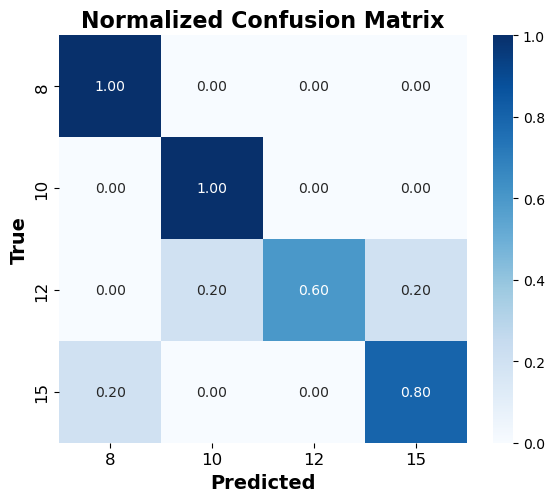

Test set Accuracy: 0.8500
Recall: 0.8500
F1 Score: 0.8420
Confusion Matrix:
[[5 0 0 0]
 [0 5 0 0]
 [0 1 3 1]
 [1 0 0 4]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


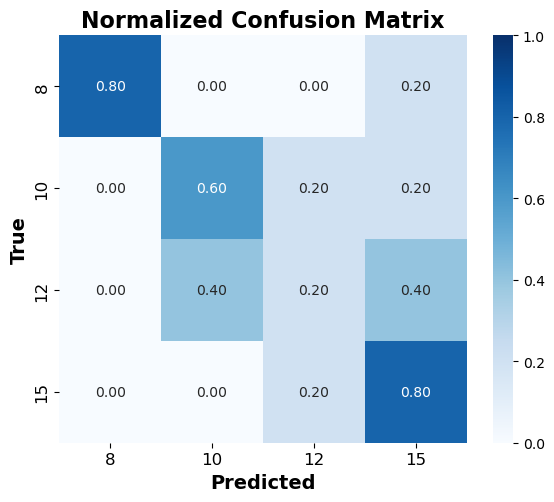

Test set Accuracy: 0.6000
Recall: 0.6000
F1 Score: 0.5886
Confusion Matrix:
[[4 0 0 1]
 [0 3 1 1]
 [0 2 1 2]
 [0 0 1 4]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


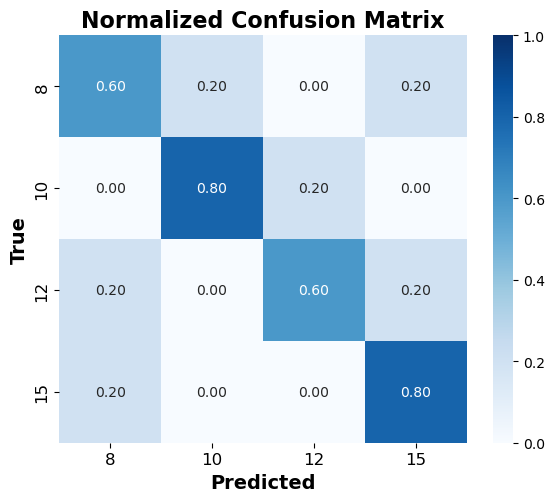

Test set Accuracy: 0.7000
Recall: 0.7000
F1 Score: 0.6985
Confusion Matrix:
[[3 1 0 1]
 [0 4 1 0]
 [1 0 3 1]
 [1 0 0 4]]
Running for subject S9 ---------------


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


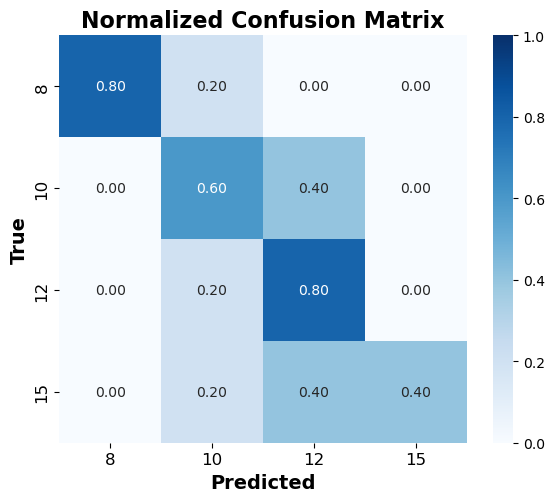

Test set Accuracy: 0.6500
Recall: 0.6500
F1 Score: 0.6553
Confusion Matrix:
[[4 1 0 0]
 [0 3 2 0]
 [0 1 4 0]
 [0 1 2 2]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


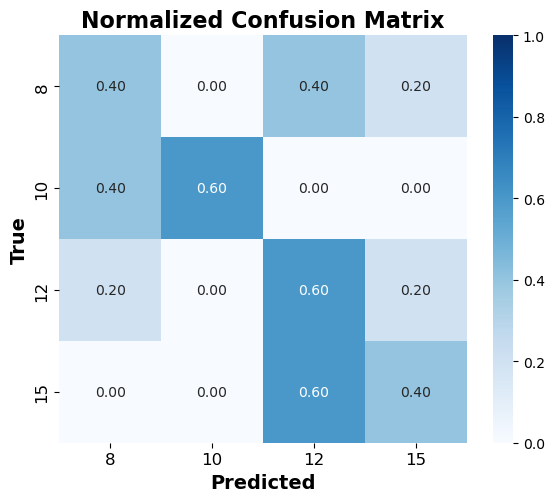

Test set Accuracy: 0.5000
Recall: 0.5000
F1 Score: 0.5140
Confusion Matrix:
[[2 0 2 1]
 [2 3 0 0]
 [1 0 3 1]
 [0 0 3 2]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


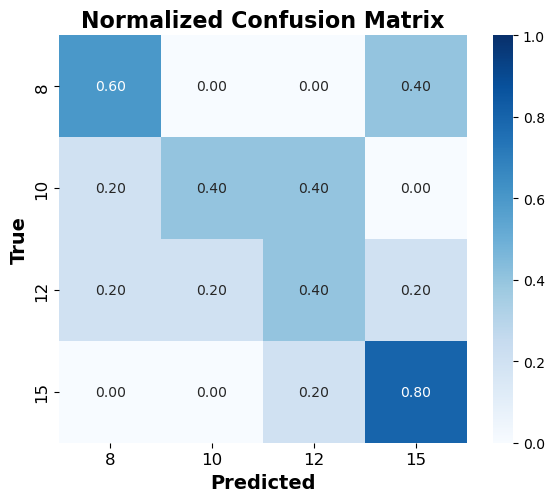

Test set Accuracy: 0.5500
Recall: 0.5500
F1 Score: 0.5417
Confusion Matrix:
[[3 0 0 2]
 [1 2 2 0]
 [1 1 2 1]
 [0 0 1 4]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


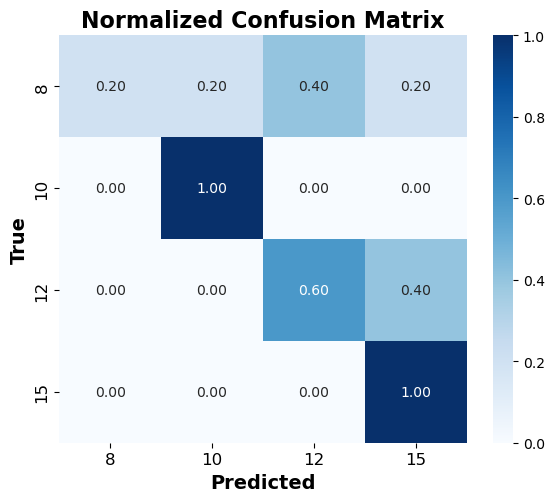

Test set Accuracy: 0.7000
Recall: 0.7000
F1 Score: 0.6529
Confusion Matrix:
[[1 1 2 1]
 [0 5 0 0]
 [0 0 3 2]
 [0 0 0 5]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


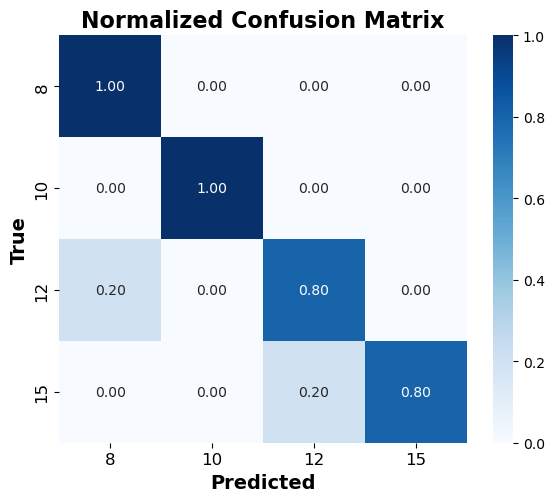

Test set Accuracy: 0.9000
Recall: 0.9000
F1 Score: 0.8995
Confusion Matrix:
[[5 0 0 0]
 [0 5 0 0]
 [1 0 4 0]
 [0 0 1 4]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


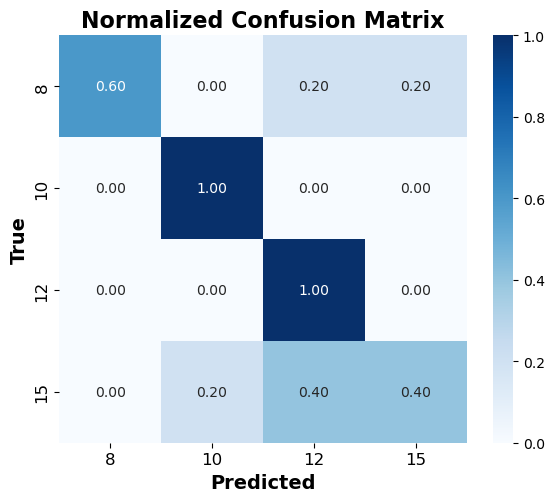

Test set Accuracy: 0.7500
Recall: 0.7500
F1 Score: 0.7321
Confusion Matrix:
[[3 0 1 1]
 [0 5 0 0]
 [0 0 5 0]
 [0 1 2 2]]
Running for subject S10 ---------------


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


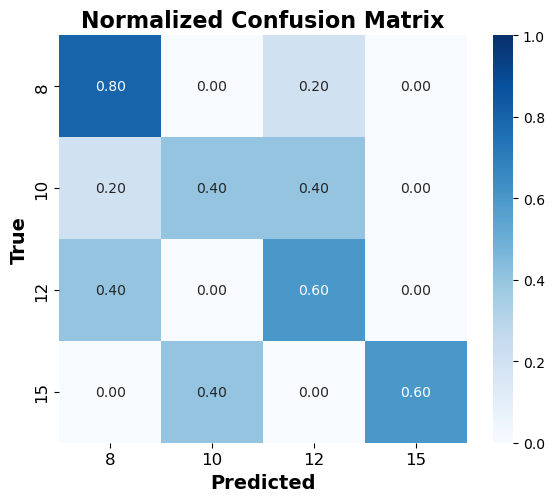

Test set Accuracy: 0.6000
Recall: 0.6000
F1 Score: 0.6016
Confusion Matrix:
[[4 0 1 0]
 [1 2 2 0]
 [2 0 3 0]
 [0 2 0 3]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


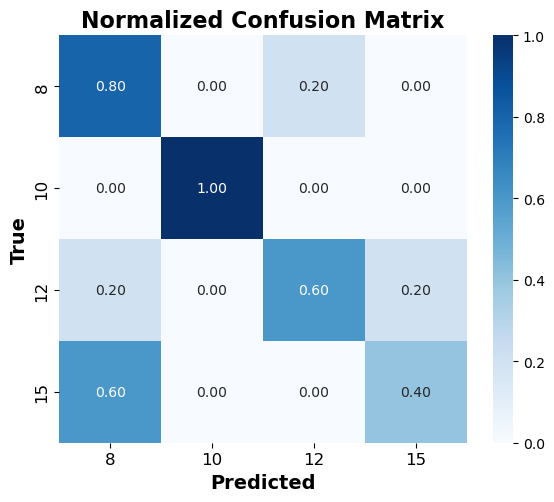

Test set Accuracy: 0.7000
Recall: 0.7000
F1 Score: 0.6955
Confusion Matrix:
[[4 0 1 0]
 [0 5 0 0]
 [1 0 3 1]
 [3 0 0 2]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


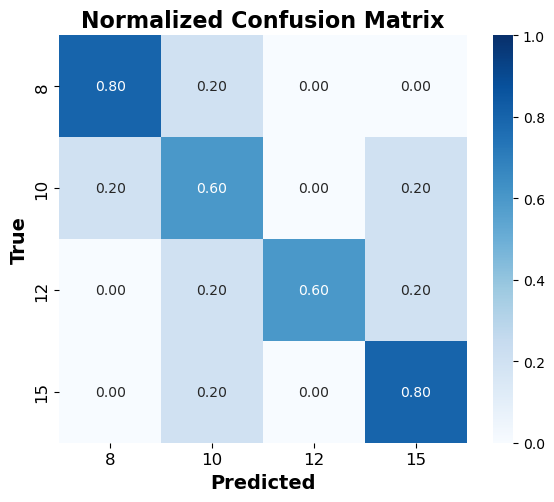

Test set Accuracy: 0.7000
Recall: 0.7000
F1 Score: 0.7057
Confusion Matrix:
[[4 1 0 0]
 [1 3 0 1]
 [0 1 3 1]
 [0 1 0 4]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


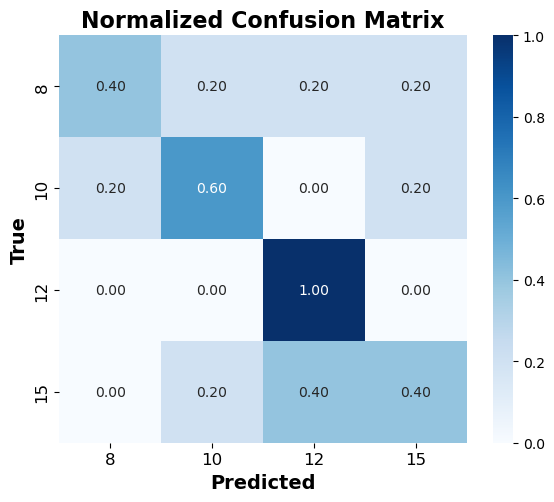

Test set Accuracy: 0.6000
Recall: 0.6000
F1 Score: 0.5784
Confusion Matrix:
[[2 1 1 1]
 [1 3 0 1]
 [0 0 5 0]
 [0 1 2 2]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


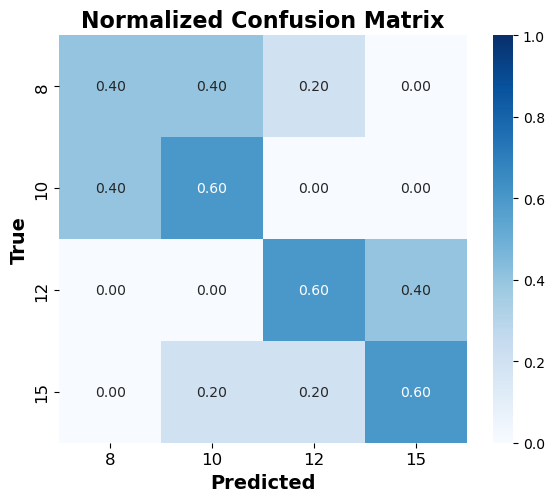

Test set Accuracy: 0.5500
Recall: 0.5500
F1 Score: 0.5475
Confusion Matrix:
[[2 2 1 0]
 [2 3 0 0]
 [0 0 3 2]
 [0 1 1 3]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


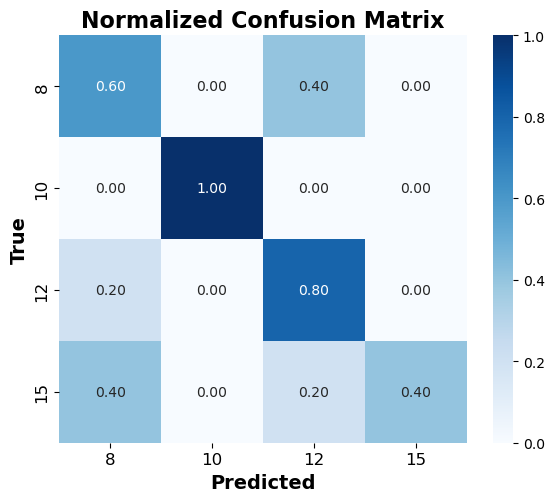

Test set Accuracy: 0.7000
Recall: 0.7000
F1 Score: 0.6959
Confusion Matrix:
[[3 0 2 0]
 [0 5 0 0]
 [1 0 4 0]
 [2 0 1 2]]
Running for subject S11 ---------------


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


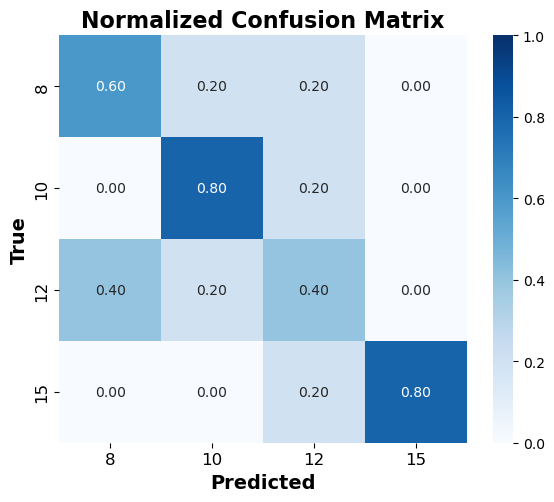

Test set Accuracy: 0.6500
Recall: 0.6500
F1 Score: 0.6540
Confusion Matrix:
[[3 1 1 0]
 [0 4 1 0]
 [2 1 2 0]
 [0 0 1 4]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


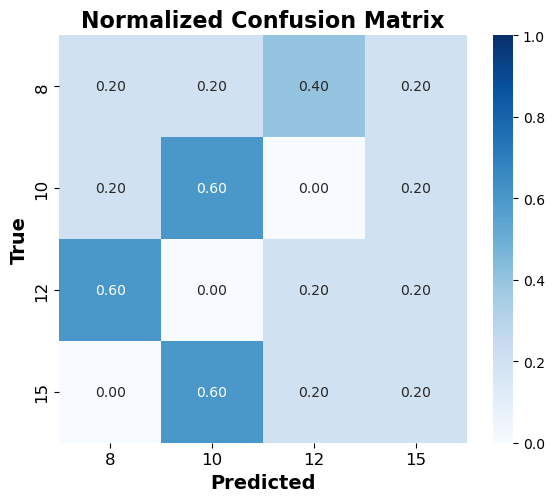

Test set Accuracy: 0.3000
Recall: 0.3000
F1 Score: 0.2861
Confusion Matrix:
[[1 1 2 1]
 [1 3 0 1]
 [3 0 1 1]
 [0 3 1 1]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


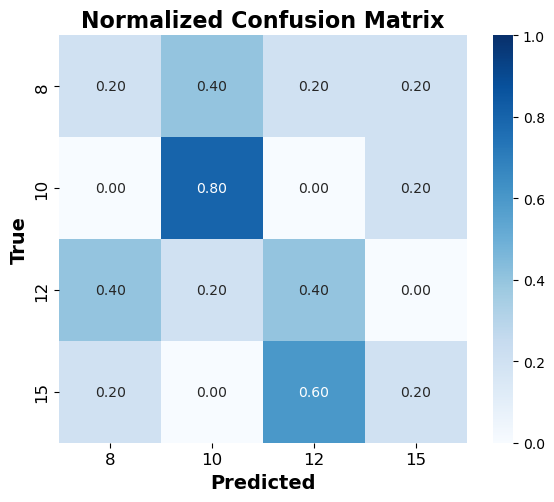

Test set Accuracy: 0.4000
Recall: 0.4000
F1 Score: 0.3756
Confusion Matrix:
[[1 2 1 1]
 [0 4 0 1]
 [2 1 2 0]
 [1 0 3 1]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


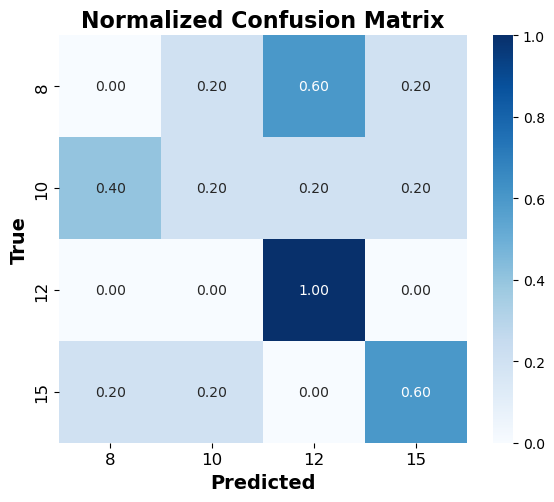

Test set Accuracy: 0.4500
Recall: 0.4500
F1 Score: 0.3911
Confusion Matrix:
[[0 1 3 1]
 [2 1 1 1]
 [0 0 5 0]
 [1 1 0 3]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


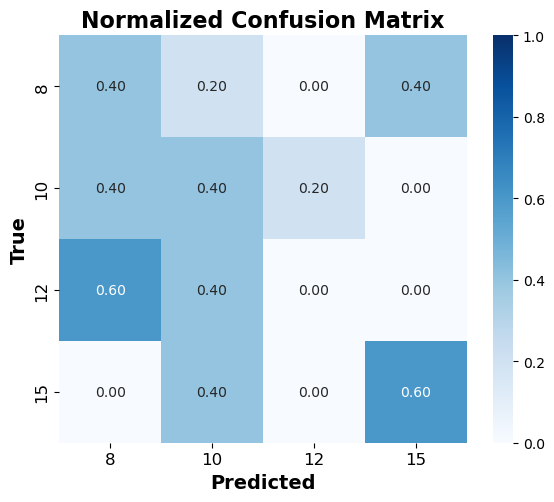

Test set Accuracy: 0.3500
Recall: 0.3500
F1 Score: 0.3167
Confusion Matrix:
[[2 1 0 2]
 [2 2 1 0]
 [3 2 0 0]
 [0 2 0 3]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


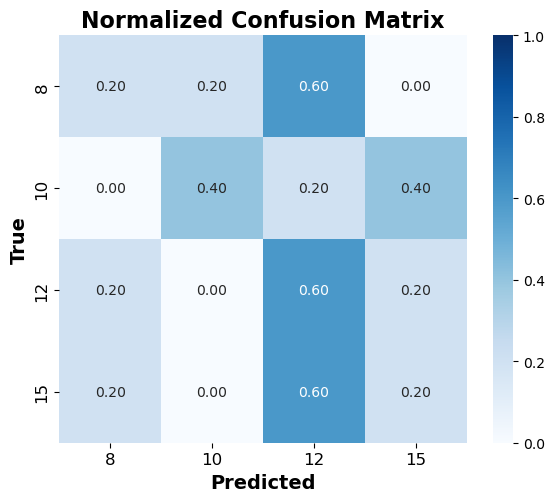

Test set Accuracy: 0.3500
Recall: 0.3500
F1 Score: 0.3431
Confusion Matrix:
[[1 1 3 0]
 [0 2 1 2]
 [1 0 3 1]
 [1 0 3 1]]
Running for subject S12 ---------------


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


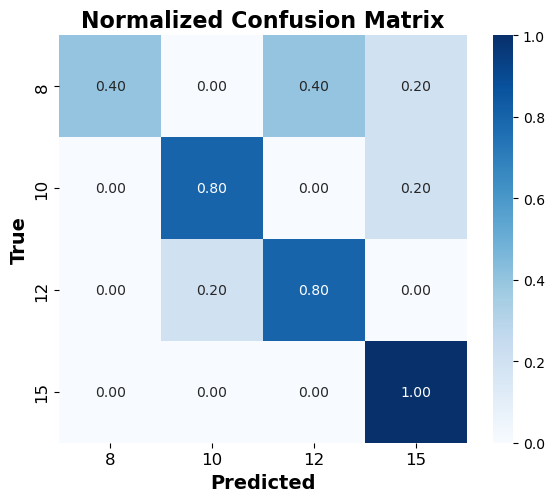

Test set Accuracy: 0.7500
Recall: 0.7500
F1 Score: 0.7330
Confusion Matrix:
[[2 0 2 1]
 [0 4 0 1]
 [0 1 4 0]
 [0 0 0 5]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


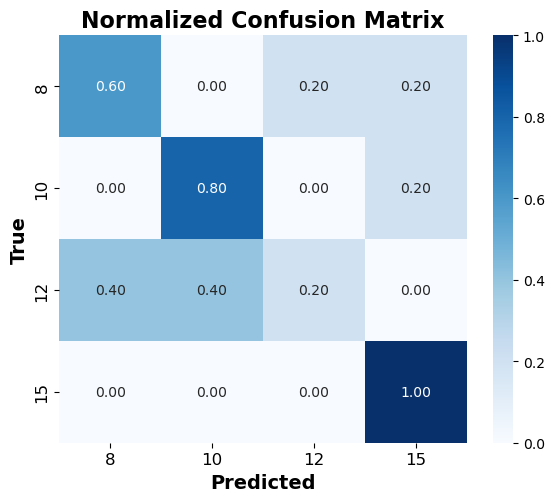

Test set Accuracy: 0.6500
Recall: 0.6500
F1 Score: 0.6116
Confusion Matrix:
[[3 0 1 1]
 [0 4 0 1]
 [2 2 1 0]
 [0 0 0 5]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


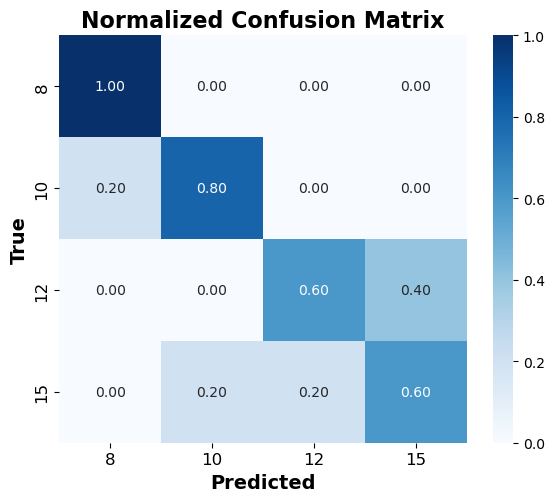

Test set Accuracy: 0.7500
Recall: 0.7500
F1 Score: 0.7439
Confusion Matrix:
[[5 0 0 0]
 [1 4 0 0]
 [0 0 3 2]
 [0 1 1 3]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


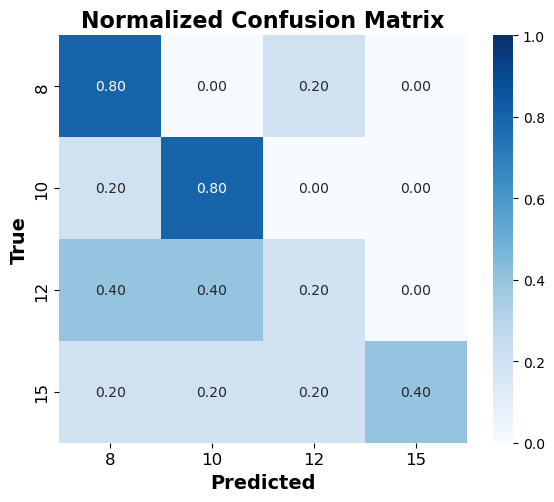

Test set Accuracy: 0.5500
Recall: 0.5500
F1 Score: 0.5259
Confusion Matrix:
[[4 0 1 0]
 [1 4 0 0]
 [2 2 1 0]
 [1 1 1 2]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


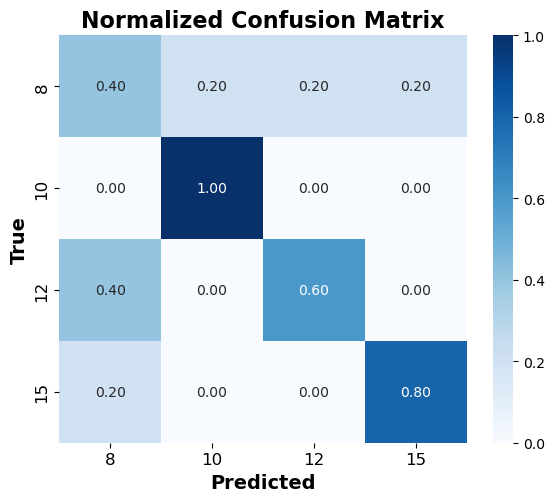

Test set Accuracy: 0.7000
Recall: 0.7000
F1 Score: 0.6939
Confusion Matrix:
[[2 1 1 1]
 [0 5 0 0]
 [2 0 3 0]
 [1 0 0 4]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


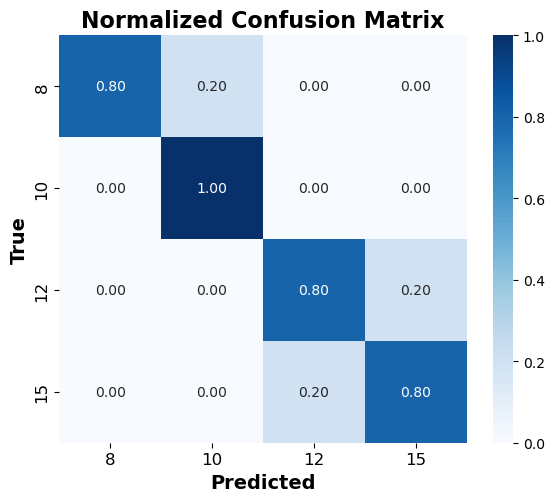

Test set Accuracy: 0.8500
Recall: 0.8500
F1 Score: 0.8495
Confusion Matrix:
[[4 1 0 0]
 [0 5 0 0]
 [0 0 4 1]
 [0 0 1 4]]
Running for subject S13 ---------------


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


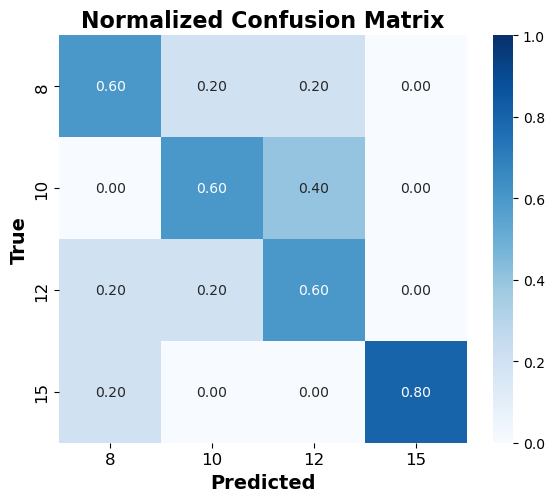

Test set Accuracy: 0.6500
Recall: 0.6500
F1 Score: 0.6586
Confusion Matrix:
[[3 1 1 0]
 [0 3 2 0]
 [1 1 3 0]
 [1 0 0 4]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


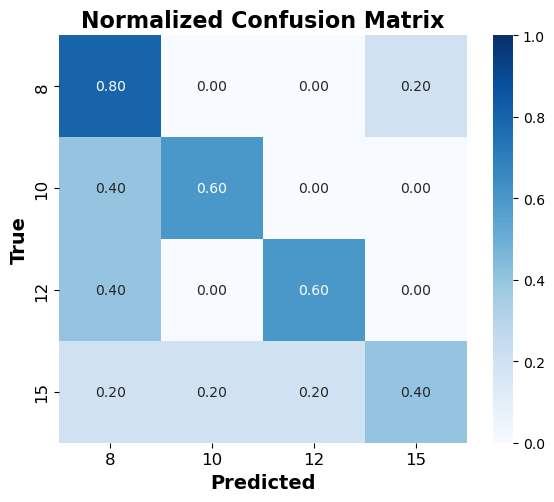

Test set Accuracy: 0.6000
Recall: 0.6000
F1 Score: 0.6012
Confusion Matrix:
[[4 0 0 1]
 [2 3 0 0]
 [2 0 3 0]
 [1 1 1 2]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


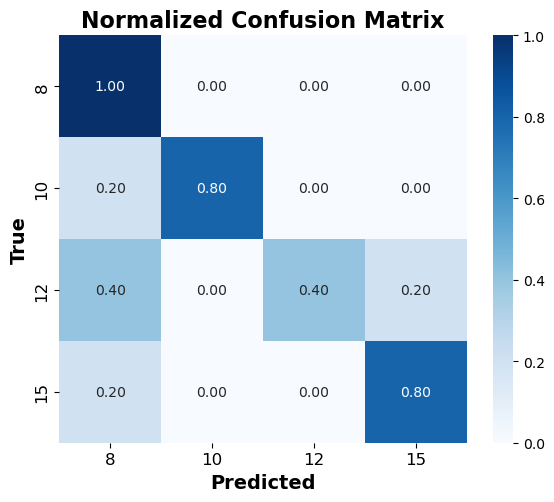

Test set Accuracy: 0.7500
Recall: 0.7500
F1 Score: 0.7437
Confusion Matrix:
[[5 0 0 0]
 [1 4 0 0]
 [2 0 2 1]
 [1 0 0 4]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


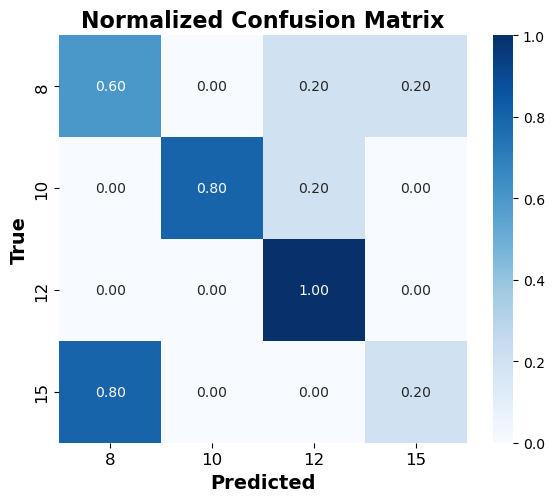

Test set Accuracy: 0.6500
Recall: 0.6500
F1 Score: 0.6270
Confusion Matrix:
[[3 0 1 1]
 [0 4 1 0]
 [0 0 5 0]
 [4 0 0 1]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


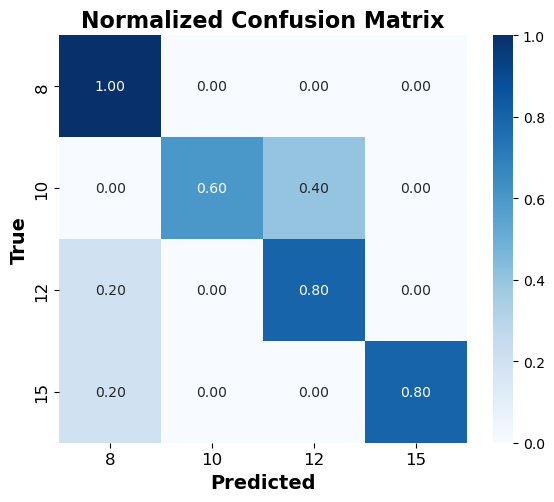

Test set Accuracy: 0.8000
Recall: 0.8000
F1 Score: 0.7999
Confusion Matrix:
[[5 0 0 0]
 [0 3 2 0]
 [1 0 4 0]
 [1 0 0 4]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


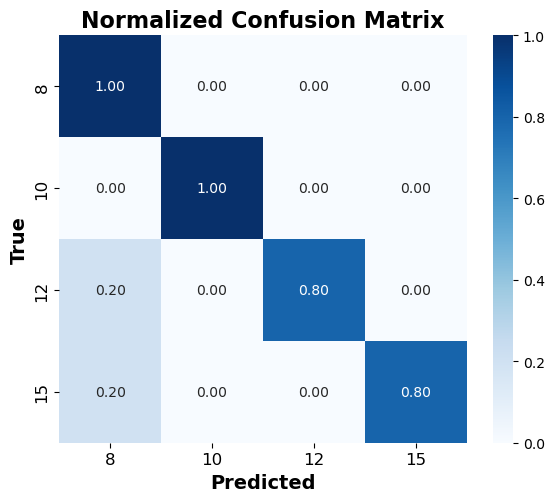

Test set Accuracy: 0.9000
Recall: 0.9000
F1 Score: 0.9028
Confusion Matrix:
[[5 0 0 0]
 [0 5 0 0]
 [1 0 4 0]
 [1 0 0 4]]
Running for subject S14 ---------------


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


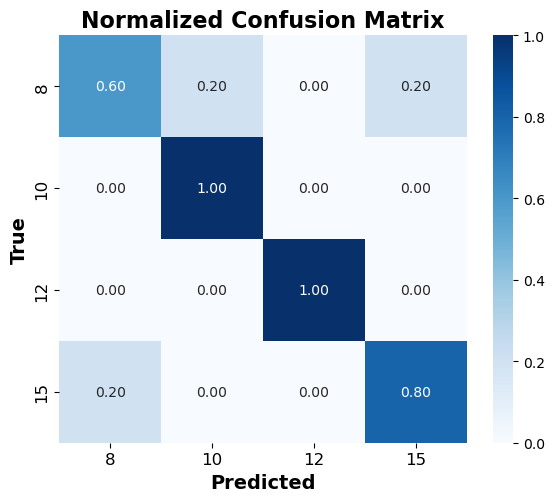

Test set Accuracy: 0.8500
Recall: 0.8500
F1 Score: 0.8439
Confusion Matrix:
[[3 1 0 1]
 [0 5 0 0]
 [0 0 5 0]
 [1 0 0 4]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


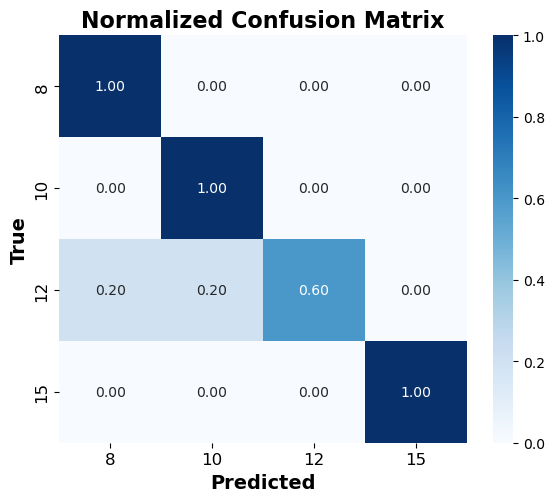

Test set Accuracy: 0.9000
Recall: 0.9000
F1 Score: 0.8920
Confusion Matrix:
[[5 0 0 0]
 [0 5 0 0]
 [1 1 3 0]
 [0 0 0 5]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


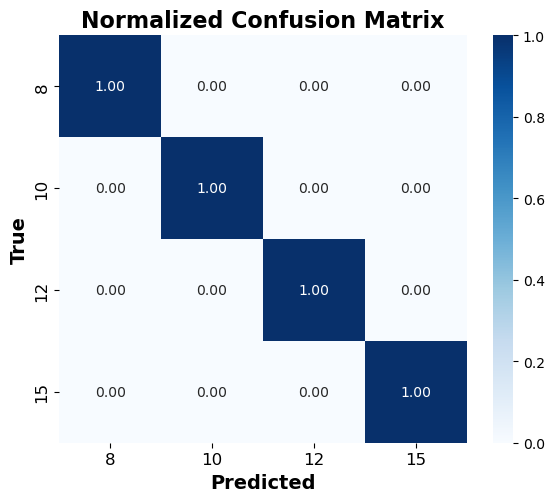

Test set Accuracy: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Confusion Matrix:
[[5 0 0 0]
 [0 5 0 0]
 [0 0 5 0]
 [0 0 0 5]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


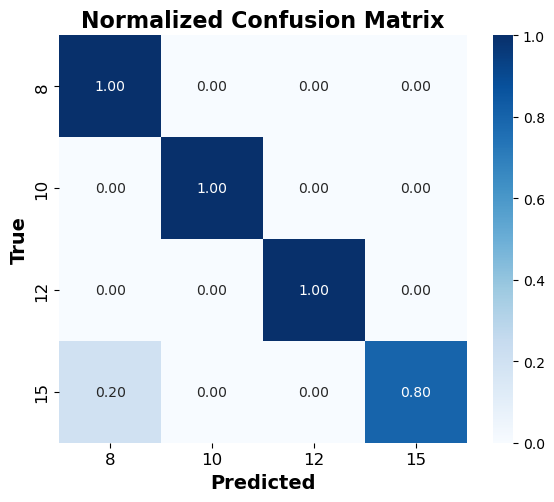

Test set Accuracy: 0.9500
Recall: 0.9500
F1 Score: 0.9495
Confusion Matrix:
[[5 0 0 0]
 [0 5 0 0]
 [0 0 5 0]
 [1 0 0 4]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


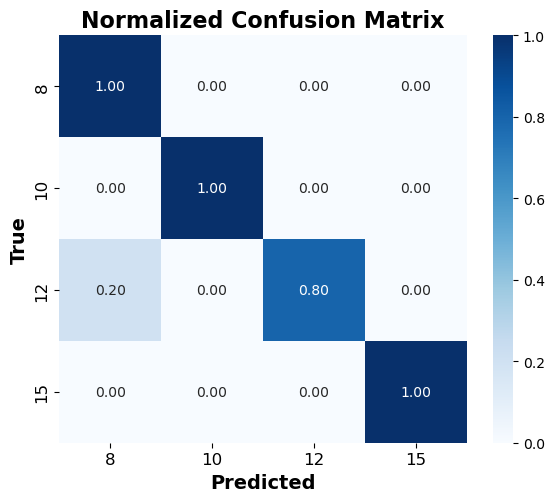

Test set Accuracy: 0.9500
Recall: 0.9500
F1 Score: 0.9495
Confusion Matrix:
[[5 0 0 0]
 [0 5 0 0]
 [1 0 4 0]
 [0 0 0 5]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


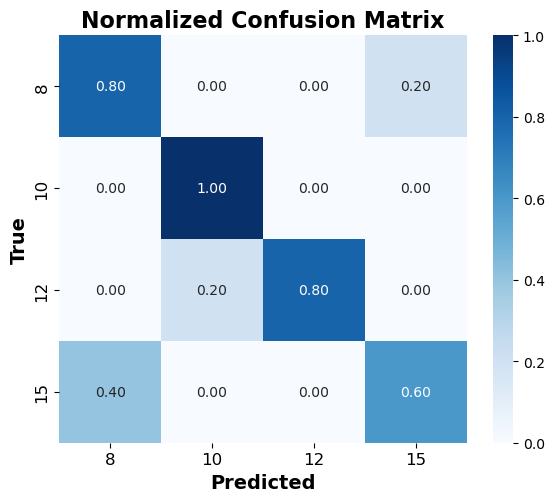

Test set Accuracy: 0.8000
Recall: 0.8000
F1 Score: 0.7980
Confusion Matrix:
[[4 0 0 1]
 [0 5 0 0]
 [0 1 4 0]
 [2 0 0 3]]
Running for subject S15 ---------------


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


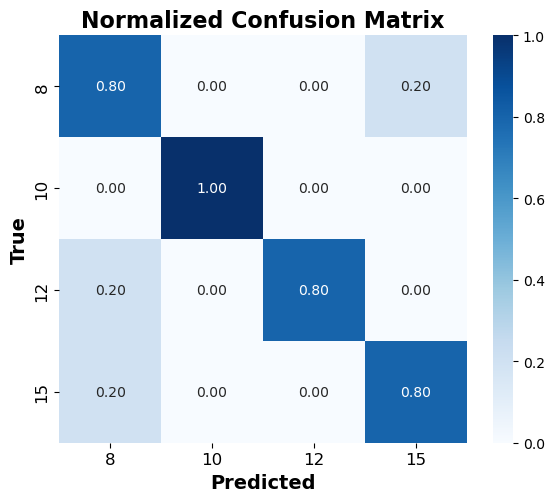

Test set Accuracy: 0.8500
Recall: 0.8500
F1 Score: 0.8540
Confusion Matrix:
[[4 0 0 1]
 [0 5 0 0]
 [1 0 4 0]
 [1 0 0 4]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


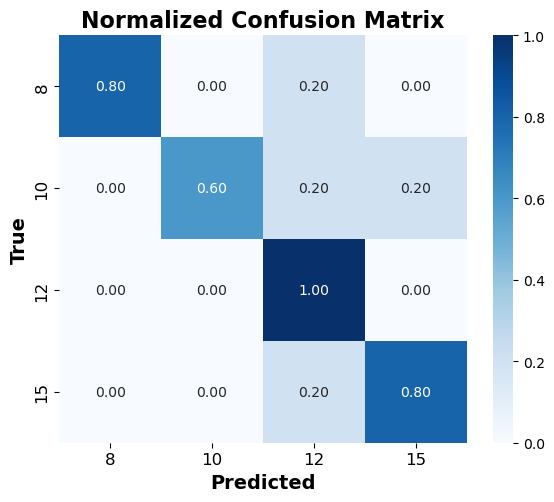

Test set Accuracy: 0.8000
Recall: 0.8000
F1 Score: 0.8020
Confusion Matrix:
[[4 0 1 0]
 [0 3 1 1]
 [0 0 5 0]
 [0 0 1 4]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


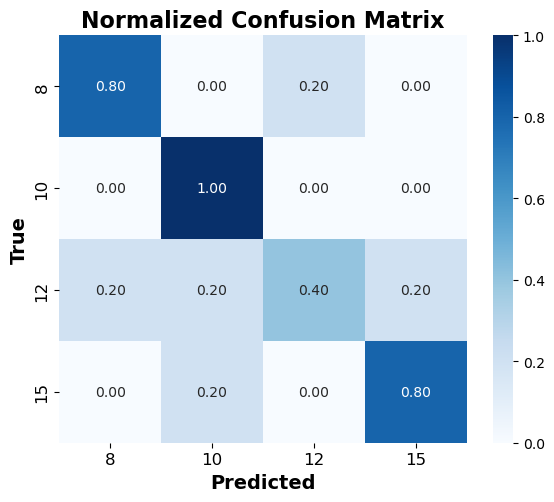

Test set Accuracy: 0.7500
Recall: 0.7500
F1 Score: 0.7333
Confusion Matrix:
[[4 0 1 0]
 [0 5 0 0]
 [1 1 2 1]
 [0 1 0 4]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


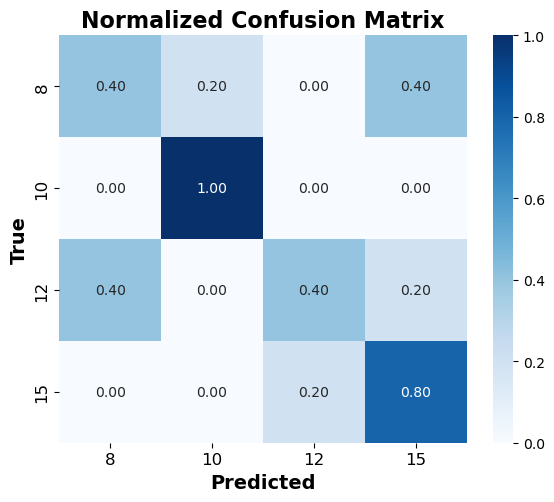

Test set Accuracy: 0.6500
Recall: 0.6500
F1 Score: 0.6301
Confusion Matrix:
[[2 1 0 2]
 [0 5 0 0]
 [2 0 2 1]
 [0 0 1 4]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


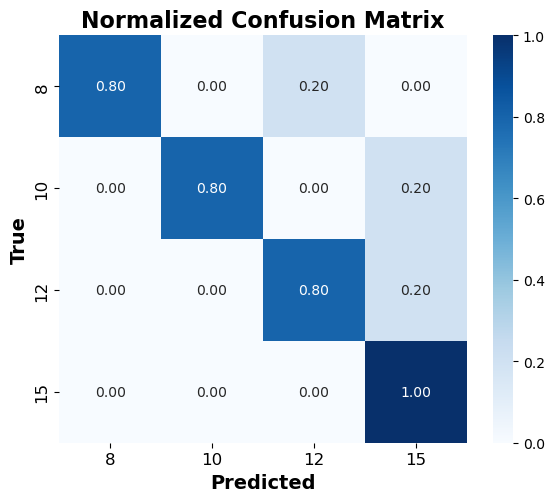

Test set Accuracy: 0.8500
Recall: 0.8500
F1 Score: 0.8528
Confusion Matrix:
[[4 0 1 0]
 [0 4 0 1]
 [0 0 4 1]
 [0 0 0 5]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


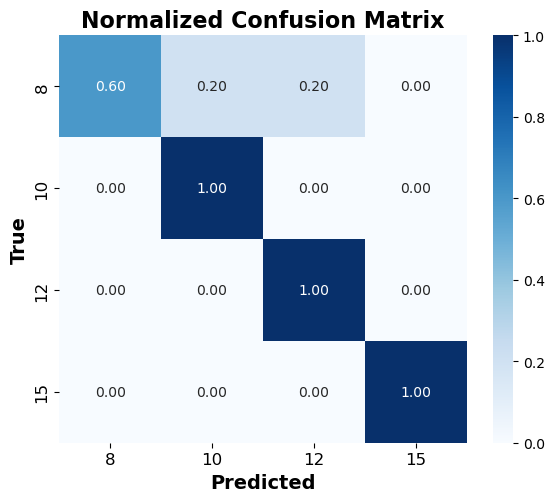

Test set Accuracy: 0.9000
Recall: 0.9000
F1 Score: 0.8920
Confusion Matrix:
[[3 1 1 0]
 [0 5 0 0]
 [0 0 5 0]
 [0 0 0 5]]
Running for subject S16 ---------------


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


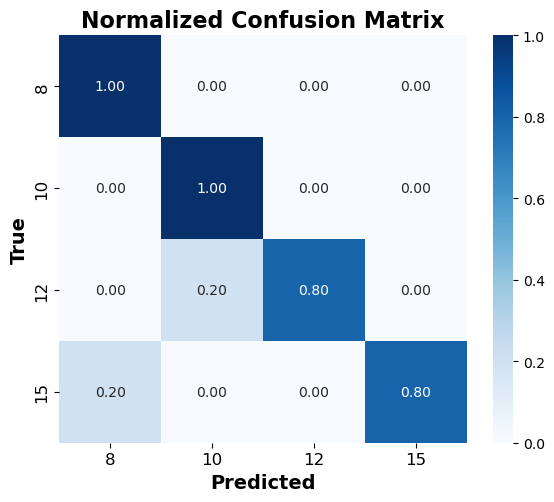

Test set Accuracy: 0.9000
Recall: 0.9000
F1 Score: 0.8990
Confusion Matrix:
[[5 0 0 0]
 [0 5 0 0]
 [0 1 4 0]
 [1 0 0 4]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


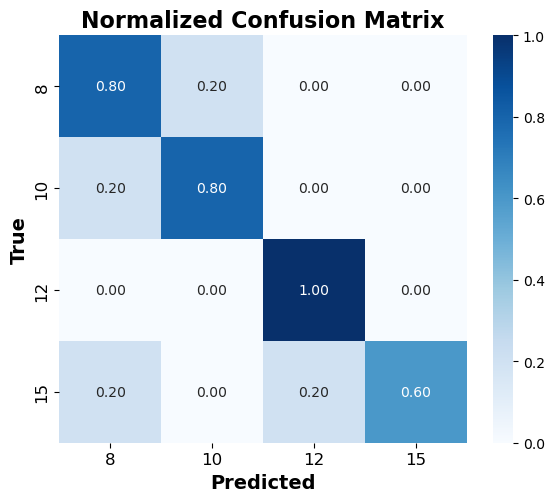

Test set Accuracy: 0.8000
Recall: 0.8000
F1 Score: 0.7966
Confusion Matrix:
[[4 1 0 0]
 [1 4 0 0]
 [0 0 5 0]
 [1 0 1 3]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


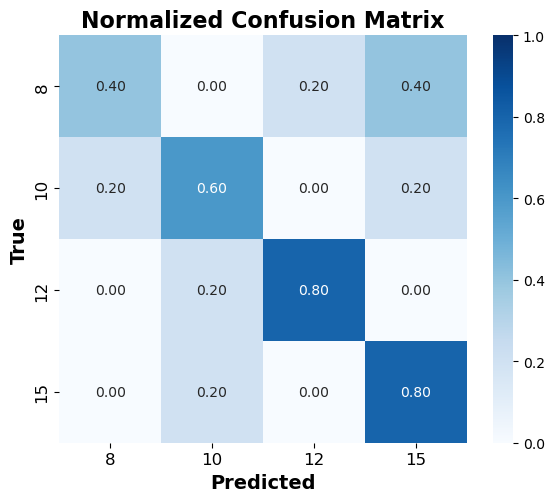

Test set Accuracy: 0.6500
Recall: 0.6500
F1 Score: 0.6417
Confusion Matrix:
[[2 0 1 2]
 [1 3 0 1]
 [0 1 4 0]
 [0 1 0 4]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


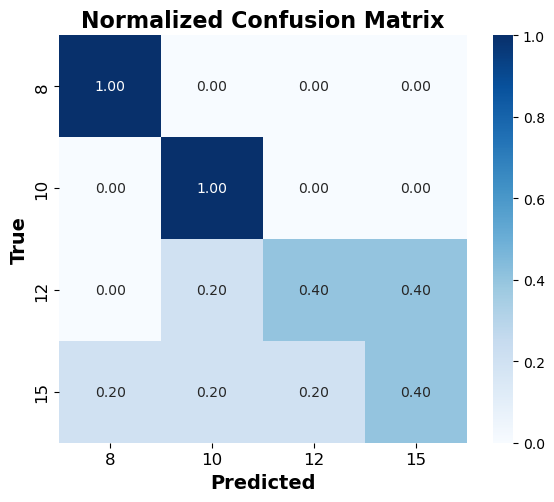

Test set Accuracy: 0.7000
Recall: 0.7000
F1 Score: 0.6717
Confusion Matrix:
[[5 0 0 0]
 [0 5 0 0]
 [0 1 2 2]
 [1 1 1 2]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


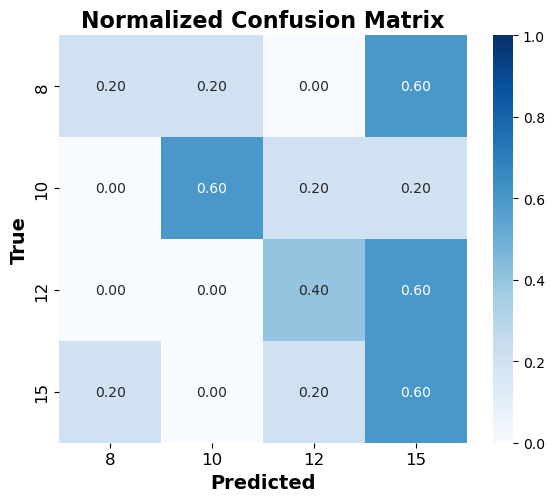

Test set Accuracy: 0.4500
Recall: 0.4500
F1 Score: 0.4492
Confusion Matrix:
[[1 1 0 3]
 [0 3 1 1]
 [0 0 2 3]
 [1 0 1 3]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


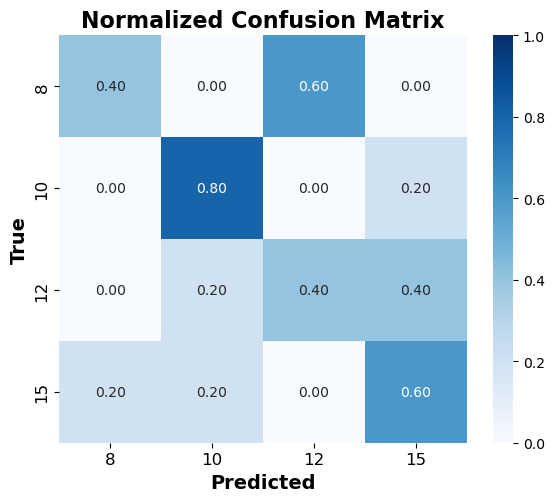

Test set Accuracy: 0.5500
Recall: 0.5500
F1 Score: 0.5432
Confusion Matrix:
[[2 0 3 0]
 [0 4 0 1]
 [0 1 2 2]
 [1 1 0 3]]
Running for subject S17 ---------------


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


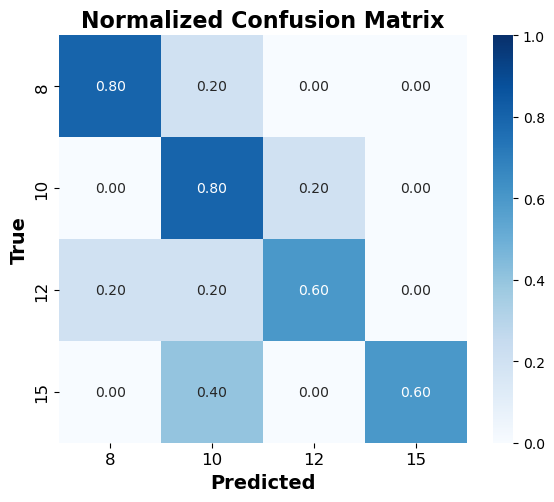

Test set Accuracy: 0.7000
Recall: 0.7000
F1 Score: 0.7080
Confusion Matrix:
[[4 1 0 0]
 [0 4 1 0]
 [1 1 3 0]
 [0 2 0 3]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


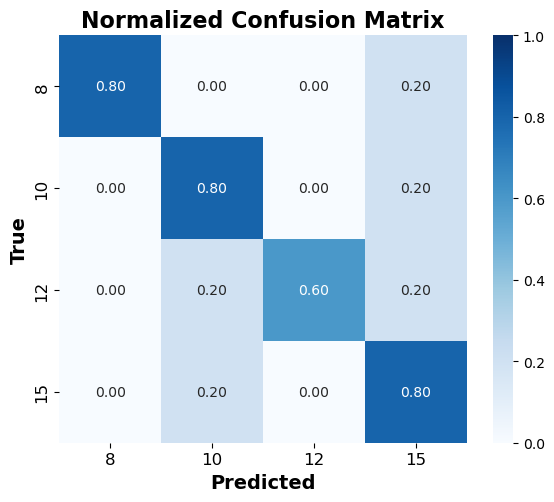

Test set Accuracy: 0.7500
Recall: 0.7500
F1 Score: 0.7582
Confusion Matrix:
[[4 0 0 1]
 [0 4 0 1]
 [0 1 3 1]
 [0 1 0 4]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


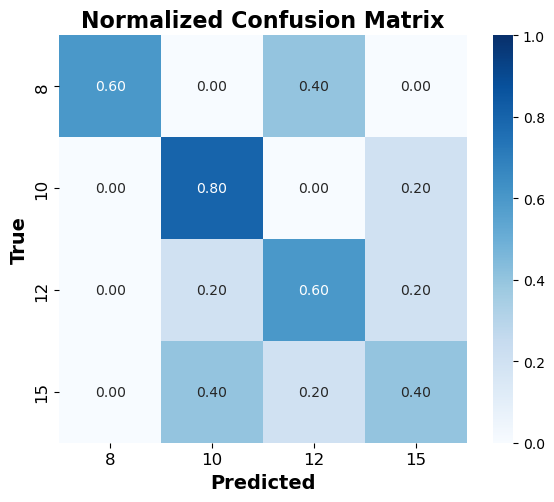

Test set Accuracy: 0.6000
Recall: 0.6000
F1 Score: 0.6016
Confusion Matrix:
[[3 0 2 0]
 [0 4 0 1]
 [0 1 3 1]
 [0 2 1 2]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


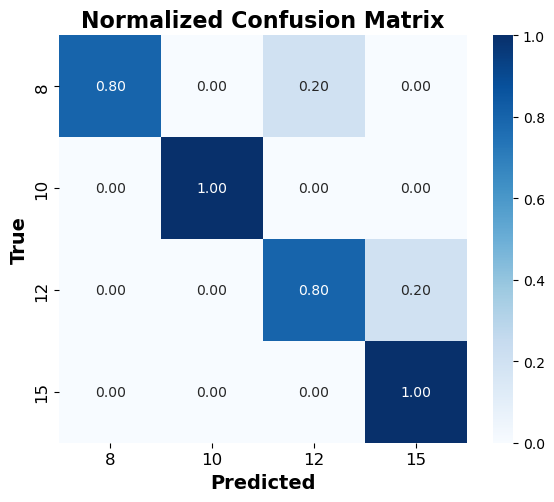

Test set Accuracy: 0.9000
Recall: 0.9000
F1 Score: 0.8995
Confusion Matrix:
[[4 0 1 0]
 [0 5 0 0]
 [0 0 4 1]
 [0 0 0 5]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


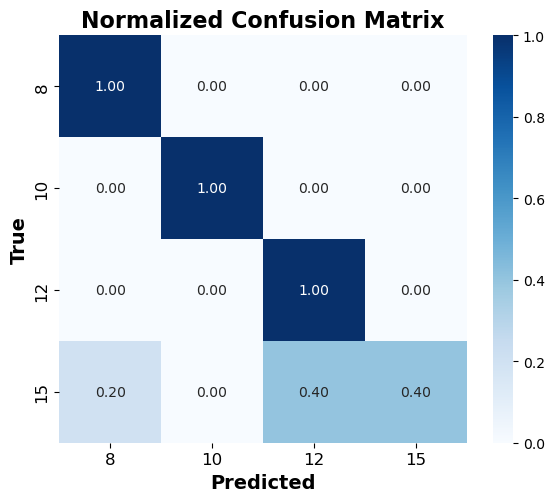

Test set Accuracy: 0.8500
Recall: 0.8500
F1 Score: 0.8285
Confusion Matrix:
[[5 0 0 0]
 [0 5 0 0]
 [0 0 5 0]
 [1 0 2 2]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


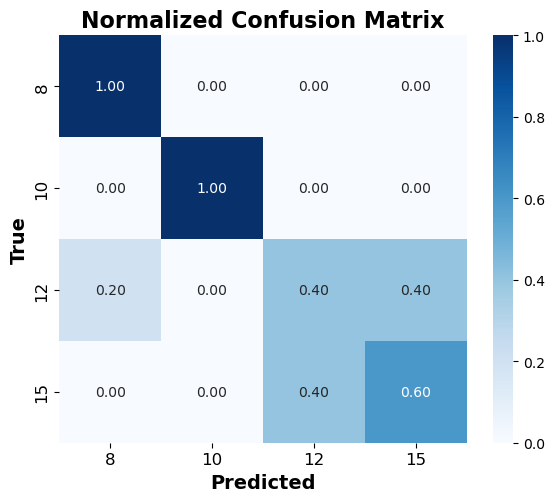

Test set Accuracy: 0.7500
Recall: 0.7500
F1 Score: 0.7384
Confusion Matrix:
[[5 0 0 0]
 [0 5 0 0]
 [1 0 2 2]
 [0 0 2 3]]
Running for subject S18 ---------------


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


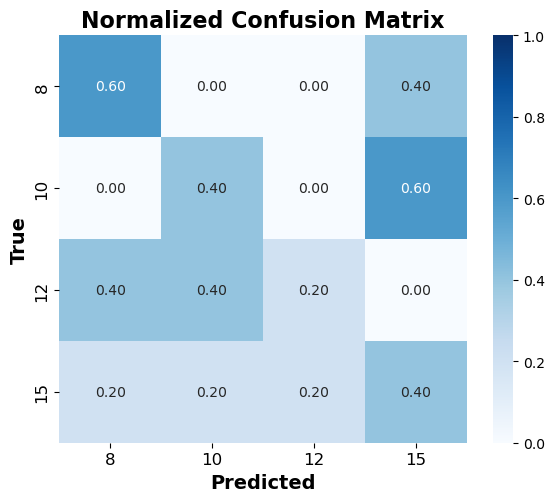

Test set Accuracy: 0.4000
Recall: 0.4000
F1 Score: 0.3911
Confusion Matrix:
[[3 0 0 2]
 [0 2 0 3]
 [2 2 1 0]
 [1 1 1 2]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


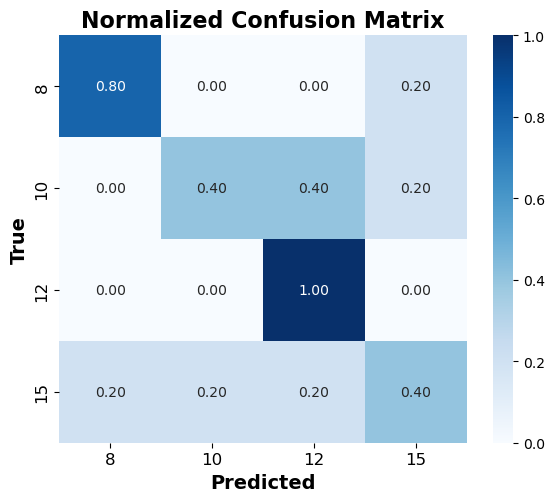

Test set Accuracy: 0.6500
Recall: 0.6500
F1 Score: 0.6284
Confusion Matrix:
[[4 0 0 1]
 [0 2 2 1]
 [0 0 5 0]
 [1 1 1 2]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


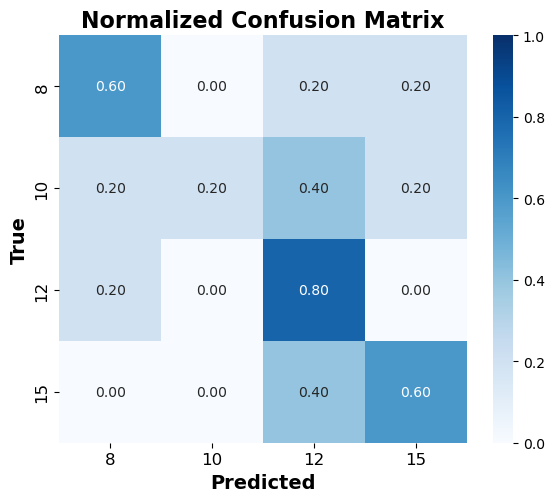

Test set Accuracy: 0.5500
Recall: 0.5500
F1 Score: 0.5262
Confusion Matrix:
[[3 0 1 1]
 [1 1 2 1]
 [1 0 4 0]
 [0 0 2 3]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


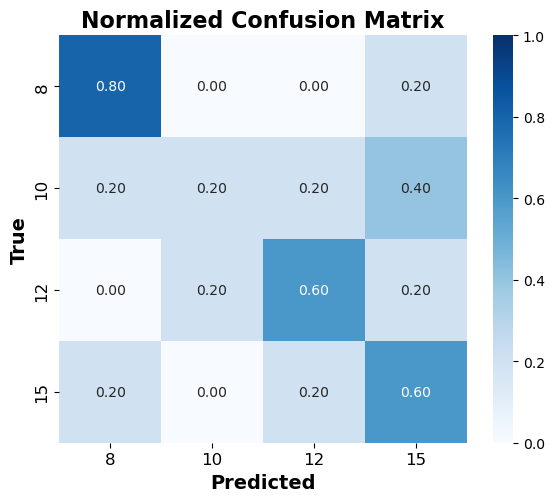

Test set Accuracy: 0.5500
Recall: 0.5500
F1 Score: 0.5282
Confusion Matrix:
[[4 0 0 1]
 [1 1 1 2]
 [0 1 3 1]
 [1 0 1 3]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


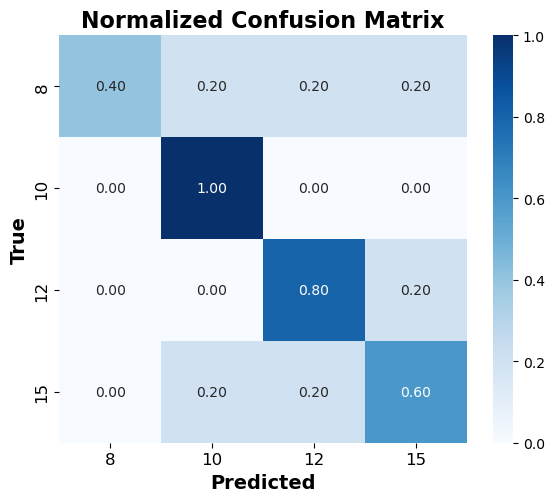

Test set Accuracy: 0.7000
Recall: 0.7000
F1 Score: 0.6830
Confusion Matrix:
[[2 1 1 1]
 [0 5 0 0]
 [0 0 4 1]
 [0 1 1 3]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


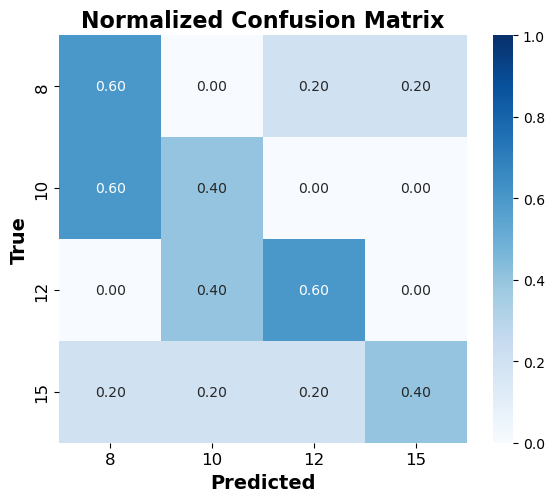

Test set Accuracy: 0.5000
Recall: 0.5000
F1 Score: 0.5000
Confusion Matrix:
[[3 0 1 1]
 [3 2 0 0]
 [0 2 3 0]
 [1 1 1 2]]
Running for subject S19 ---------------


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


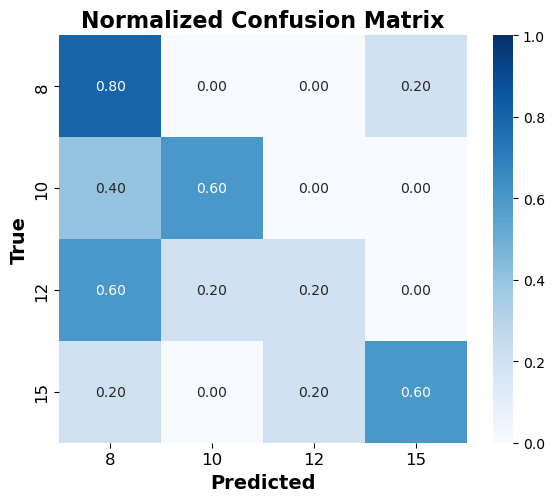

Test set Accuracy: 0.5500
Recall: 0.5500
F1 Score: 0.5381
Confusion Matrix:
[[4 0 0 1]
 [2 3 0 0]
 [3 1 1 0]
 [1 0 1 3]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


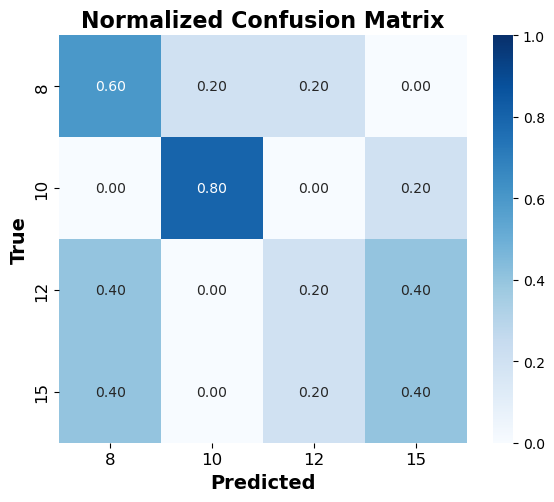

Test set Accuracy: 0.5000
Recall: 0.5000
F1 Score: 0.4875
Confusion Matrix:
[[3 1 1 0]
 [0 4 0 1]
 [2 0 1 2]
 [2 0 1 2]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


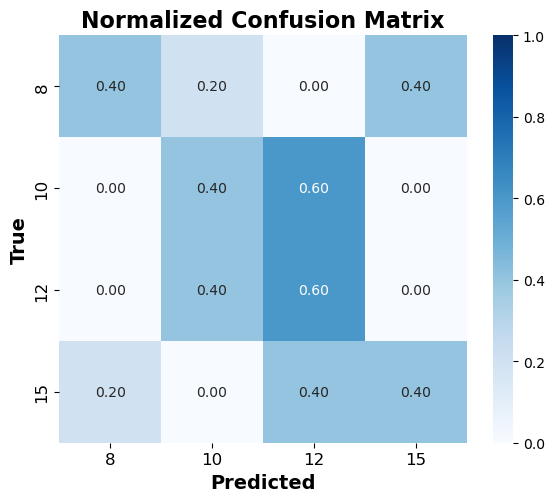

Test set Accuracy: 0.4500
Recall: 0.4500
F1 Score: 0.4515
Confusion Matrix:
[[2 1 0 2]
 [0 2 3 0]
 [0 2 3 0]
 [1 0 2 2]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


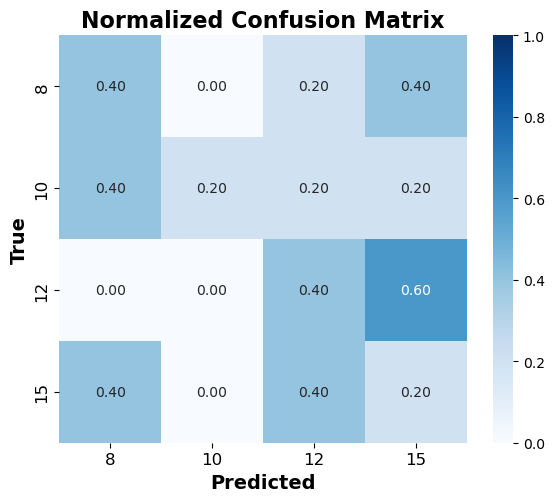

Test set Accuracy: 0.3000
Recall: 0.3000
F1 Score: 0.3068
Confusion Matrix:
[[2 0 1 2]
 [2 1 1 1]
 [0 0 2 3]
 [2 0 2 1]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


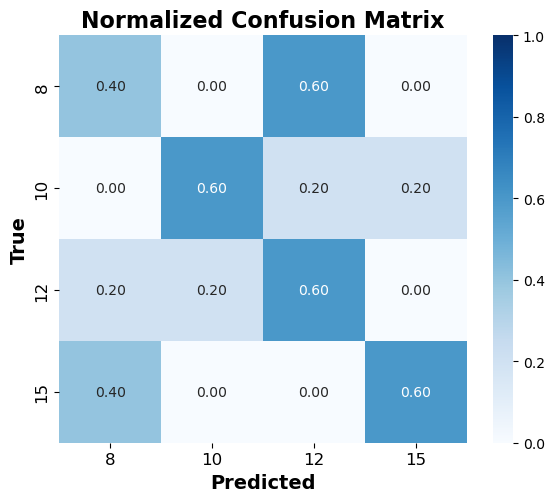

Test set Accuracy: 0.5500
Recall: 0.5500
F1 Score: 0.5583
Confusion Matrix:
[[2 0 3 0]
 [0 3 1 1]
 [1 1 3 0]
 [2 0 0 3]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


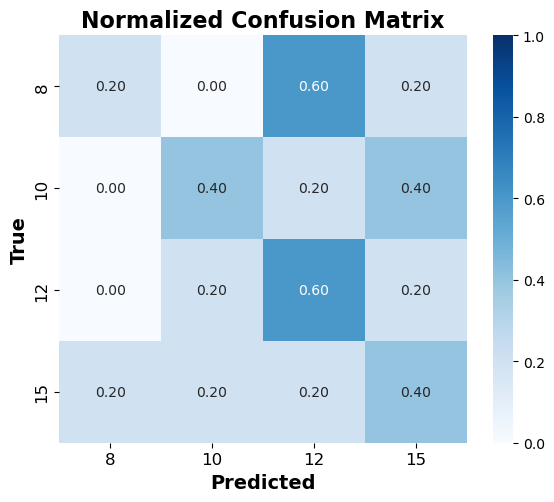

Test set Accuracy: 0.4000
Recall: 0.4000
F1 Score: 0.3888
Confusion Matrix:
[[1 0 3 1]
 [0 2 1 2]
 [0 1 3 1]
 [1 1 1 2]]
Running for subject S20 ---------------


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


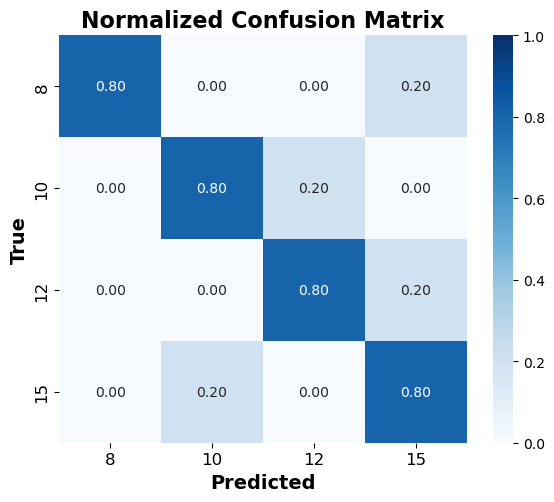

Test set Accuracy: 0.8000
Recall: 0.8000
F1 Score: 0.8040
Confusion Matrix:
[[4 0 0 1]
 [0 4 1 0]
 [0 0 4 1]
 [0 1 0 4]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


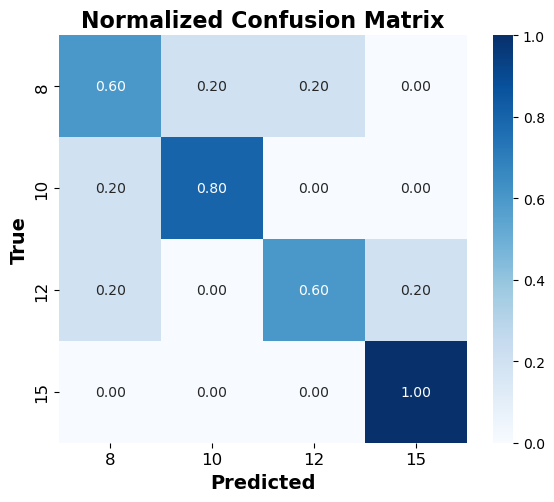

Test set Accuracy: 0.7500
Recall: 0.7500
F1 Score: 0.7439
Confusion Matrix:
[[3 1 1 0]
 [1 4 0 0]
 [1 0 3 1]
 [0 0 0 5]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


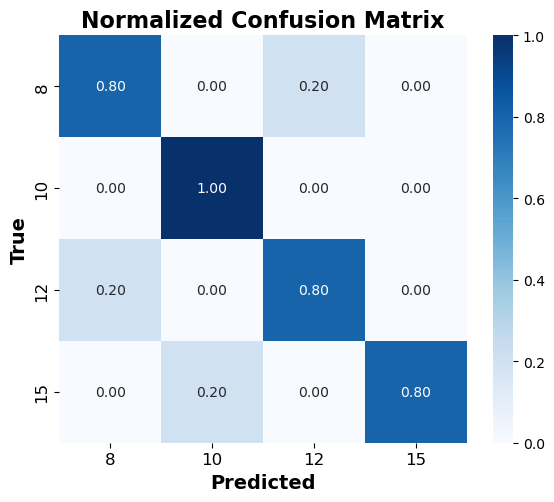

Test set Accuracy: 0.8500
Recall: 0.8500
F1 Score: 0.8495
Confusion Matrix:
[[4 0 1 0]
 [0 5 0 0]
 [1 0 4 0]
 [0 1 0 4]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


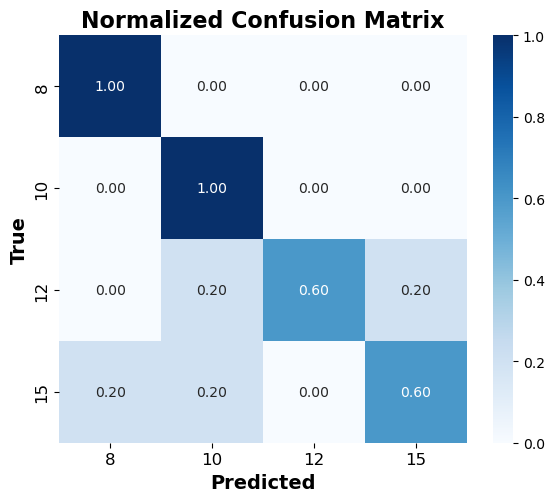

Test set Accuracy: 0.8000
Recall: 0.8000
F1 Score: 0.7898
Confusion Matrix:
[[5 0 0 0]
 [0 5 0 0]
 [0 1 3 1]
 [1 1 0 3]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


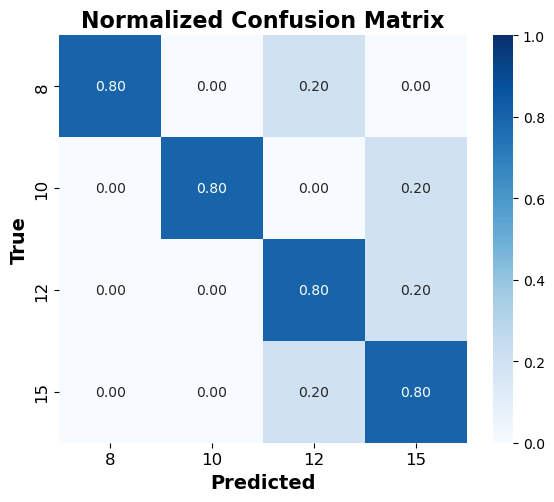

Test set Accuracy: 0.8000
Recall: 0.8000
F1 Score: 0.8081
Confusion Matrix:
[[4 0 1 0]
 [0 4 0 1]
 [0 0 4 1]
 [0 0 1 4]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


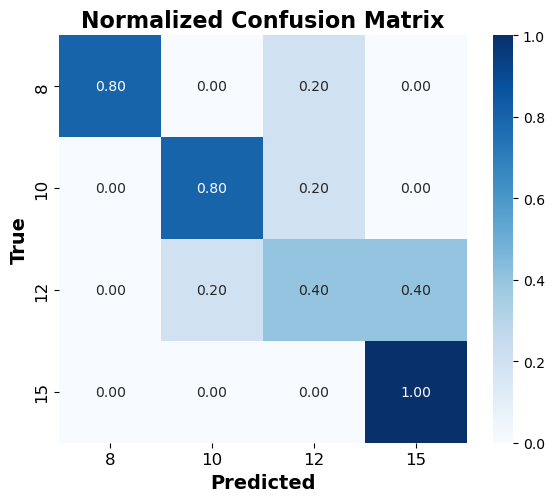

Test set Accuracy: 0.7500
Recall: 0.7500
F1 Score: 0.7417
Confusion Matrix:
[[4 0 1 0]
 [0 4 1 0]
 [0 1 2 2]
 [0 0 0 5]]
Running for subject S21 ---------------


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


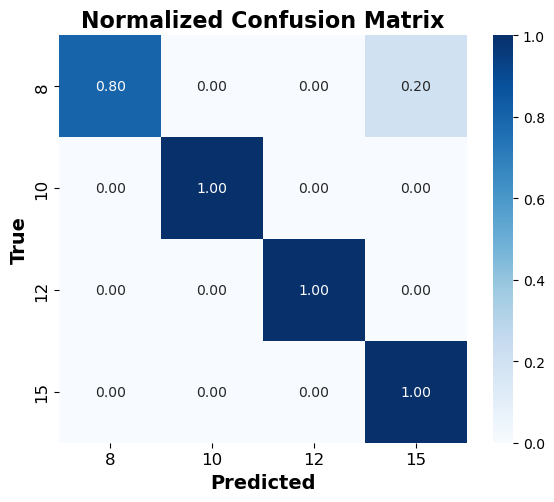

Test set Accuracy: 0.9500
Recall: 0.9500
F1 Score: 0.9495
Confusion Matrix:
[[4 0 0 1]
 [0 5 0 0]
 [0 0 5 0]
 [0 0 0 5]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


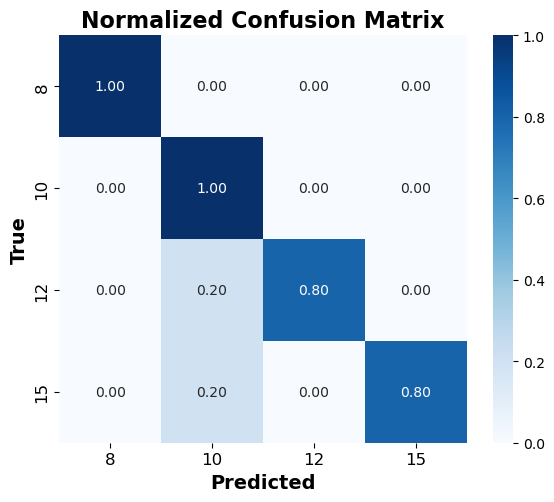

Test set Accuracy: 0.9000
Recall: 0.9000
F1 Score: 0.9028
Confusion Matrix:
[[5 0 0 0]
 [0 5 0 0]
 [0 1 4 0]
 [0 1 0 4]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


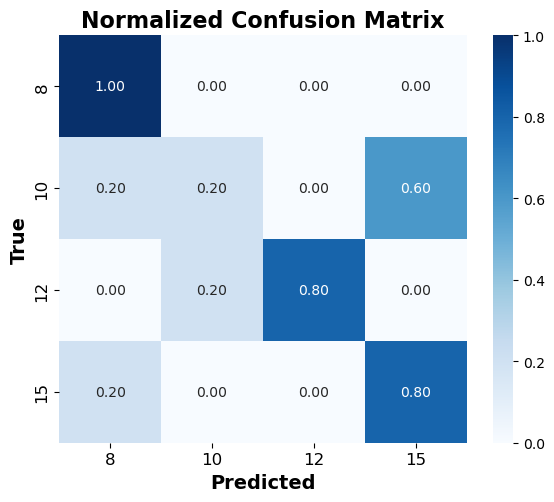

Test set Accuracy: 0.7000
Recall: 0.7000
F1 Score: 0.6687
Confusion Matrix:
[[5 0 0 0]
 [1 1 0 3]
 [0 1 4 0]
 [1 0 0 4]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


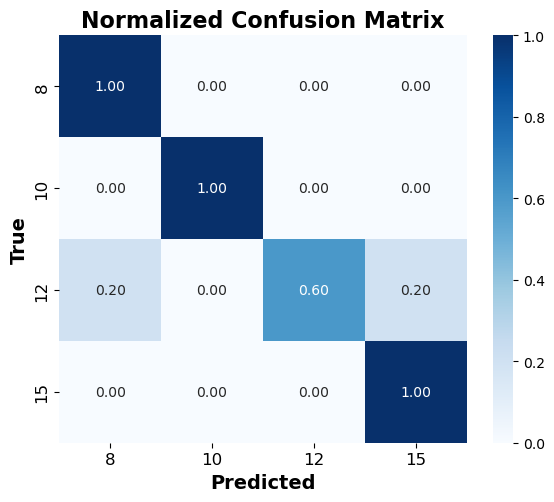

Test set Accuracy: 0.9000
Recall: 0.9000
F1 Score: 0.8920
Confusion Matrix:
[[5 0 0 0]
 [0 5 0 0]
 [1 0 3 1]
 [0 0 0 5]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


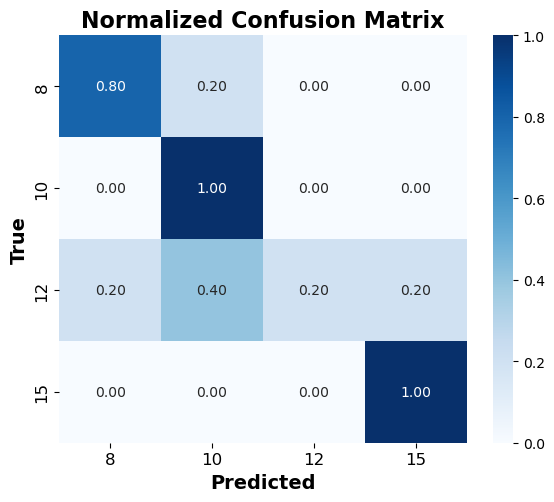

Test set Accuracy: 0.7500
Recall: 0.7500
F1 Score: 0.7029
Confusion Matrix:
[[4 1 0 0]
 [0 5 0 0]
 [1 2 1 1]
 [0 0 0 5]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


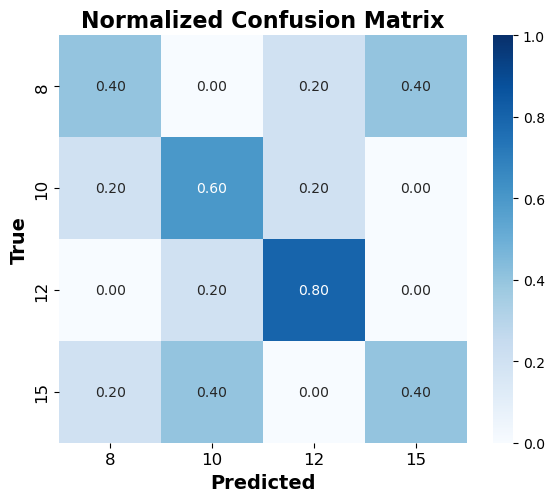

Test set Accuracy: 0.5500
Recall: 0.5500
F1 Score: 0.5404
Confusion Matrix:
[[2 0 1 2]
 [1 3 1 0]
 [0 1 4 0]
 [1 2 0 2]]
Running for subject S22 ---------------


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


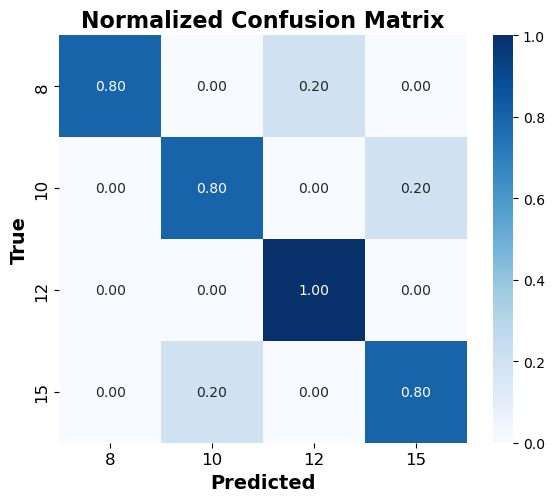

Test set Accuracy: 0.8500
Recall: 0.8500
F1 Score: 0.8495
Confusion Matrix:
[[4 0 1 0]
 [0 4 0 1]
 [0 0 5 0]
 [0 1 0 4]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


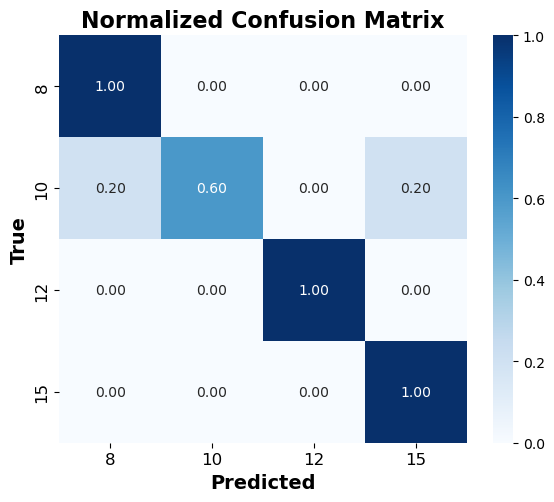

Test set Accuracy: 0.9000
Recall: 0.9000
F1 Score: 0.8920
Confusion Matrix:
[[5 0 0 0]
 [1 3 0 1]
 [0 0 5 0]
 [0 0 0 5]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


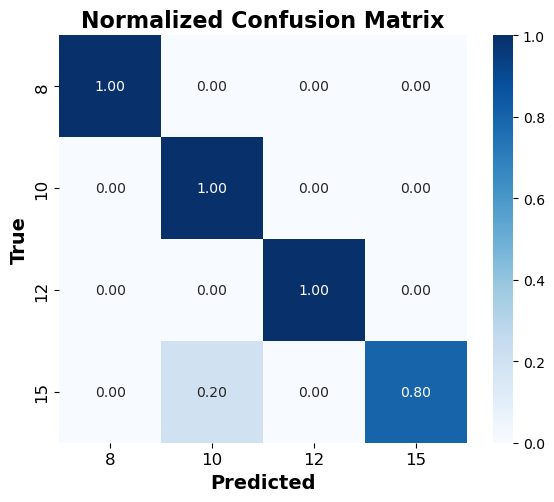

Test set Accuracy: 0.9500
Recall: 0.9500
F1 Score: 0.9495
Confusion Matrix:
[[5 0 0 0]
 [0 5 0 0]
 [0 0 5 0]
 [0 1 0 4]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


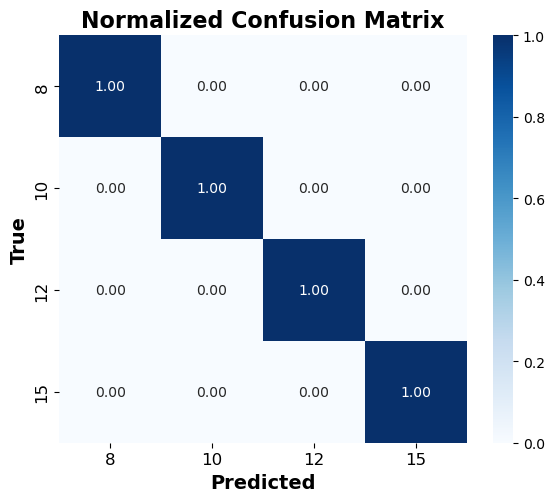

Test set Accuracy: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Confusion Matrix:
[[5 0 0 0]
 [0 5 0 0]
 [0 0 5 0]
 [0 0 0 5]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


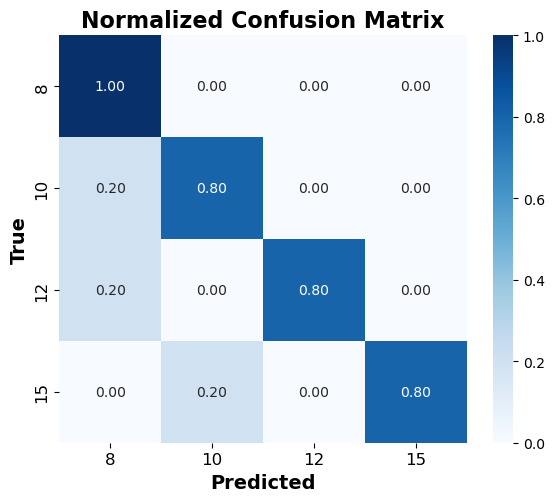

Test set Accuracy: 0.8500
Recall: 0.8500
F1 Score: 0.8528
Confusion Matrix:
[[5 0 0 0]
 [1 4 0 0]
 [1 0 4 0]
 [0 1 0 4]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


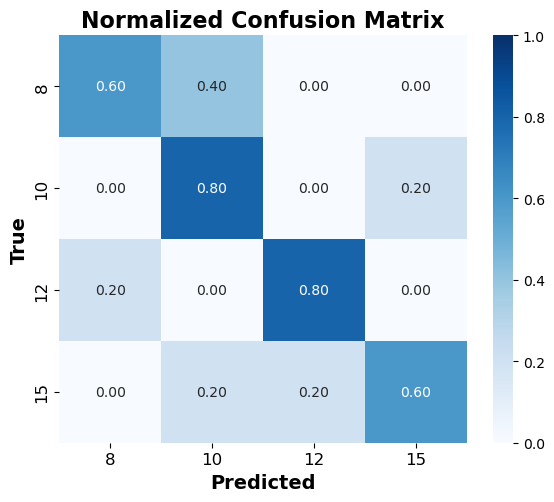

Test set Accuracy: 0.7000
Recall: 0.7000
F1 Score: 0.7000
Confusion Matrix:
[[3 2 0 0]
 [0 4 0 1]
 [1 0 4 0]
 [0 1 1 3]]
Running for subject S23 ---------------


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


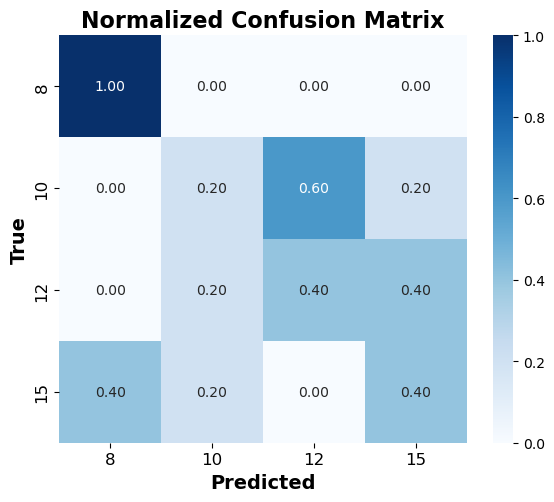

Test set Accuracy: 0.5000
Recall: 0.5000
F1 Score: 0.4708
Confusion Matrix:
[[5 0 0 0]
 [0 1 3 1]
 [0 1 2 2]
 [2 1 0 2]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


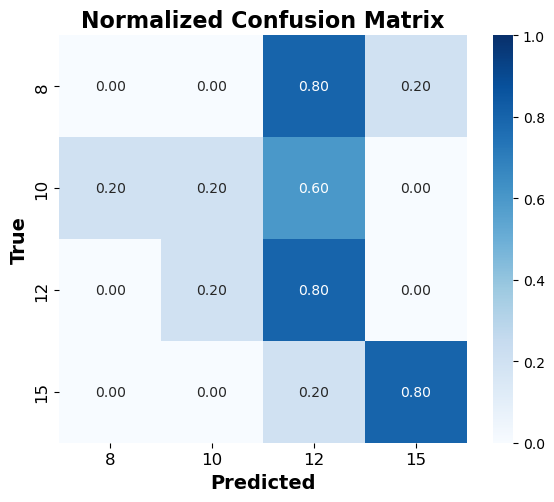

Test set Accuracy: 0.4500
Recall: 0.4500
F1 Score: 0.3891
Confusion Matrix:
[[0 0 4 1]
 [1 1 3 0]
 [0 1 4 0]
 [0 0 1 4]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


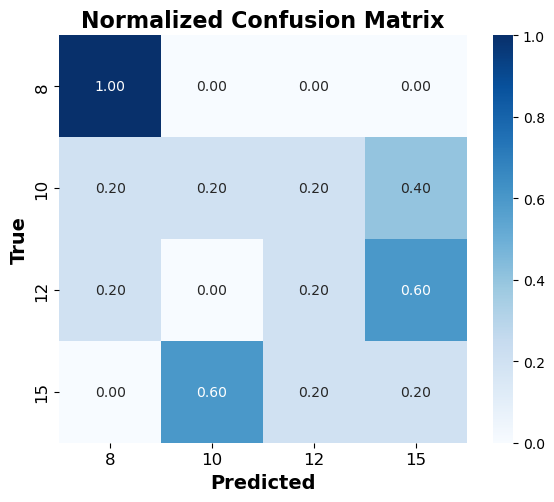

Test set Accuracy: 0.4000
Recall: 0.4000
F1 Score: 0.3718
Confusion Matrix:
[[5 0 0 0]
 [1 1 1 2]
 [1 0 1 3]
 [0 3 1 1]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


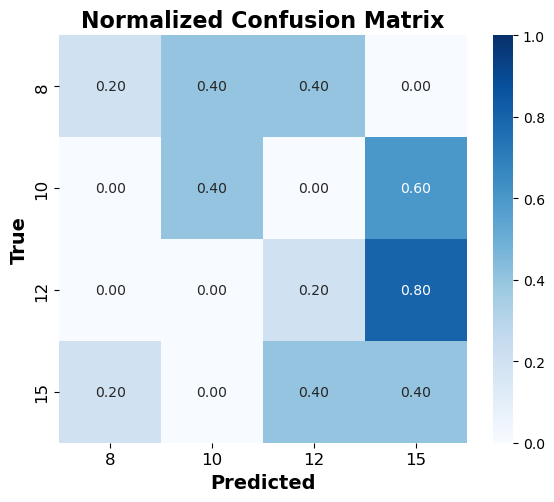

Test set Accuracy: 0.3000
Recall: 0.3000
F1 Score: 0.3040
Confusion Matrix:
[[1 2 2 0]
 [0 2 0 3]
 [0 0 1 4]
 [1 0 2 2]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


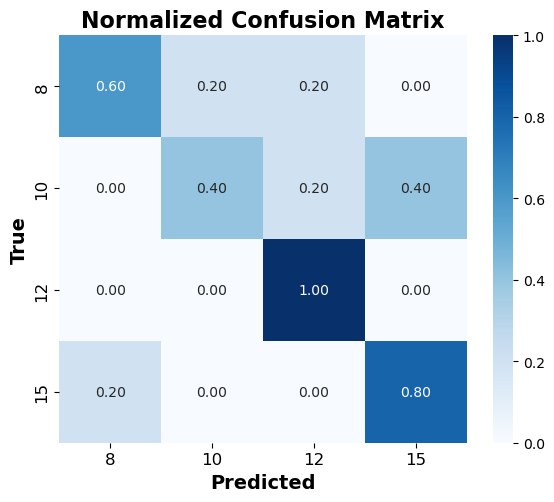

Test set Accuracy: 0.7000
Recall: 0.7000
F1 Score: 0.6818
Confusion Matrix:
[[3 1 1 0]
 [0 2 1 2]
 [0 0 5 0]
 [1 0 0 4]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


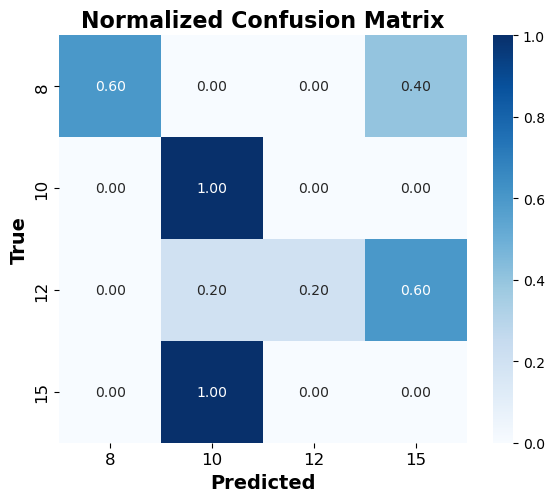

Test set Accuracy: 0.4500
Recall: 0.4500
F1 Score: 0.4271
Confusion Matrix:
[[3 0 0 2]
 [0 5 0 0]
 [0 1 1 3]
 [0 5 0 0]]
Running for subject S24 ---------------


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


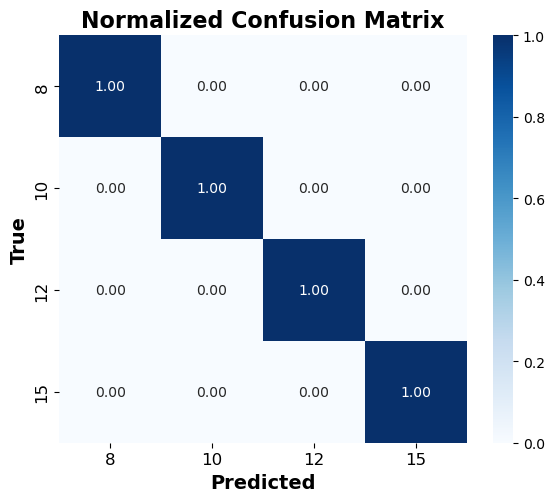

Test set Accuracy: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Confusion Matrix:
[[5 0 0 0]
 [0 5 0 0]
 [0 0 5 0]
 [0 0 0 5]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


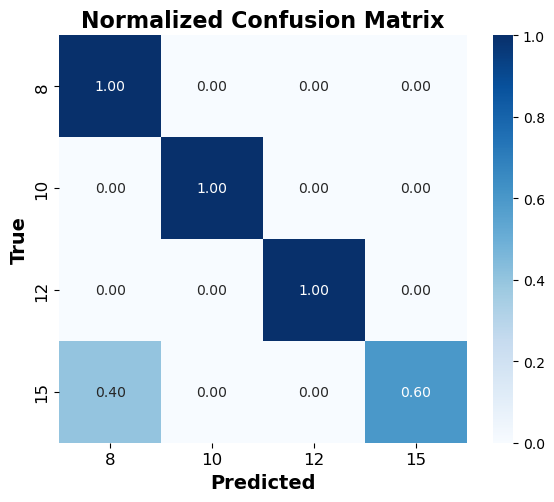

Test set Accuracy: 0.9000
Recall: 0.9000
F1 Score: 0.8958
Confusion Matrix:
[[5 0 0 0]
 [0 5 0 0]
 [0 0 5 0]
 [2 0 0 3]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


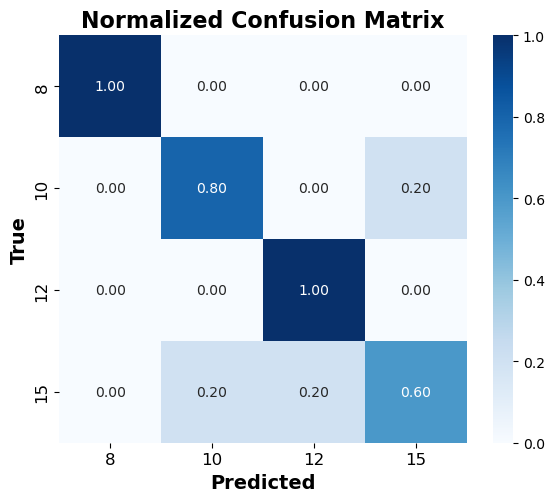

Test set Accuracy: 0.8500
Recall: 0.8500
F1 Score: 0.8439
Confusion Matrix:
[[5 0 0 0]
 [0 4 0 1]
 [0 0 5 0]
 [0 1 1 3]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


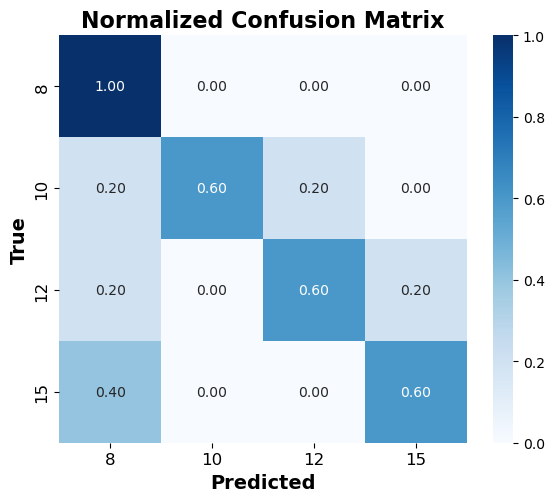

Test set Accuracy: 0.7000
Recall: 0.7000
F1 Score: 0.6994
Confusion Matrix:
[[5 0 0 0]
 [1 3 1 0]
 [1 0 3 1]
 [2 0 0 3]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


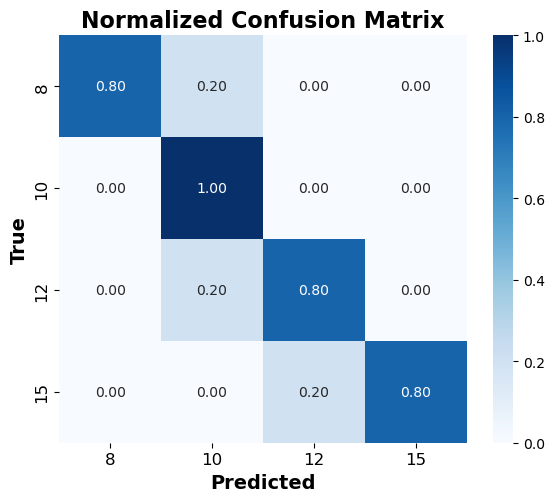

Test set Accuracy: 0.8500
Recall: 0.8500
F1 Score: 0.8528
Confusion Matrix:
[[4 1 0 0]
 [0 5 0 0]
 [0 1 4 0]
 [0 0 1 4]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


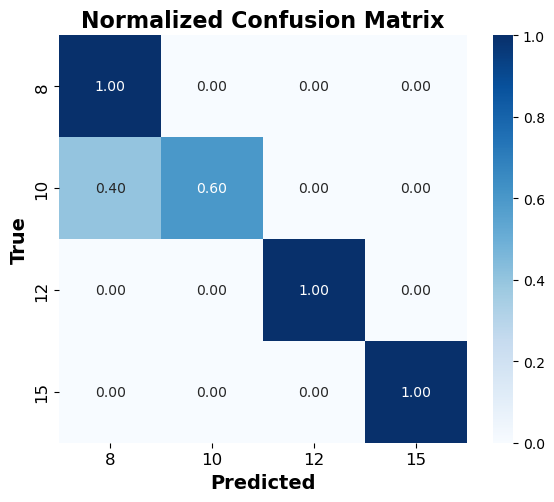

Test set Accuracy: 0.9000
Recall: 0.9000
F1 Score: 0.8958
Confusion Matrix:
[[5 0 0 0]
 [2 3 0 0]
 [0 0 5 0]
 [0 0 0 5]]
Running for subject S25 ---------------


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


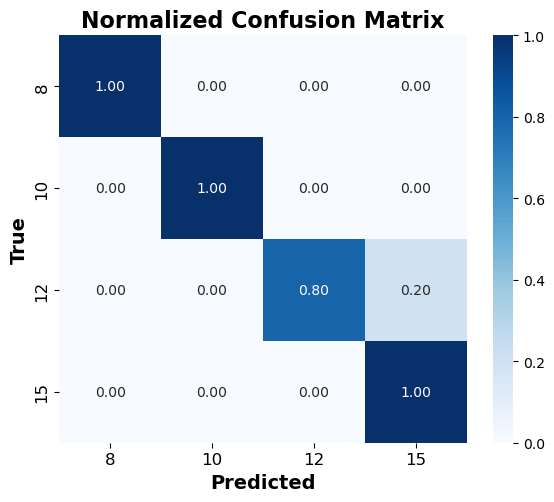

Test set Accuracy: 0.9500
Recall: 0.9500
F1 Score: 0.9495
Confusion Matrix:
[[5 0 0 0]
 [0 5 0 0]
 [0 0 4 1]
 [0 0 0 5]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


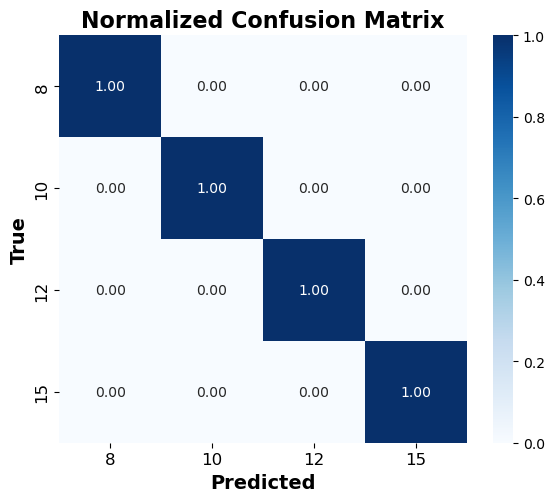

Test set Accuracy: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Confusion Matrix:
[[5 0 0 0]
 [0 5 0 0]
 [0 0 5 0]
 [0 0 0 5]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


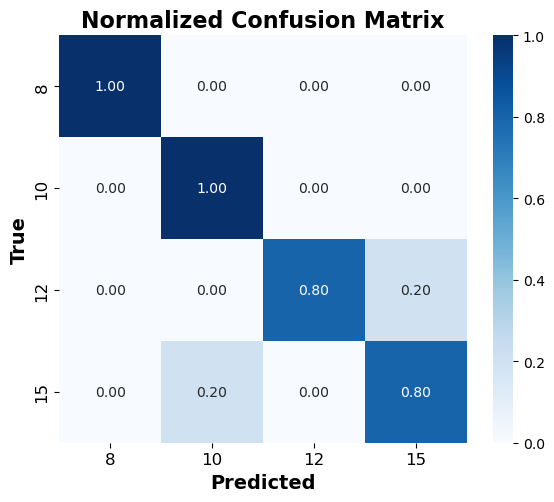

Test set Accuracy: 0.9000
Recall: 0.9000
F1 Score: 0.8995
Confusion Matrix:
[[5 0 0 0]
 [0 5 0 0]
 [0 0 4 1]
 [0 1 0 4]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


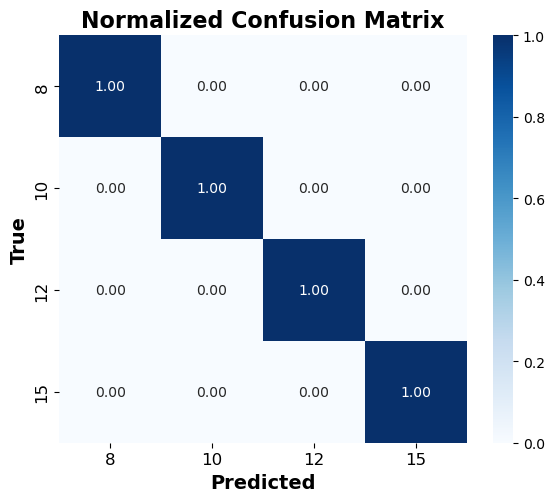

Test set Accuracy: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Confusion Matrix:
[[5 0 0 0]
 [0 5 0 0]
 [0 0 5 0]
 [0 0 0 5]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


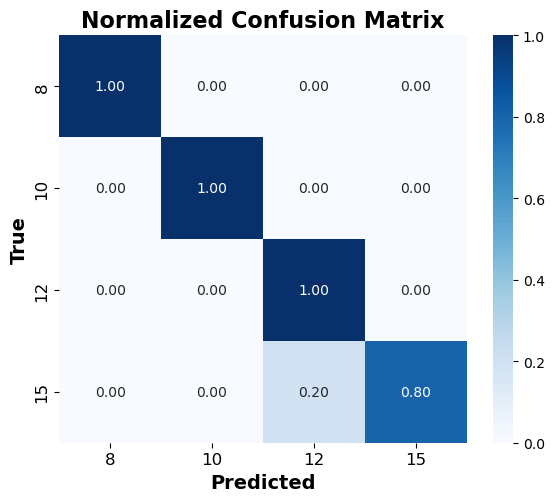

Test set Accuracy: 0.9500
Recall: 0.9500
F1 Score: 0.9495
Confusion Matrix:
[[5 0 0 0]
 [0 5 0 0]
 [0 0 5 0]
 [0 0 1 4]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


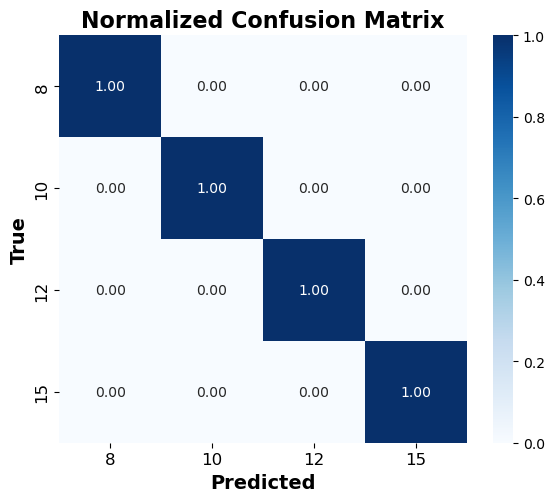

Test set Accuracy: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Confusion Matrix:
[[5 0 0 0]
 [0 5 0 0]
 [0 0 5 0]
 [0 0 0 5]]
Running for subject S26 ---------------


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


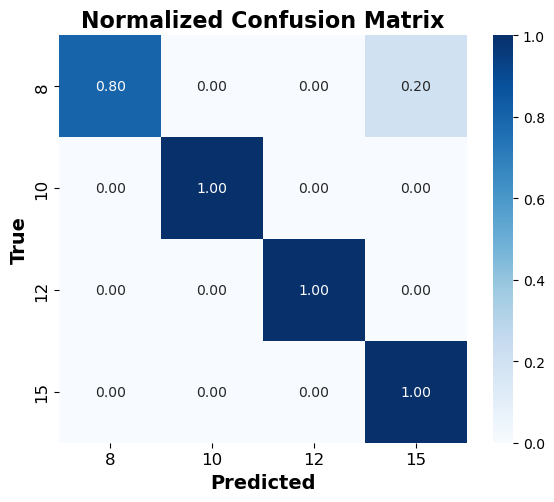

Test set Accuracy: 0.9500
Recall: 0.9500
F1 Score: 0.9495
Confusion Matrix:
[[4 0 0 1]
 [0 5 0 0]
 [0 0 5 0]
 [0 0 0 5]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


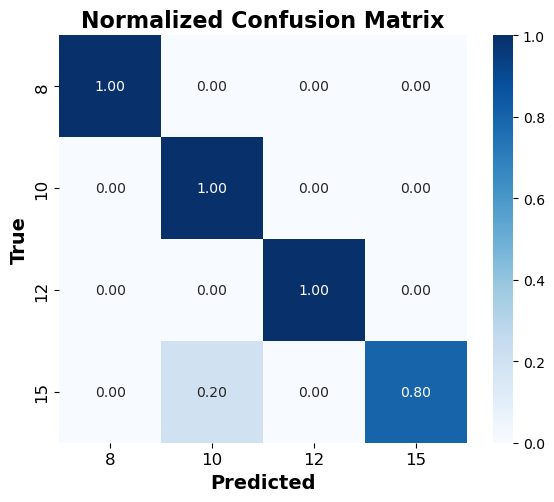

Test set Accuracy: 0.9500
Recall: 0.9500
F1 Score: 0.9495
Confusion Matrix:
[[5 0 0 0]
 [0 5 0 0]
 [0 0 5 0]
 [0 1 0 4]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


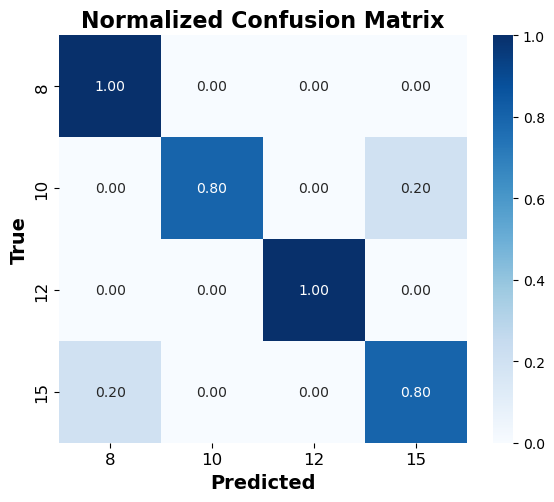

Test set Accuracy: 0.9000
Recall: 0.9000
F1 Score: 0.8995
Confusion Matrix:
[[5 0 0 0]
 [0 4 0 1]
 [0 0 5 0]
 [1 0 0 4]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


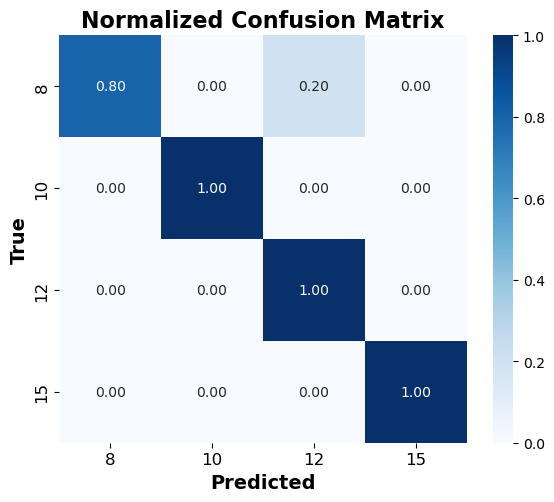

Test set Accuracy: 0.9500
Recall: 0.9500
F1 Score: 0.9495
Confusion Matrix:
[[4 0 1 0]
 [0 5 0 0]
 [0 0 5 0]
 [0 0 0 5]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


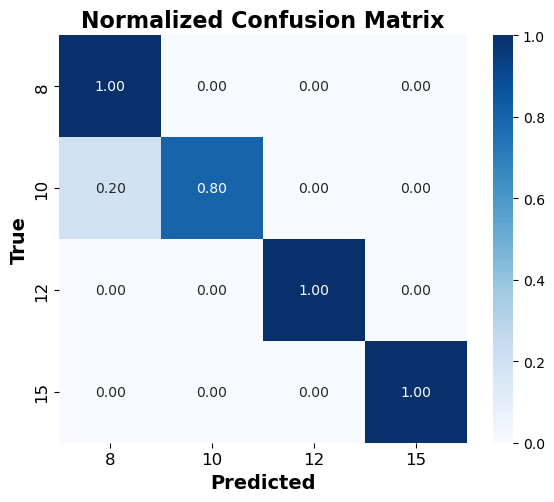

Test set Accuracy: 0.9500
Recall: 0.9500
F1 Score: 0.9495
Confusion Matrix:
[[5 0 0 0]
 [1 4 0 0]
 [0 0 5 0]
 [0 0 0 5]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


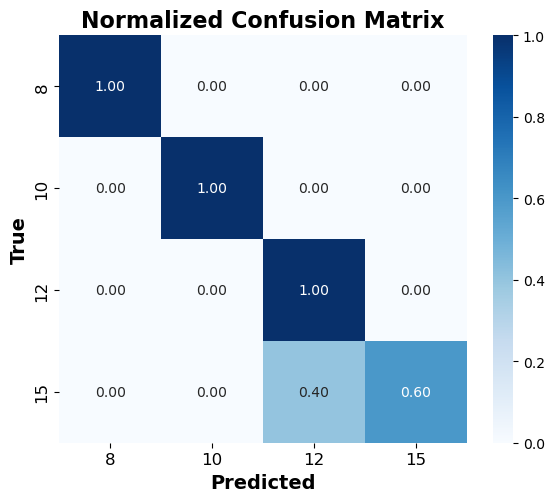

Test set Accuracy: 0.9000
Recall: 0.9000
F1 Score: 0.8958
Confusion Matrix:
[[5 0 0 0]
 [0 5 0 0]
 [0 0 5 0]
 [0 0 2 3]]
Running for subject S27 ---------------


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


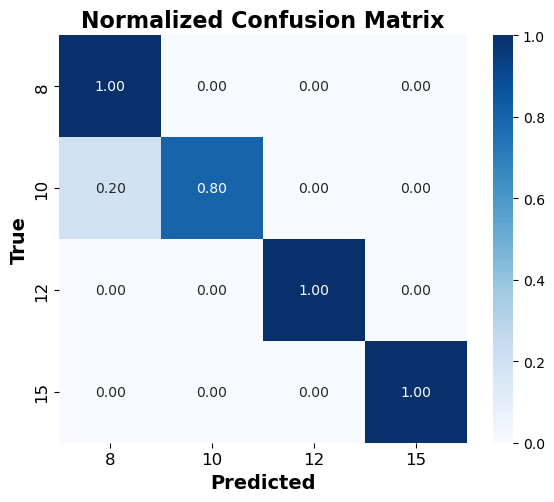

Test set Accuracy: 0.9500
Recall: 0.9500
F1 Score: 0.9495
Confusion Matrix:
[[5 0 0 0]
 [1 4 0 0]
 [0 0 5 0]
 [0 0 0 5]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


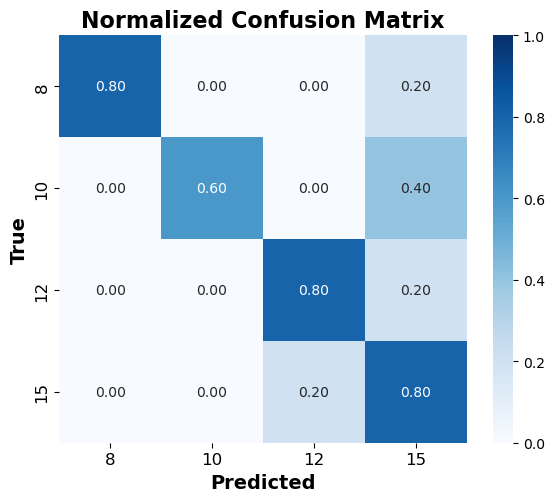

Test set Accuracy: 0.7500
Recall: 0.7500
F1 Score: 0.7636
Confusion Matrix:
[[4 0 0 1]
 [0 3 0 2]
 [0 0 4 1]
 [0 0 1 4]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


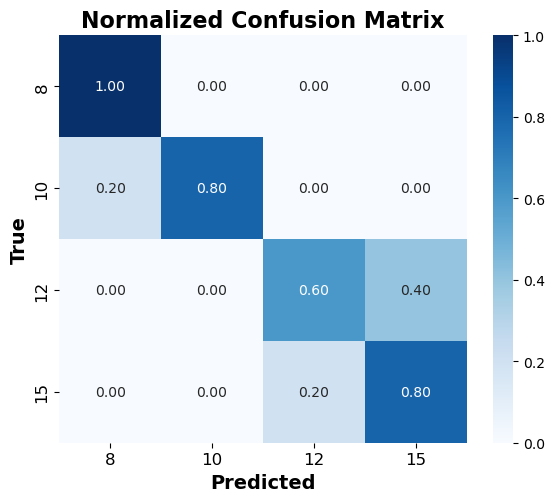

Test set Accuracy: 0.8000
Recall: 0.8000
F1 Score: 0.7980
Confusion Matrix:
[[5 0 0 0]
 [1 4 0 0]
 [0 0 3 2]
 [0 0 1 4]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


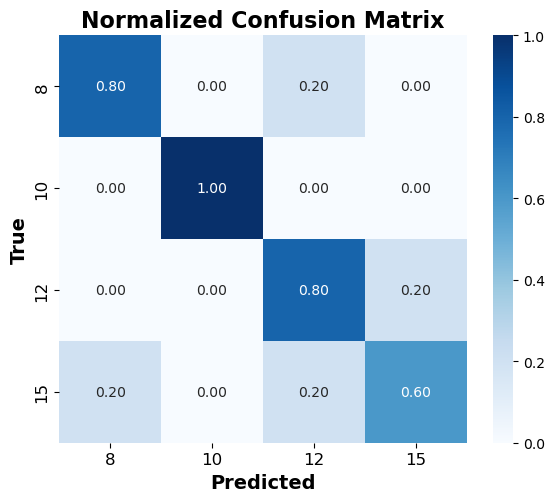

Test set Accuracy: 0.8000
Recall: 0.8000
F1 Score: 0.7985
Confusion Matrix:
[[4 0 1 0]
 [0 5 0 0]
 [0 0 4 1]
 [1 0 1 3]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


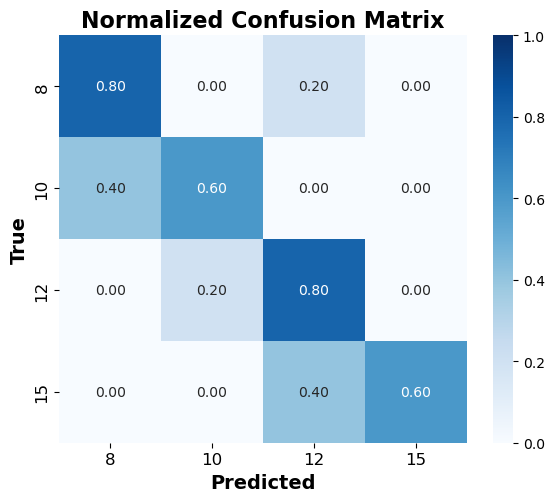

Test set Accuracy: 0.7000
Recall: 0.7000
F1 Score: 0.7027
Confusion Matrix:
[[4 0 1 0]
 [2 3 0 0]
 [0 1 4 0]
 [0 0 2 3]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


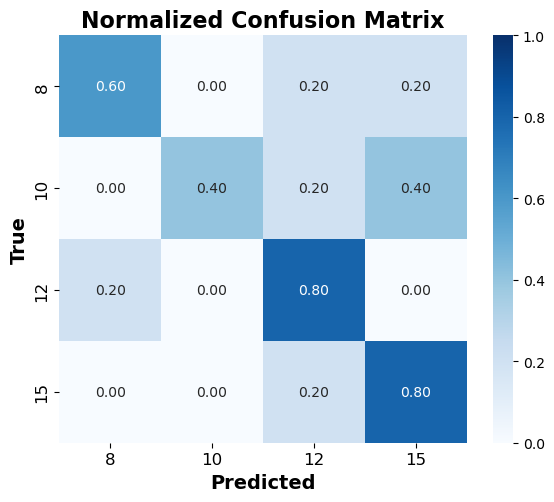

Test set Accuracy: 0.6500
Recall: 0.6500
F1 Score: 0.6429
Confusion Matrix:
[[3 0 1 1]
 [0 2 1 2]
 [1 0 4 0]
 [0 0 1 4]]
Running for subject S28 ---------------


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


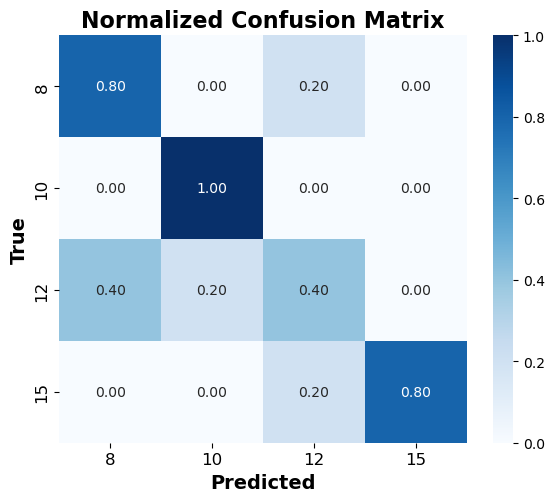

Test set Accuracy: 0.7500
Recall: 0.7500
F1 Score: 0.7424
Confusion Matrix:
[[4 0 1 0]
 [0 5 0 0]
 [2 1 2 0]
 [0 0 1 4]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


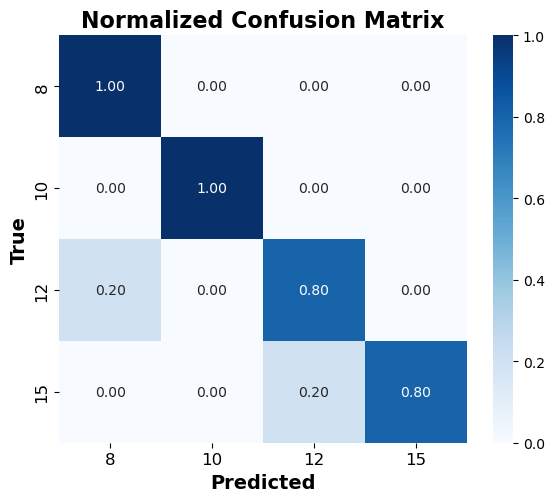

Test set Accuracy: 0.9000
Recall: 0.9000
F1 Score: 0.8995
Confusion Matrix:
[[5 0 0 0]
 [0 5 0 0]
 [1 0 4 0]
 [0 0 1 4]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


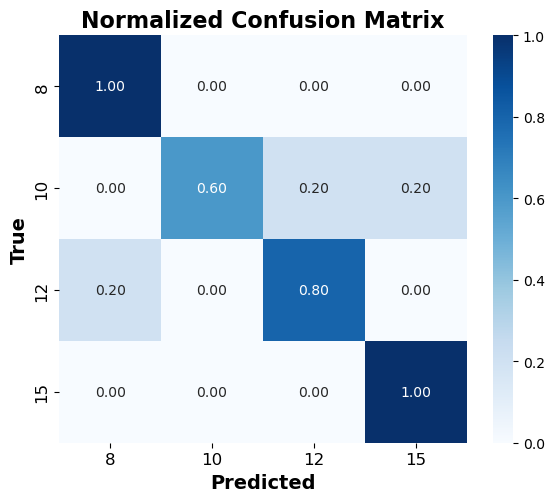

Test set Accuracy: 0.8500
Recall: 0.8500
F1 Score: 0.8420
Confusion Matrix:
[[5 0 0 0]
 [0 3 1 1]
 [1 0 4 0]
 [0 0 0 5]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


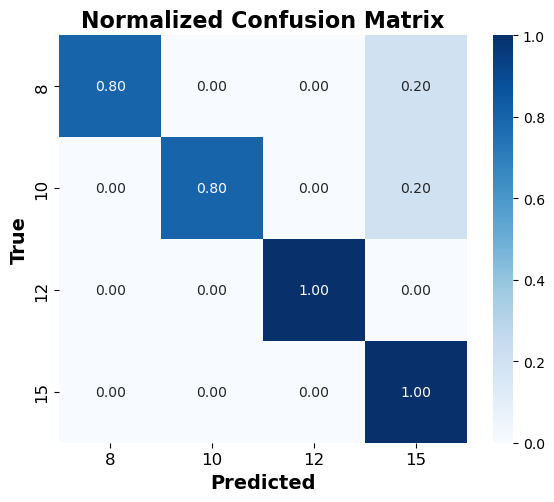

Test set Accuracy: 0.9000
Recall: 0.9000
F1 Score: 0.9028
Confusion Matrix:
[[4 0 0 1]
 [0 4 0 1]
 [0 0 5 0]
 [0 0 0 5]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


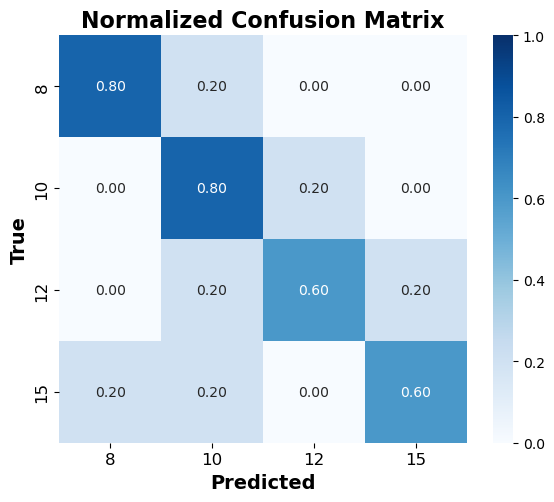

Test set Accuracy: 0.7000
Recall: 0.7000
F1 Score: 0.7000
Confusion Matrix:
[[4 1 0 0]
 [0 4 1 0]
 [0 1 3 1]
 [1 1 0 3]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


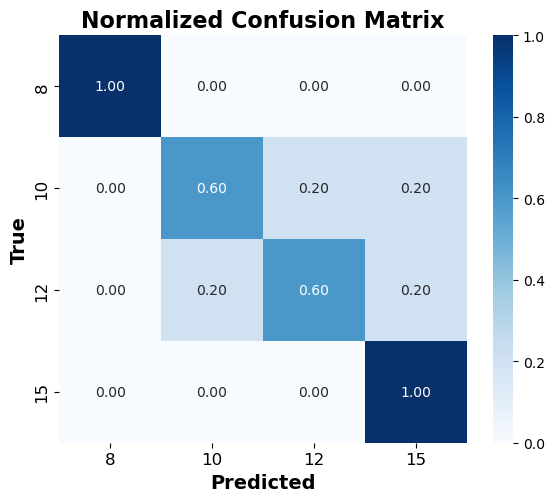

Test set Accuracy: 0.8000
Recall: 0.8000
F1 Score: 0.7917
Confusion Matrix:
[[5 0 0 0]
 [0 3 1 1]
 [0 1 3 1]
 [0 0 0 5]]
Running for subject S29 ---------------


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


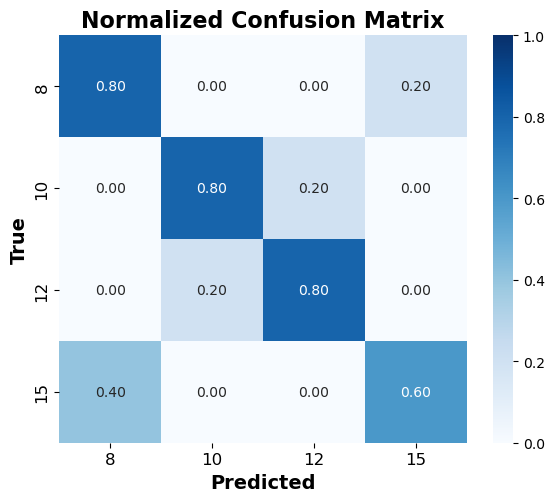

Test set Accuracy: 0.7500
Recall: 0.7500
F1 Score: 0.7485
Confusion Matrix:
[[4 0 0 1]
 [0 4 1 0]
 [0 1 4 0]
 [2 0 0 3]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


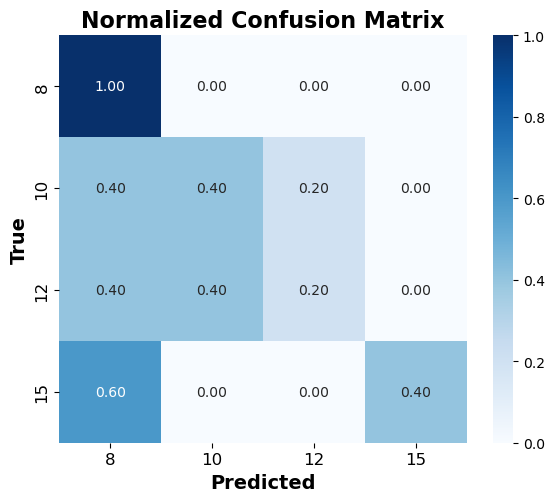

Test set Accuracy: 0.5000
Recall: 0.5000
F1 Score: 0.4725
Confusion Matrix:
[[5 0 0 0]
 [2 2 1 0]
 [2 2 1 0]
 [3 0 0 2]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


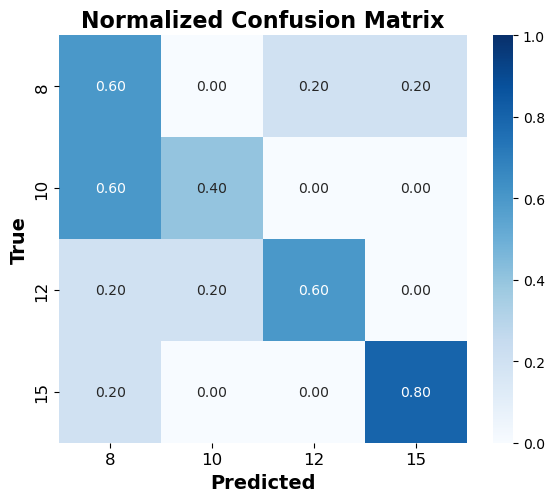

Test set Accuracy: 0.6000
Recall: 0.6000
F1 Score: 0.6071
Confusion Matrix:
[[3 0 1 1]
 [3 2 0 0]
 [1 1 3 0]
 [1 0 0 4]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


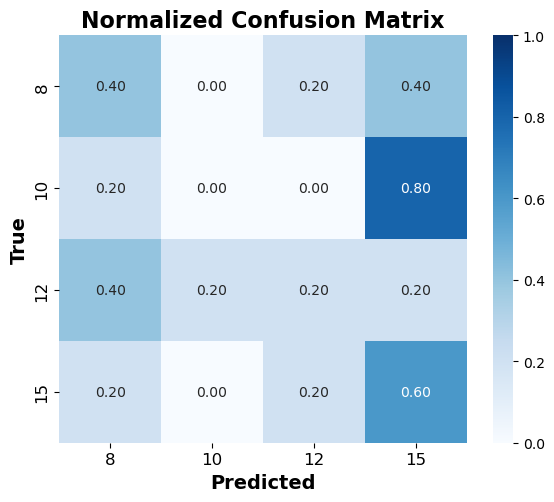

Test set Accuracy: 0.3000
Recall: 0.3000
F1 Score: 0.2534
Confusion Matrix:
[[2 0 1 2]
 [1 0 0 4]
 [2 1 1 1]
 [1 0 1 3]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


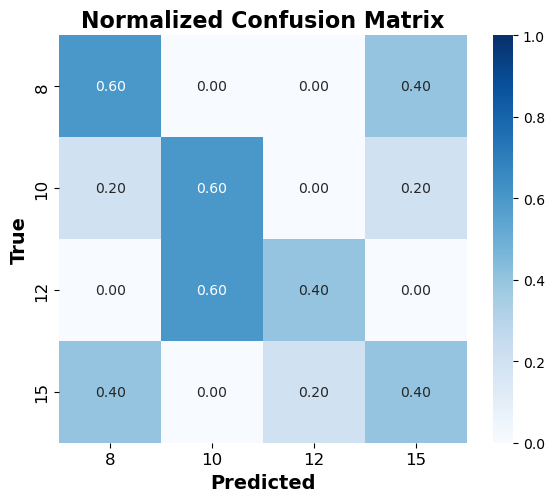

Test set Accuracy: 0.5000
Recall: 0.5000
F1 Score: 0.4977
Confusion Matrix:
[[3 0 0 2]
 [1 3 0 1]
 [0 3 2 0]
 [2 0 1 2]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


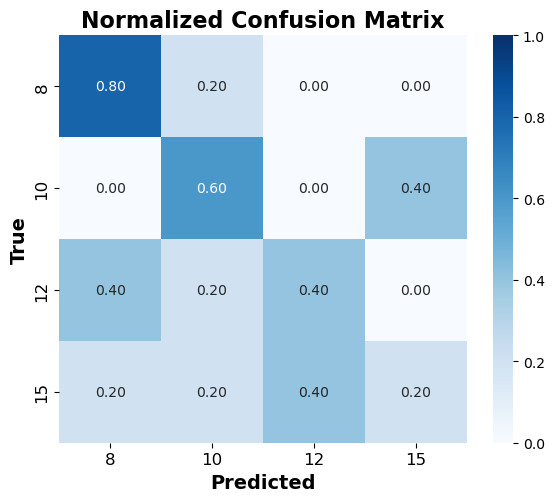

Test set Accuracy: 0.5000
Recall: 0.5000
F1 Score: 0.4766
Confusion Matrix:
[[4 1 0 0]
 [0 3 0 2]
 [2 1 2 0]
 [1 1 2 1]]
Running for subject S30 ---------------


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


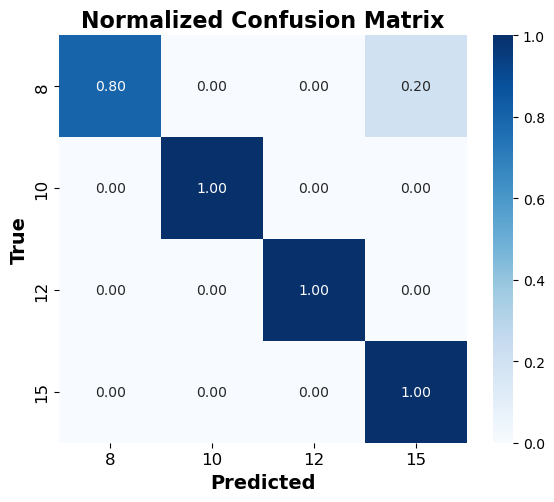

Test set Accuracy: 0.9500
Recall: 0.9500
F1 Score: 0.9495
Confusion Matrix:
[[4 0 0 1]
 [0 5 0 0]
 [0 0 5 0]
 [0 0 0 5]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


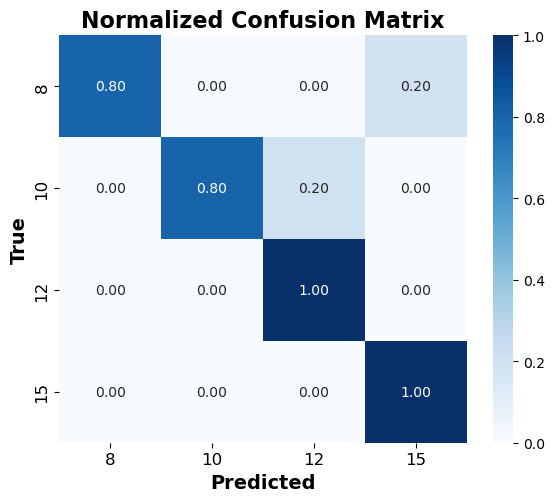

Test set Accuracy: 0.9000
Recall: 0.9000
F1 Score: 0.8990
Confusion Matrix:
[[4 0 0 1]
 [0 4 1 0]
 [0 0 5 0]
 [0 0 0 5]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


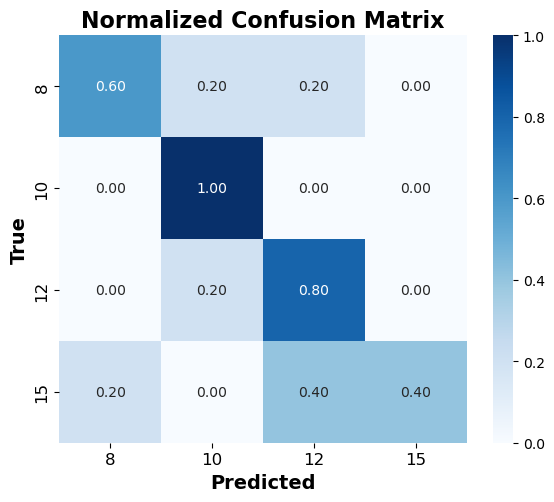

Test set Accuracy: 0.7000
Recall: 0.7000
F1 Score: 0.6845
Confusion Matrix:
[[3 1 1 0]
 [0 5 0 0]
 [0 1 4 0]
 [1 0 2 2]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


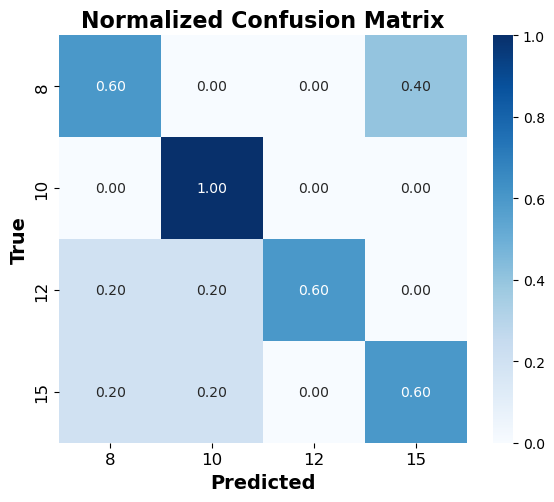

Test set Accuracy: 0.7000
Recall: 0.7000
F1 Score: 0.6958
Confusion Matrix:
[[3 0 0 2]
 [0 5 0 0]
 [1 1 3 0]
 [1 1 0 3]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


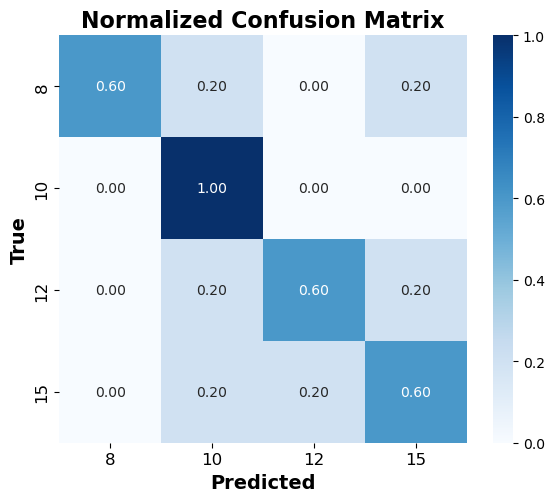

Test set Accuracy: 0.7000
Recall: 0.7000
F1 Score: 0.6965
Confusion Matrix:
[[3 1 0 1]
 [0 5 0 0]
 [0 1 3 1]
 [0 1 1 3]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


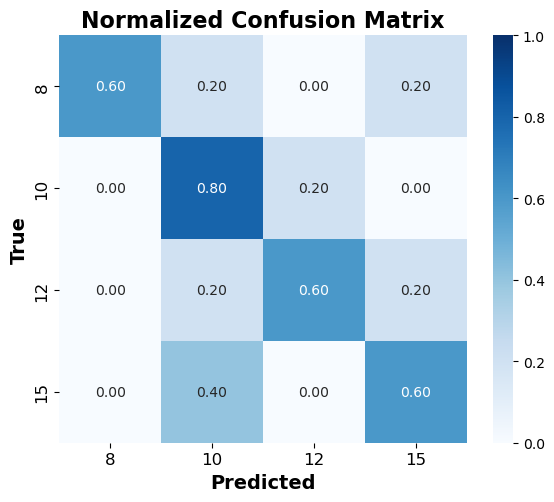

Test set Accuracy: 0.6500
Recall: 0.6500
F1 Score: 0.6580
Confusion Matrix:
[[3 1 0 1]
 [0 4 1 0]
 [0 1 3 1]
 [0 2 0 3]]
Running for subject S31 ---------------


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


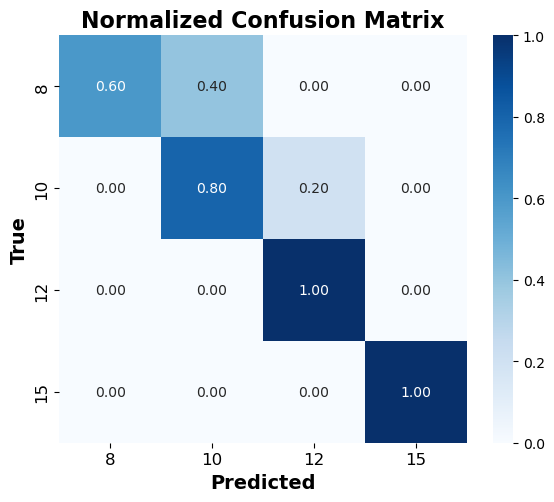

Test set Accuracy: 0.8500
Recall: 0.8500
F1 Score: 0.8466
Confusion Matrix:
[[3 2 0 0]
 [0 4 1 0]
 [0 0 5 0]
 [0 0 0 5]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


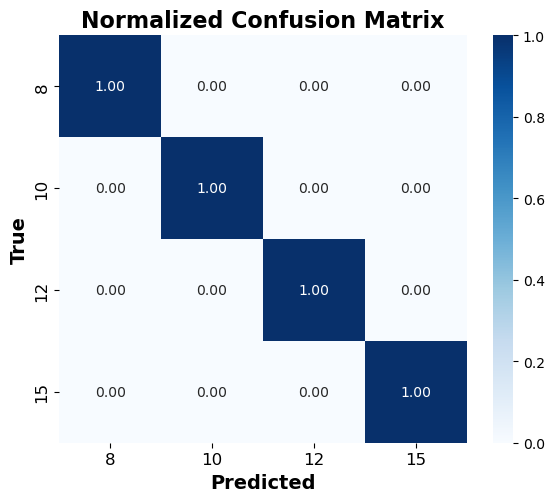

Test set Accuracy: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Confusion Matrix:
[[5 0 0 0]
 [0 5 0 0]
 [0 0 5 0]
 [0 0 0 5]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


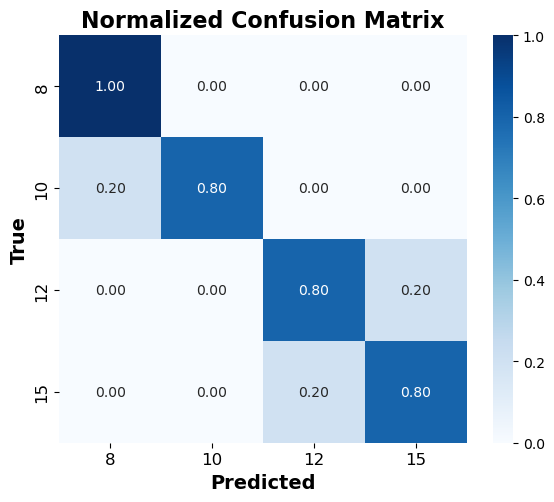

Test set Accuracy: 0.8500
Recall: 0.8500
F1 Score: 0.8495
Confusion Matrix:
[[5 0 0 0]
 [1 4 0 0]
 [0 0 4 1]
 [0 0 1 4]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


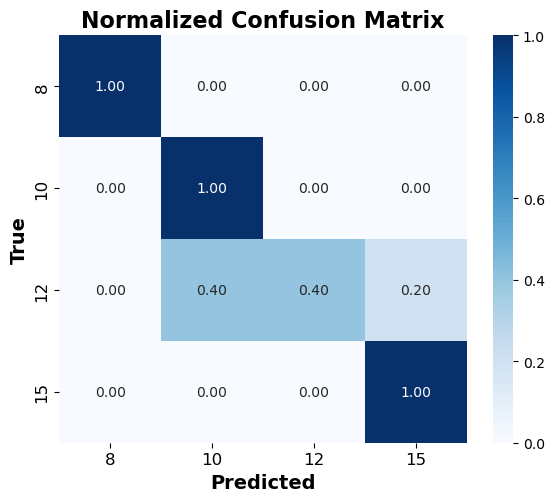

Test set Accuracy: 0.8500
Recall: 0.8500
F1 Score: 0.8285
Confusion Matrix:
[[5 0 0 0]
 [0 5 0 0]
 [0 2 2 1]
 [0 0 0 5]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


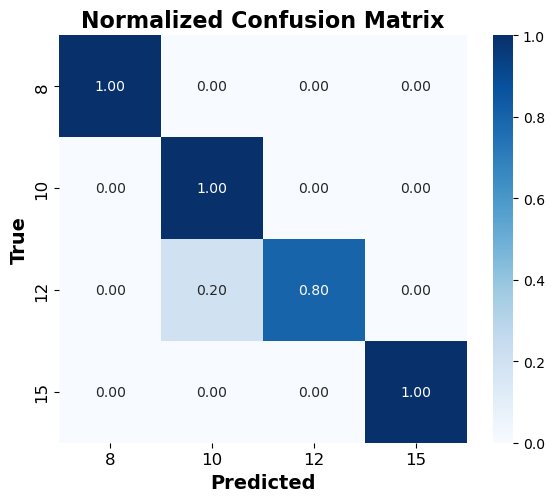

Test set Accuracy: 0.9500
Recall: 0.9500
F1 Score: 0.9495
Confusion Matrix:
[[5 0 0 0]
 [0 5 0 0]
 [0 1 4 0]
 [0 0 0 5]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


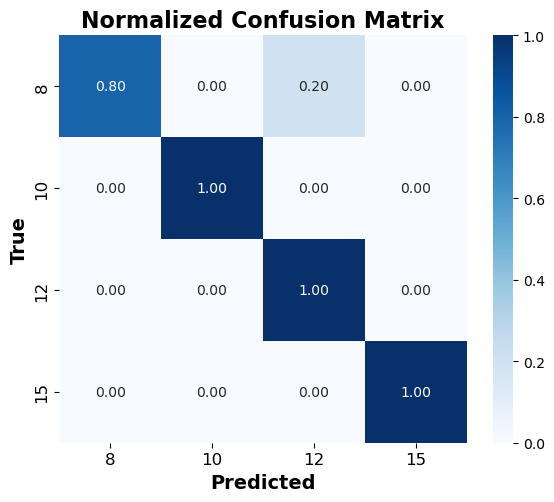

Test set Accuracy: 0.9500
Recall: 0.9500
F1 Score: 0.9495
Confusion Matrix:
[[4 0 1 0]
 [0 5 0 0]
 [0 0 5 0]
 [0 0 0 5]]
Running for subject S32 ---------------


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


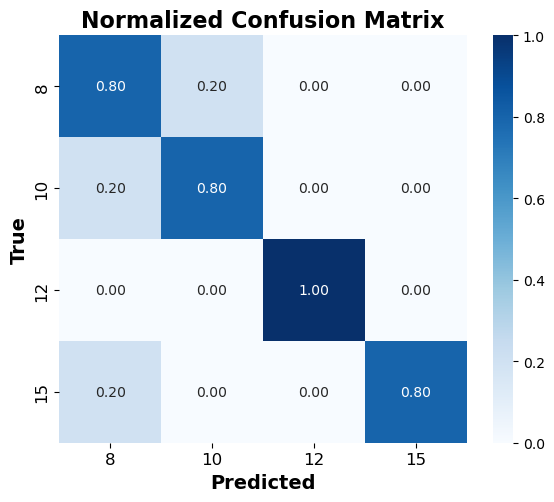

Test set Accuracy: 0.8500
Recall: 0.8500
F1 Score: 0.8540
Confusion Matrix:
[[4 1 0 0]
 [1 4 0 0]
 [0 0 5 0]
 [1 0 0 4]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


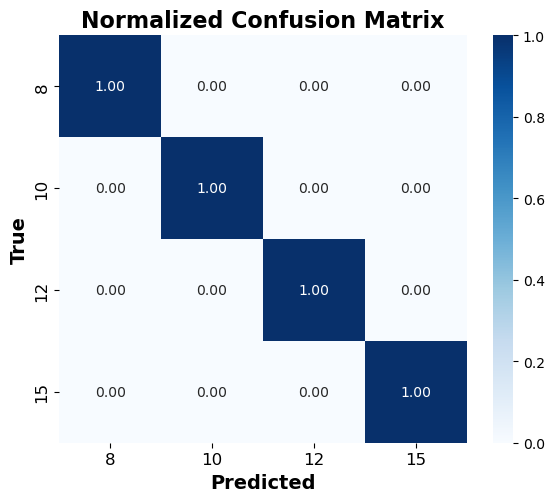

Test set Accuracy: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Confusion Matrix:
[[5 0 0 0]
 [0 5 0 0]
 [0 0 5 0]
 [0 0 0 5]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


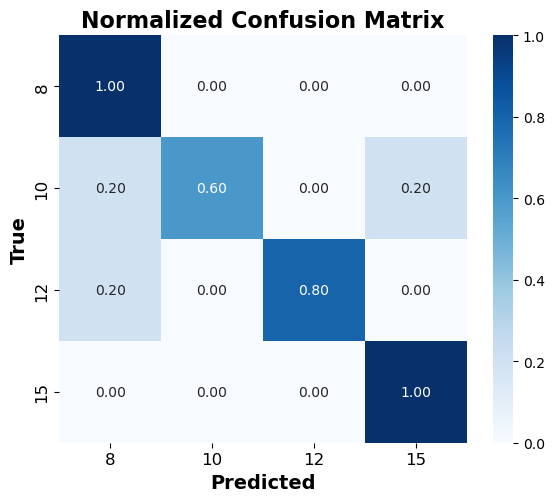

Test set Accuracy: 0.8500
Recall: 0.8500
F1 Score: 0.8453
Confusion Matrix:
[[5 0 0 0]
 [1 3 0 1]
 [1 0 4 0]
 [0 0 0 5]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


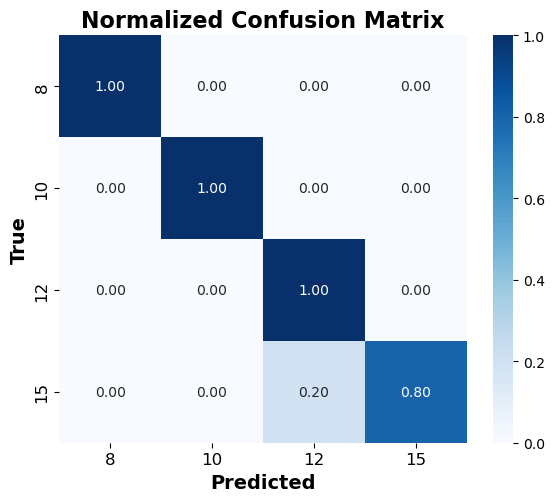

Test set Accuracy: 0.9500
Recall: 0.9500
F1 Score: 0.9495
Confusion Matrix:
[[5 0 0 0]
 [0 5 0 0]
 [0 0 5 0]
 [0 0 1 4]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


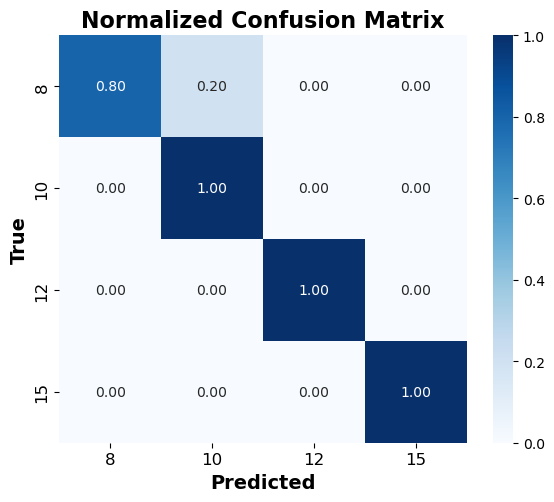

Test set Accuracy: 0.9500
Recall: 0.9500
F1 Score: 0.9495
Confusion Matrix:
[[4 1 0 0]
 [0 5 0 0]
 [0 0 5 0]
 [0 0 0 5]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


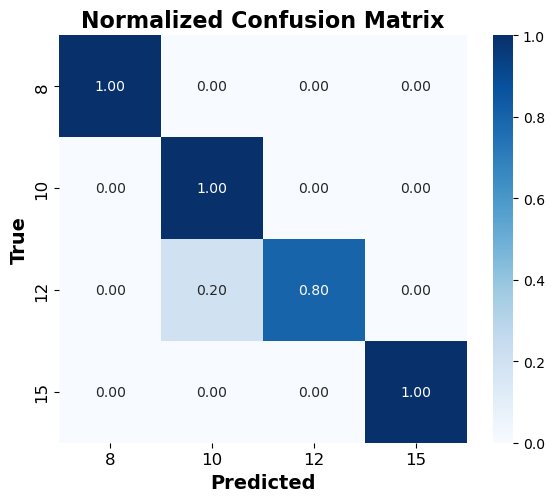

Test set Accuracy: 0.9500
Recall: 0.9500
F1 Score: 0.9495
Confusion Matrix:
[[5 0 0 0]
 [0 5 0 0]
 [0 1 4 0]
 [0 0 0 5]]
Running for subject S33 ---------------


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


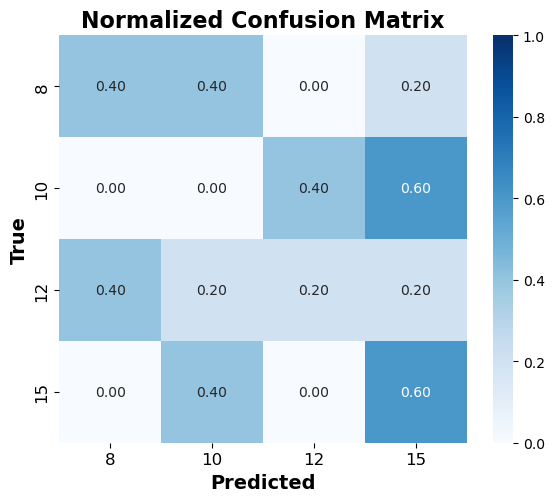

Test set Accuracy: 0.3000
Recall: 0.3000
F1 Score: 0.2890
Confusion Matrix:
[[2 2 0 1]
 [0 0 2 3]
 [2 1 1 1]
 [0 2 0 3]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


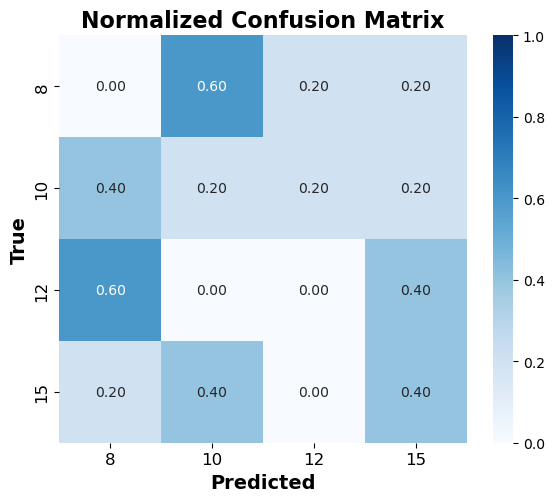

Test set Accuracy: 0.1500
Recall: 0.1500
F1 Score: 0.1364
Confusion Matrix:
[[0 3 1 1]
 [2 1 1 1]
 [3 0 0 2]
 [1 2 0 2]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


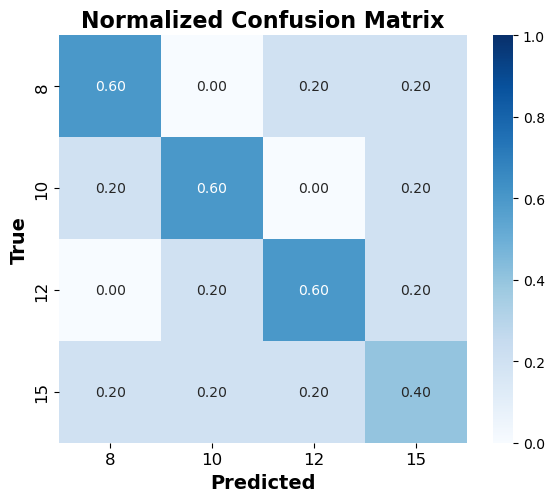

Test set Accuracy: 0.5500
Recall: 0.5500
F1 Score: 0.5500
Confusion Matrix:
[[3 0 1 1]
 [1 3 0 1]
 [0 1 3 1]
 [1 1 1 2]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


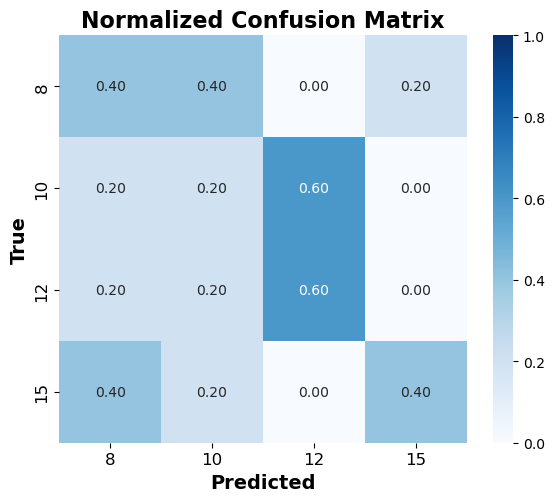

Test set Accuracy: 0.4000
Recall: 0.4000
F1 Score: 0.4023
Confusion Matrix:
[[2 2 0 1]
 [1 1 3 0]
 [1 1 3 0]
 [2 1 0 2]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


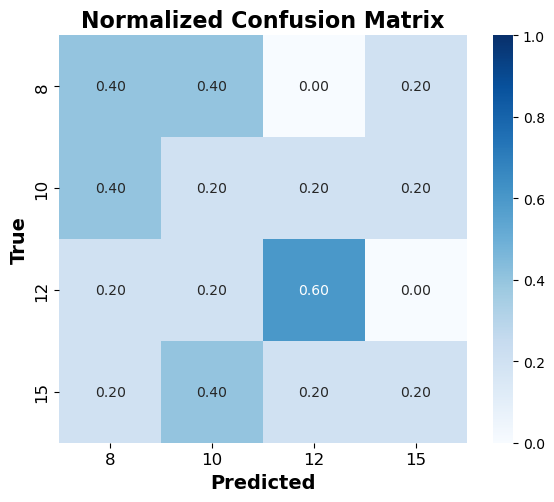

Test set Accuracy: 0.3500
Recall: 0.3500
F1 Score: 0.3489
Confusion Matrix:
[[2 2 0 1]
 [2 1 1 1]
 [1 1 3 0]
 [1 2 1 1]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


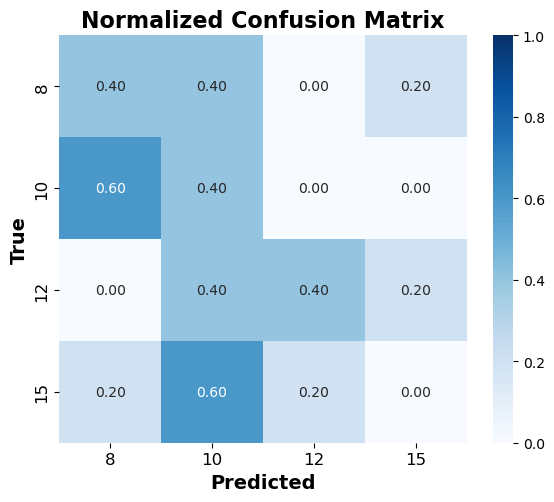

Test set Accuracy: 0.3000
Recall: 0.3000
F1 Score: 0.2873
Confusion Matrix:
[[2 2 0 1]
 [3 2 0 0]
 [0 2 2 1]
 [1 3 1 0]]
Running for subject S34 ---------------


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


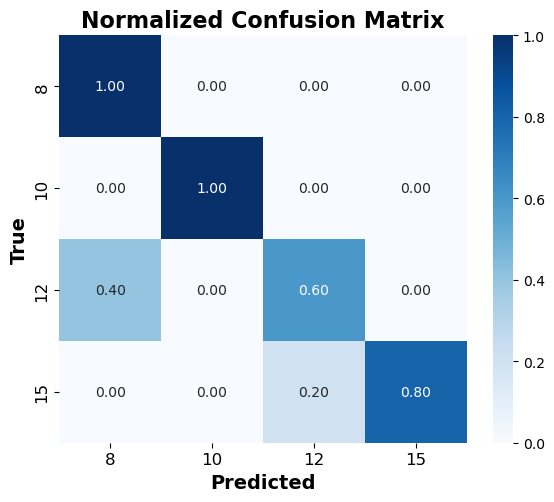

Test set Accuracy: 0.8500
Recall: 0.8500
F1 Score: 0.8472
Confusion Matrix:
[[5 0 0 0]
 [0 5 0 0]
 [2 0 3 0]
 [0 0 1 4]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


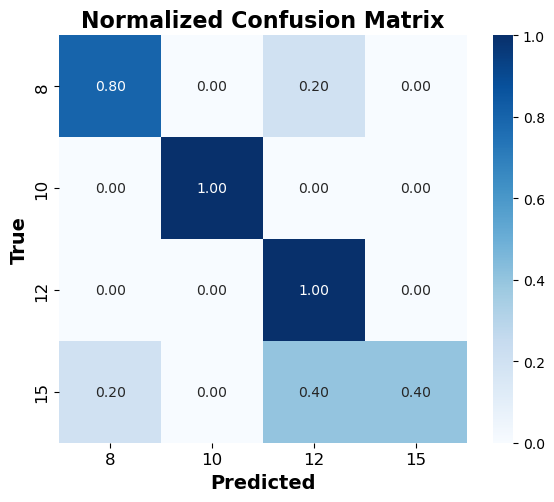

Test set Accuracy: 0.8000
Recall: 0.8000
F1 Score: 0.7852
Confusion Matrix:
[[4 0 1 0]
 [0 5 0 0]
 [0 0 5 0]
 [1 0 2 2]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


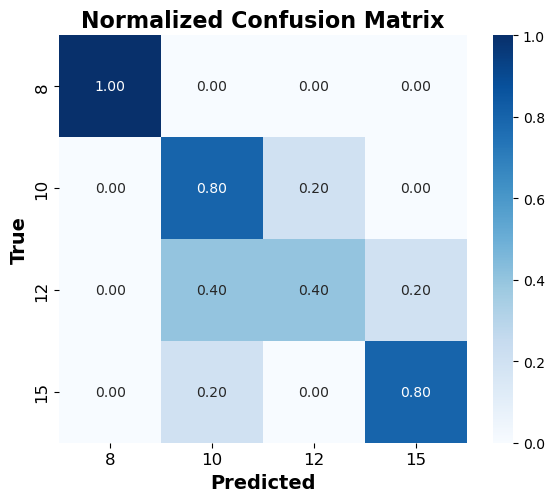

Test set Accuracy: 0.7500
Recall: 0.7500
F1 Score: 0.7417
Confusion Matrix:
[[5 0 0 0]
 [0 4 1 0]
 [0 2 2 1]
 [0 1 0 4]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


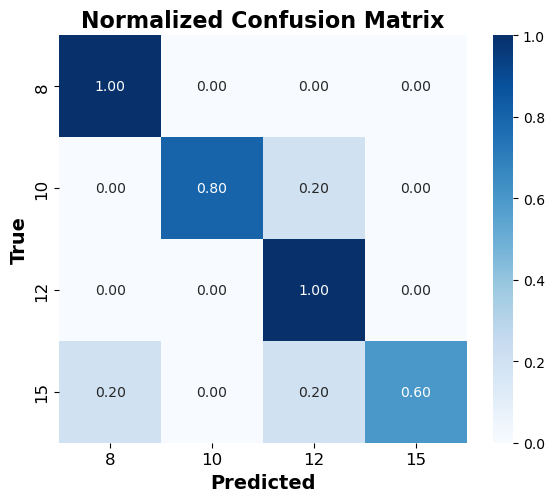

Test set Accuracy: 0.8500
Recall: 0.8500
F1 Score: 0.8453
Confusion Matrix:
[[5 0 0 0]
 [0 4 1 0]
 [0 0 5 0]
 [1 0 1 3]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


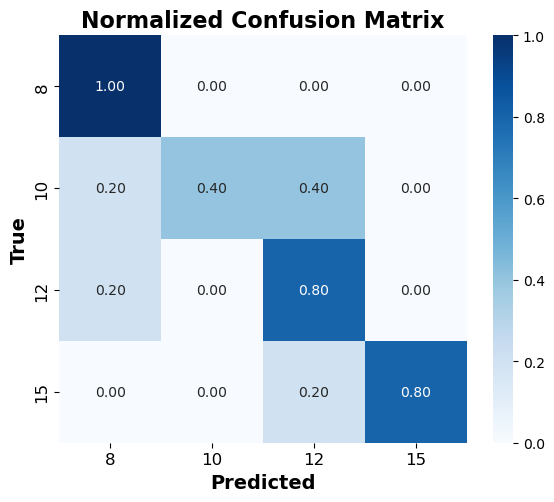

Test set Accuracy: 0.7500
Recall: 0.7500
F1 Score: 0.7401
Confusion Matrix:
[[5 0 0 0]
 [1 2 2 0]
 [1 0 4 0]
 [0 0 1 4]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


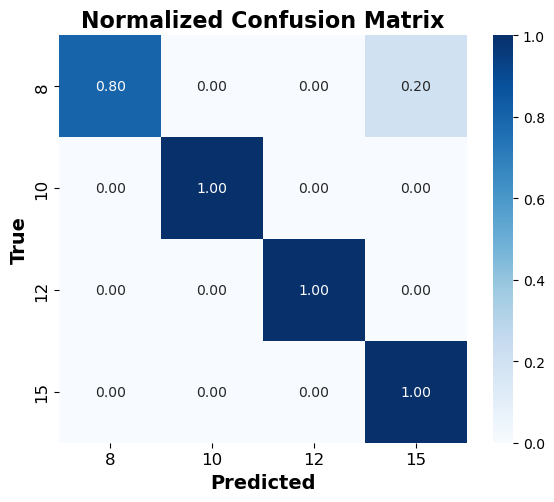

Test set Accuracy: 0.9500
Recall: 0.9500
F1 Score: 0.9495
Confusion Matrix:
[[4 0 0 1]
 [0 5 0 0]
 [0 0 5 0]
 [0 0 0 5]]
Running for subject S35 ---------------


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


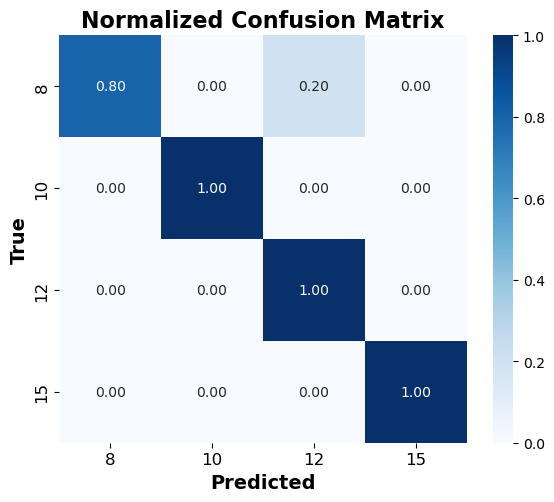

Test set Accuracy: 0.9500
Recall: 0.9500
F1 Score: 0.9495
Confusion Matrix:
[[4 0 1 0]
 [0 5 0 0]
 [0 0 5 0]
 [0 0 0 5]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


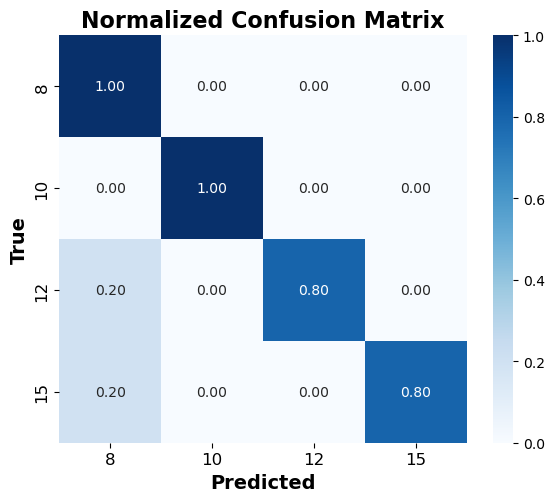

Test set Accuracy: 0.9000
Recall: 0.9000
F1 Score: 0.9028
Confusion Matrix:
[[5 0 0 0]
 [0 5 0 0]
 [1 0 4 0]
 [1 0 0 4]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


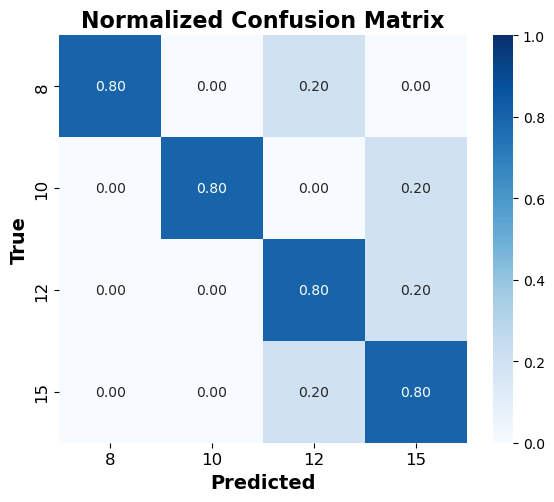

Test set Accuracy: 0.8000
Recall: 0.8000
F1 Score: 0.8081
Confusion Matrix:
[[4 0 1 0]
 [0 4 0 1]
 [0 0 4 1]
 [0 0 1 4]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


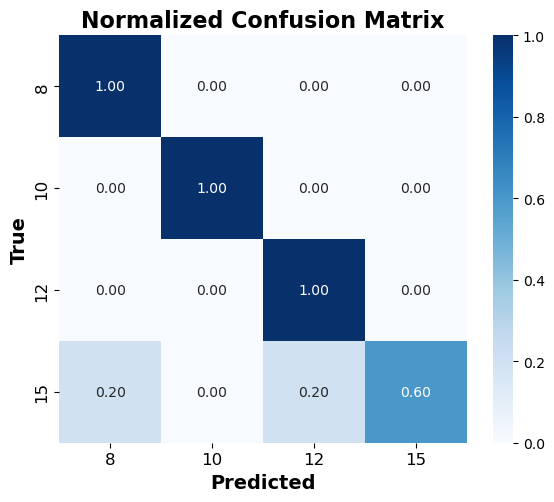

Test set Accuracy: 0.9000
Recall: 0.9000
F1 Score: 0.8920
Confusion Matrix:
[[5 0 0 0]
 [0 5 0 0]
 [0 0 5 0]
 [1 0 1 3]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


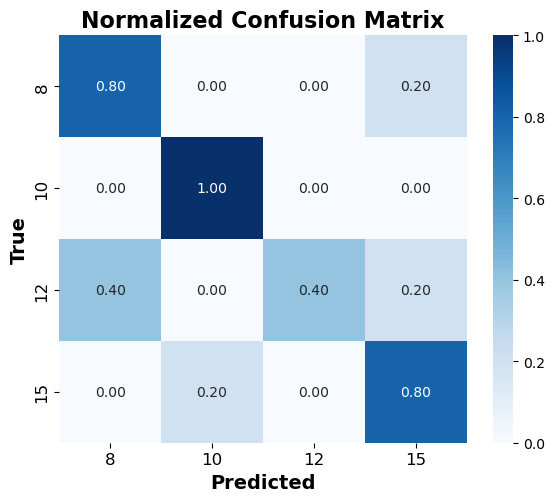

Test set Accuracy: 0.7500
Recall: 0.7500
F1 Score: 0.7338
Confusion Matrix:
[[4 0 0 1]
 [0 5 0 0]
 [2 0 2 1]
 [0 1 0 4]]


c:\Users\machi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


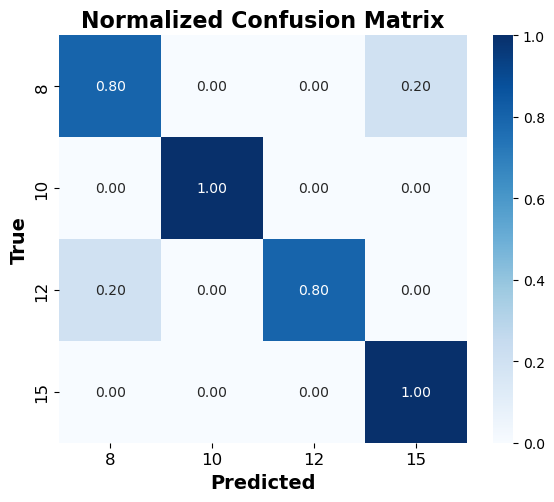

Test set Accuracy: 0.9000
Recall: 0.9000
F1 Score: 0.8995
Confusion Matrix:
[[4 0 0 1]
 [0 5 0 0]
 [1 0 4 0]
 [0 0 0 5]]


{'S1': {'accuracy': array([0.8 , 0.75, 0.8 , 0.6 , 0.6 , 0.6 ]),
  'recall': array([0.8 , 0.75, 0.8 , 0.6 , 0.6 , 0.6 ]),
  'f1_score': array([0.79848485, 0.74659091, 0.79583333, 0.5534188 , 0.61313131,
         0.59444444])},
 'S2': {'accuracy': array([0.5 , 0.6 , 0.25, 0.55, 0.45, 0.55]),
  'recall': array([0.5 , 0.6 , 0.25, 0.55, 0.45, 0.55]),
  'f1_score': array([0.48285048, 0.6       , 0.2       , 0.5468254 , 0.43681319,
         0.54292929])},
 'S3': {'accuracy': array([0.7 , 0.9 , 0.8 , 0.85, 0.8 , 0.7 ]),
  'recall': array([0.7 , 0.9 , 0.8 , 0.85, 0.8 , 0.7 ]),
  'f1_score': array([0.68300866, 0.89583333, 0.79583333, 0.84532828, 0.79848485,
         0.68876263])},
 'S4': {'accuracy': array([1.  , 0.65, 0.8 , 0.8 , 0.55, 0.55]),
  'recall': array([1.  , 0.65, 0.8 , 0.8 , 0.55, 0.55]),
  'f1_score': array([1.        , 0.59393939, 0.79659091, 0.8040404 , 0.56666667,
         0.51587302])},
 'S5': {'accuracy': array([0.7 , 0.65, 0.85, 0.75, 0.65, 0.75]),
  'recall': array([0.7 , 0.

In [31]:
dataset_path = Path("datasets/sinais_filtrados_6_52_Hz_janelas_1s/")
selected_freqs = np.array([8, 10, 12, 15])  # Frequências de interesse
channels = [
    47,
    53,
    54,
    55,
    56,
    57,
    60,
    61,
    62,
]  #  Pz, PO5, PO3, POz, PO4, PO6, O1, Oz, O2

n_channels = 9  # Number of input channels
elm_hidden_units = 1024  # Number of ELM hidden units
n_classes = 4  # Number of output classes
regularization = None
small = True

results_dict = run_celm_for_all_subjects(
    dataset_path, 20, channels, selected_freqs, elm_hidden_units
)
results_dict

In [32]:
import pandas as pd

mean_results_dict = {}
for subj, metrics in results_dict.items():
    means = {}
    for metric, values in metrics.items():
        means[metric] = values.mean()
    mean_results_dict[subj] = means
df = pd.DataFrame.from_dict(mean_results_dict, orient="index")
df.to_csv("results_celm1d_intra_subj_2.csv")